# Data Cleaning
- Basic Cleaning
- Merging Target, Time Series Features, and Static Features
- Handling Wrong Data: Eliminating Incorrect Fiscal Year Dates
- Elimination of Features with too Much Missing Data
- Handling Missing Data by Imputation
- Handling Outliers / Noise Reduction

In [1]:
from datetime import datetime
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib
import platform
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
import sys

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.max_colwidth = None

date_format = '%Y-%m-%d'

In [2]:
my_os = platform.system()
print('OS in my system: ',my_os)

if my_os == 'Windows':
    path = str(pathlib.Path().absolute()) + '\\'
    path = path.replace('3_data_pre-processing', '1_data_collection')
    slash = '\\'
else:
    path = str(pathlib.Path().absolute()) + '/'
    path = path.replace('3_data_pre-processing', '1_data_collection')
    slash = '/'

artif_path = path + 'data_artifacts' + slash
copula_path = path + 'data_artifacts' + slash + 'copulas' + slash

OS in my system:  Windows


## Load data

In [3]:
# eikon spx
target = pd.read_excel(copula_path + '1_3_18_e_target_spx.xlsx')
cop_3y = pd.read_excel(copula_path + '1_5_0_e_cop_3y_spx.xlsx')
cop_5y = pd.read_excel(copula_path + '1_5_10_e_cop_5y_spx.xlsx')
file_name = 'data_set_e_spx_1-cleaned.csv'

timeseries = pd.read_excel(artif_path + 'eikon_features_2001-2021.xlsx', sheet_name = 'features_2001-2021')
statics = pd.read_excel(artif_path + 'eikon_general_stock_info.xlsx')

mapping = pd.read_excel(path + 'possible_features.xlsx', sheet_name = 'mapping')

## ----------------------------------------

## Basic Cleaning
### Copula Data
- droping unnecessary columns
- renaming

In [4]:
display(target.head())
target = target.drop(columns=['Unnamed: 0'])
target = target.rename(columns={'tau': 'tau_target_ori'})
target = target.rename(columns={'family': 'fam_target_ori'})
target = target.rename(columns={'rotation': 'rot_target_ori'})
target = target.rename(columns={'parameters': 'par_target_ori'})

target['fam_target_ori'] = target['fam_target_ori'].replace('BicopFamily.clayton', 'clayton')
target['fam_target_ori'] = target['fam_target_ori'].replace('BicopFamily.gaussian', 'gaussian')
target['fam_target_ori'] = target['fam_target_ori'].replace('BicopFamily.frank', 'frank')
target['fam_target_ori'] = target['fam_target_ori'].replace('BicopFamily.gumbel', 'gumbel')
target['fam_target_ori'] = target['fam_target_ori'].replace('BicopFamily.student', 'student')
target['fam_target_ori'] = target['fam_target_ori'].replace('BicopFamily.indep', 'indep')
target['fam_target_ori'] = target['fam_target_ori'].replace('BicopFamily.joe', 'joe')

display(target.head())
display(target.info())
print('Amount of companies: ' + str(len(target['symbol'].drop_duplicates())))

Unnamed: 0 symbol  year                family  rotation       tau  \
0           0      A  2000   BicopFamily.clayton         0  0.232904   
1           1      A  2001  BicopFamily.gaussian         0  0.458727   
2           2      A  2002     BicopFamily.frank         0  0.499681   
3           3      A  2003    BicopFamily.gumbel       180  0.505513   
4           4      A  2004     BicopFamily.frank         0  0.462612   

       parameters  
0    [[0.607237]]  
1  [[0.65981076]]  
2  [[5.73048141]]  
3  [[2.02229729]]  
4  [[5.09499262]]

symbol  year fam_target_ori  rot_target_ori  tau_target_ori  par_target_ori
0      A  2000        clayton               0        0.232904    [[0.607237]]
1      A  2001       gaussian               0        0.458727  [[0.65981076]]
2      A  2002          frank               0        0.499681  [[5.73048141]]
3      A  2003         gumbel             180        0.505513  [[2.02229729]]
4      A  2004          frank               0        0.462612  [[5.09499262]]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47758 entries, 0 to 47757
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   symbol          47758 non-null  object 
 1   year            47758 non-null  int64  
 2   fam_target_ori  47758 non-null  object 
 3   rot_target_ori  47758 non-null  int64  
 4   tau_target_ori  47758 non-null  float64
 5   par_target_ori  47758 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 2.2+ MB


None

Amount of companies: 3150


In [5]:
display(cop_3y.head())
cop_3y = cop_3y.drop(columns=['Unnamed: 0', 'family', 'rotation', 'parameters'])
cop_3y = cop_3y.rename(columns={'tau': 'tau_cop_3y'})

display(cop_3y.head())
display(cop_3y.info())
print('Amount of companies: ' + str(len(cop_3y['symbol'].drop_duplicates())))

Unnamed: 0 symbol  year                family  rotation       tau  \
0           0      A  2000   BicopFamily.clayton         0  0.232904   
1           1      A  2001  BicopFamily.gaussian         0  0.344151   
2           2      A  2002     BicopFamily.frank         0  0.391592   
3           3      A  2003   BicopFamily.student         0  0.471121   
4           4      A  2004   BicopFamily.student         0  0.485946   

                      parameters  
0                   [[0.607237]]  
1                 [[0.51464281]]  
2                 [[4.04635815]]  
3  [[0.67431406]\n [8.49320555]]  
4  [[0.6913253 ]\n [6.38771666]]

symbol  year  tau_cop_3y
0      A  2000    0.232904
1      A  2001    0.344151
2      A  2002    0.391592
3      A  2003    0.471121
4      A  2004    0.485946

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53056 entries, 0 to 53055
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   symbol      53056 non-null  object 
 1   year        53056 non-null  int64  
 2   tau_cop_3y  53056 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.2+ MB


None

Amount of companies: 3185


In [6]:
display(cop_5y.head())
cop_5y = cop_5y.drop(columns=['Unnamed: 0', 'family', 'rotation', 'parameters'])
cop_5y = cop_5y.rename(columns={'tau': 'tau_cop_5y'})

display(cop_5y.head())
display(cop_5y.info())
print('Amount of companies: ' + str(len(cop_5y['symbol'].drop_duplicates())))

Unnamed: 0 symbol  year                family  rotation       tau  \
0           0      A  2000   BicopFamily.clayton         0  0.232904   
1           1      A  2001  BicopFamily.gaussian         0  0.344151   
2           2      A  2002     BicopFamily.frank         0  0.391592   
3           3      A  2003     BicopFamily.frank         0  0.417179   
4           4      A  2004     BicopFamily.frank         0  0.425203   

       parameters  
0    [[0.607237]]  
1  [[0.51464281]]  
2  [[4.04635815]]  
3  [[4.40261248]]  
4  [[4.51897345]]

symbol  year  tau_cop_5y
0      A  2000    0.232904
1      A  2001    0.344151
2      A  2002    0.391592
3      A  2003    0.417179
4      A  2004    0.425203

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53268 entries, 0 to 53267
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   symbol      53268 non-null  object 
 1   year        53268 non-null  int64  
 2   tau_cop_5y  53268 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.2+ MB


None

Amount of companies: 3187


### Timeseries (Balance Sheet Data)
- eliminating duplicates
- eliminating wrong entries (_unable to collected data_)
- eliminating empty row entries
- transforming [ _ReportDate_ ] to year

In [7]:
timeseries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103204 entries, 0 to 103203
Data columns (total 40 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ric         103204 non-null  object 
 1   date        92591 non-null   object 
 2   debt        66637 non-null   object 
 3   invst       44536 non-null   object 
 4   tass        75853 non-null   object 
 5   rtass       72200 non-null   object 
 6   tlia        75717 non-null   object 
 7   tsheq       75694 non-null   object 
 8   comeq       75085 non-null   object 
 9   comsi       75195 non-null   object 
 10  noa         75703 non-null   object 
 11  wc          63285 non-null   object 
 12  ndebt       75683 non-null   object 
 13  capex       71259 non-null   object 
 14  ncfo        76569 non-null   object 
 15  levfcf      74625 non-null   object 
 16  nincam      77677 non-null   object 
 17  cor         56512 non-null   object 
 18  compincbmi  34930 non-null   object 
 19  gp

In [8]:
print('Amount of entries with duplicates: ' + str(len(timeseries)))
timeseries = timeseries.drop_duplicates()
print('Amount of entries w/o duplicates: ' + str(len(timeseries)))

# delete unable to collected data samples
timeseries = timeseries[timeseries.date != "Unable to collect data for the field 'TR.F.DEBTTOT.DATE' and some specific identifier(s)."]
print('Amount of entries w/o wrong data: ' + str(len(timeseries)))

# delete empty row entries
timeseries = timeseries.dropna(subset=['date'])
print('Amount of entries w/o empty data: ' + str(len(timeseries)))

# transform [ ReportDate ] to year
timeseries['year'] = pd.DatetimeIndex(timeseries['date']).year

# column order
timeseries = timeseries.loc[:, ['ric', 'year', 'date', 'debt', 'invst', 'tass', 'rtass', 'tlia', 'tsheq',
       'comeq', 'comsi', 'noa', 'wc', 'ndebt', 'capex', 'ncfo', 'levfcf',
       'nincam', 'cor', 'compincbmi', 'gp', 'trev', 'ebit', 'roe', 'roce',
       'qr', 'rnoa', 'oplev', 'ebitmarg', 'rnd', 'wacc', 'shouts', 'comeps',
       'mc', 'ptbvps', 'divpo', 'oips', 'cfps', 'ros_c', 'prof_c', 'finlev_c']]
print('Amount of companies: ' + str(len(timeseries['ric'].drop_duplicates())))
display(timeseries.head())

Amount of entries with duplicates: 103204
Amount of entries w/o duplicates: 97424
Amount of entries w/o wrong data: 96382
Amount of entries w/o empty data: 90143
Amount of companies: 5581


ric  year                 date debt        invst          tass  \
0  AAPL.ITC  2011  2011-09-24 00:00:00  NaN  71755000000  116371000000   
1  AAPL.ITC  2010  2010-09-25 00:00:00  NaN  39750000000   75183000000   
2  AAPL.ITC  2009  2009-09-26 00:00:00  NaN  28729000000   47501000000   
3  AAPL.ITC  2008  2008-09-27 00:00:00  NaN  12615000000   36171000000   
4  AAPL.ITC  2007  2007-09-29 00:00:00  NaN   6034000000   25347000000   

       rtass         tlia        tsheq        comeq               comsi  \
0  27.064953  39756000000  76615000000  76615000000  26019235615.287701   
1  22.844055  27392000000  47791000000  47791000000  25646647067.058701   
2  19.684004  15861000000  31640000000  31640000000  25194050118.997601   
3  19.893365  13874000000  22297000000  22297000000  24872629791.404202   
4   16.42696  10815000000  14532000000  14532000000  24424722721.545601   

           noa           wc         ndebt       capex         ncfo  \
0  50663000000  17018000000  -25952000000  7452000000  37529000000   
1  22171000000  20956000000  -25620000000  2121000000  18595000000   
2   8176000000  20049000000  -23464000000  1213000000  10159000000   
3    186000000  18645000000  -22111000000  1199000000   9596000000   
4   -854000000  12676000000  -15386000000   986000000   5470000000   

        levfcf       nincam          cor compincbmi           gp  \
0  30077000000  25922000000  64431000000        NaN  43818000000   
1  16474000000  14013000000  39541000000        NaN  25684000000   
2   8946000000   8235000000  25683000000        NaN  17222000000   
3   8397000000   6119000000  24294000000        NaN  13197000000   
4   4484000000   3495000000  16426000000        NaN   8152000000   

           trev         ebit        roe       roce       qr        rnoa oplev  \
0  108249000000  33790000000  41.673231  47.304392  1.58069   92.786336   NaN   
1   65225000000  18385000000  35.283454  40.649598  1.96057  121.165189   NaN   
2   42905000000  11740000000  30.535625  38.615245  2.70294  280.794068   NaN   
3   37491000000   8327000000  33.229249  40.741737  2.59634         NaN   NaN   
4   24578000000   4407000000  28.511992   32.85251  2.32866         NaN   NaN   

   ebitmarg      rnd wacc     shouts comeps                   mc    ptbvps  \
0  31.21507   2.2439  NaN  932145309    NaN  374822845209.799988  4.903724   
1  28.18704  2.73208  NaN  917307099    NaN  267052701081.600006  5.602535   
2  27.36278  3.10686  NaN  906386266    NaN  163370102156.459991  5.186289   
3  22.21066  2.95804  NaN  890414924    NaN  113604700537.440002  5.109052   
4  17.93067  3.18171  NaN  875540274    NaN  133463797363.850006  9.212326   

  divpo      oips      cfps     ros_c    prof_c  finlev_c  
0     0  1.288413  1.057574  0.312151  0.571925  1.518906  
1     0  0.710067  0.580876  0.281870  0.537423  1.573162  
2     0  0.462275  0.353164  0.273628  0.544311  1.501296  
3     0  0.329653  0.261878  0.222107  0.591873  1.622236  
4     0  0.176987  0.153493  0.179307  0.560969  1.744220

### Static Variables (Balance Sheet Data)
- selecting columns
- transforming dates to time intervals

In [9]:
statics = statics.drop(columns = ['name', 'equity_type'])
display(statics.head())
statics.info()
print('Amount of companies: ' + str(len(statics['ric'].drop_duplicates())))

ric          isin    inc_date    ipo_date          naics fy_end_date  \
0  AAPL.ITC  US0378331005  1977-01-03  1980-12-12  Manufacturing  2022-09-30   
1  AMZN.ITC  US0231351067  1996-05-28  1997-05-15   Retail Trade  2022-12-31   
2  TSLA.ITC  US88160R1014  2003-07-01  2010-06-09  Manufacturing  2022-12-31   
3  MSFT.ITC  US5949181045  1993-09-22  1986-03-13    Information  2023-06-30   
4   TRI.ITC  CA8849037095  1977-12-28  2002-06-12    Information  2022-12-31   

  symbol  
0   AAPL  
1   AMZN  
2   TSLA  
3   MSFT  
4    TRI

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6290 entries, 0 to 6289
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ric          6290 non-null   object
 1   isin         6130 non-null   object
 2   inc_date     6153 non-null   object
 3   ipo_date     6032 non-null   object
 4   naics        6236 non-null   object
 5   fy_end_date  6128 non-null   object
 6   symbol       6269 non-null   object
dtypes: object(7)
memory usage: 344.1+ KB
Amount of companies: 6288


**Transform date [ inc_date ] to time interval [ inc_days ]:**

In [10]:
comparison_date = datetime.strptime('2022-08-10', date_format)

amnt_errors = 0
inc_days = pd.DataFrame()
   
for i in range(len(statics)):

    try:
        
        date_formated = datetime.strptime(statics['inc_date'][i], date_format)
        date_formated

        df = pd.DataFrame(
              [[statics['ric'][i],
                (comparison_date - date_formated).days]],
                columns = ['ric', 'inc_days'])

        inc_days = pd.concat([df, inc_days])

    except TypeError:
        amnt_errors += 1


# check for negative values
for num in inc_days['inc_days']:
    if num < 0:
        sys.exit('Negative inc_days in dataframe')    

statics = pd.merge(inc_days, statics, on = ['ric'], how = 'inner')

print('Samples with missing value: ' + str(amnt_errors))
print('Amount of companies: ' + str(len(statics['ric'].drop_duplicates())))

Samples with missing value: 137
Amount of companies: 6152


**Transform date [ _ipo_date_ ] to time interval [ _ipo_days_ ]:**

In [11]:
comparison_date = datetime.strptime('2022-08-10', date_format)

amnt_errors = 0
ipo_days = pd.DataFrame()
   
for i in range(len(statics)):

    try:
        
        date_formated = datetime.strptime(statics['ipo_date'][i], date_format)
        date_formated

        df = pd.DataFrame(
              [[statics['ric'][i],
                (comparison_date - date_formated).days]],
                columns = ['ric', 'ipo_days'])

        ipo_days = pd.concat([df, ipo_days])

    except TypeError:
        amnt_errors += 1


# check for negative values
for num in ipo_days['ipo_days']:
    if num < 0:
        sys.exit('Negative ipo_days in dataframe')    

statics = pd.merge(ipo_days, statics, on = ['ric'], how = 'inner')

print('Samples with missing value: ' + str(amnt_errors))
print('Amount of companies: ' + str(len(statics['ric'].drop_duplicates())))

Samples with missing value: 188
Amount of companies: 5964


In [12]:
# column order
statics = statics.loc[:, ['ric', 'isin', 'symbol', 'inc_days', 'ipo_days', 'naics', 'fy_end_date']]
statics.head()

ric          isin symbol  inc_days  ipo_days          naics  \
0  AAPL.ITC  US0378331005   AAPL     16655     15216  Manufacturing   
1  AMZN.ITC  US0231351067   AMZN      9570      9218   Retail Trade   
2  TSLA.ITC  US88160R1014   TSLA      6980      4445  Manufacturing   
3  MSFT.ITC  US5949181045   MSFT     10549     13299    Information   
4   TRI.ITC  CA8849037095    TRI     16296      7364    Information   

  fy_end_date  
0  2022-09-30  
1  2022-12-31  
2  2022-12-31  
3  2023-06-30  
4  2022-12-31

## ----------------------------------------
## Merging Target, Time Series Features, and Static Features

In [13]:
display(timeseries.head())
display(statics.head())
display(cop_3y.head())
display(cop_5y.head())

ric  year                 date debt        invst          tass  \
0  AAPL.ITC  2011  2011-09-24 00:00:00  NaN  71755000000  116371000000   
1  AAPL.ITC  2010  2010-09-25 00:00:00  NaN  39750000000   75183000000   
2  AAPL.ITC  2009  2009-09-26 00:00:00  NaN  28729000000   47501000000   
3  AAPL.ITC  2008  2008-09-27 00:00:00  NaN  12615000000   36171000000   
4  AAPL.ITC  2007  2007-09-29 00:00:00  NaN   6034000000   25347000000   

       rtass         tlia        tsheq        comeq               comsi  \
0  27.064953  39756000000  76615000000  76615000000  26019235615.287701   
1  22.844055  27392000000  47791000000  47791000000  25646647067.058701   
2  19.684004  15861000000  31640000000  31640000000  25194050118.997601   
3  19.893365  13874000000  22297000000  22297000000  24872629791.404202   
4   16.42696  10815000000  14532000000  14532000000  24424722721.545601   

           noa           wc         ndebt       capex         ncfo  \
0  50663000000  17018000000  -25952000000  7452000000  37529000000   
1  22171000000  20956000000  -25620000000  2121000000  18595000000   
2   8176000000  20049000000  -23464000000  1213000000  10159000000   
3    186000000  18645000000  -22111000000  1199000000   9596000000   
4   -854000000  12676000000  -15386000000   986000000   5470000000   

        levfcf       nincam          cor compincbmi           gp  \
0  30077000000  25922000000  64431000000        NaN  43818000000   
1  16474000000  14013000000  39541000000        NaN  25684000000   
2   8946000000   8235000000  25683000000        NaN  17222000000   
3   8397000000   6119000000  24294000000        NaN  13197000000   
4   4484000000   3495000000  16426000000        NaN   8152000000   

           trev         ebit        roe       roce       qr        rnoa oplev  \
0  108249000000  33790000000  41.673231  47.304392  1.58069   92.786336   NaN   
1   65225000000  18385000000  35.283454  40.649598  1.96057  121.165189   NaN   
2   42905000000  11740000000  30.535625  38.615245  2.70294  280.794068   NaN   
3   37491000000   8327000000  33.229249  40.741737  2.59634         NaN   NaN   
4   24578000000   4407000000  28.511992   32.85251  2.32866         NaN   NaN   

   ebitmarg      rnd wacc     shouts comeps                   mc    ptbvps  \
0  31.21507   2.2439  NaN  932145309    NaN  374822845209.799988  4.903724   
1  28.18704  2.73208  NaN  917307099    NaN  267052701081.600006  5.602535   
2  27.36278  3.10686  NaN  906386266    NaN  163370102156.459991  5.186289   
3  22.21066  2.95804  NaN  890414924    NaN  113604700537.440002  5.109052   
4  17.93067  3.18171  NaN  875540274    NaN  133463797363.850006  9.212326   

  divpo      oips      cfps     ros_c    prof_c  finlev_c  
0     0  1.288413  1.057574  0.312151  0.571925  1.518906  
1     0  0.710067  0.580876  0.281870  0.537423  1.573162  
2     0  0.462275  0.353164  0.273628  0.544311  1.501296  
3     0  0.329653  0.261878  0.222107  0.591873  1.622236  
4     0  0.176987  0.153493  0.179307  0.560969  1.744220

ric          isin symbol  inc_days  ipo_days          naics  \
0  AAPL.ITC  US0378331005   AAPL     16655     15216  Manufacturing   
1  AMZN.ITC  US0231351067   AMZN      9570      9218   Retail Trade   
2  TSLA.ITC  US88160R1014   TSLA      6980      4445  Manufacturing   
3  MSFT.ITC  US5949181045   MSFT     10549     13299    Information   
4   TRI.ITC  CA8849037095    TRI     16296      7364    Information   

  fy_end_date  
0  2022-09-30  
1  2022-12-31  
2  2022-12-31  
3  2023-06-30  
4  2022-12-31

symbol  year  tau_cop_3y
0      A  2000    0.232904
1      A  2001    0.344151
2      A  2002    0.391592
3      A  2003    0.471121
4      A  2004    0.485946

symbol  year  tau_cop_5y
0      A  2000    0.232904
1      A  2001    0.344151
2      A  2002    0.391592
3      A  2003    0.417179
4      A  2004    0.425203

In [14]:
feature_set = pd.merge(timeseries, statics, on = ['ric'], how = 'inner')
feature_set = pd.merge(feature_set, cop_3y, on=['symbol', 'year'])
feature_set = pd.merge(feature_set, cop_5y, on=['symbol', 'year'])
display(feature_set.head())

ric  year                 date debt        invst          tass  \
0  AAPL.ITC  2011  2011-09-24 00:00:00  NaN  71755000000  116371000000   
1  AAPL.ITC  2010  2010-09-25 00:00:00  NaN  39750000000   75183000000   
2  AAPL.ITC  2009  2009-09-26 00:00:00  NaN  28729000000   47501000000   
3  AAPL.ITC  2008  2008-09-27 00:00:00  NaN  12615000000   36171000000   
4  AAPL.ITC  2007  2007-09-29 00:00:00  NaN   6034000000   25347000000   

       rtass         tlia        tsheq        comeq               comsi  \
0  27.064953  39756000000  76615000000  76615000000  26019235615.287701   
1  22.844055  27392000000  47791000000  47791000000  25646647067.058701   
2  19.684004  15861000000  31640000000  31640000000  25194050118.997601   
3  19.893365  13874000000  22297000000  22297000000  24872629791.404202   
4   16.42696  10815000000  14532000000  14532000000  24424722721.545601   

           noa           wc         ndebt       capex         ncfo  \
0  50663000000  17018000000  -25952000000  7452000000  37529000000   
1  22171000000  20956000000  -25620000000  2121000000  18595000000   
2   8176000000  20049000000  -23464000000  1213000000  10159000000   
3    186000000  18645000000  -22111000000  1199000000   9596000000   
4   -854000000  12676000000  -15386000000   986000000   5470000000   

        levfcf       nincam          cor compincbmi           gp  \
0  30077000000  25922000000  64431000000        NaN  43818000000   
1  16474000000  14013000000  39541000000        NaN  25684000000   
2   8946000000   8235000000  25683000000        NaN  17222000000   
3   8397000000   6119000000  24294000000        NaN  13197000000   
4   4484000000   3495000000  16426000000        NaN   8152000000   

           trev         ebit        roe       roce       qr        rnoa oplev  \
0  108249000000  33790000000  41.673231  47.304392  1.58069   92.786336   NaN   
1   65225000000  18385000000  35.283454  40.649598  1.96057  121.165189   NaN   
2   42905000000  11740000000  30.535625  38.615245  2.70294  280.794068   NaN   
3   37491000000   8327000000  33.229249  40.741737  2.59634         NaN   NaN   
4   24578000000   4407000000  28.511992   32.85251  2.32866         NaN   NaN   

   ebitmarg      rnd wacc     shouts comeps                   mc    ptbvps  \
0  31.21507   2.2439  NaN  932145309    NaN  374822845209.799988  4.903724   
1  28.18704  2.73208  NaN  917307099    NaN  267052701081.600006  5.602535   
2  27.36278  3.10686  NaN  906386266    NaN  163370102156.459991  5.186289   
3  22.21066  2.95804  NaN  890414924    NaN  113604700537.440002  5.109052   
4  17.93067  3.18171  NaN  875540274    NaN  133463797363.850006  9.212326   

  divpo      oips      cfps     ros_c    prof_c  finlev_c          isin  \
0     0  1.288413  1.057574  0.312151  0.571925  1.518906  US0378331005   
1     0  0.710067  0.580876  0.281870  0.537423  1.573162  US0378331005   
2     0  0.462275  0.353164  0.273628  0.544311  1.501296  US0378331005   
3     0  0.329653  0.261878  0.222107  0.591873  1.622236  US0378331005   
4     0  0.176987  0.153493  0.179307  0.560969  1.744220  US0378331005   

  symbol  inc_days  ipo_days          naics fy_end_date  tau_cop_3y  \
0   AAPL     16655     15216  Manufacturing  2022-09-30    0.462655   
1   AAPL     16655     15216  Manufacturing  2022-09-30    0.465733   
2   AAPL     16655     15216  Manufacturing  2022-09-30    0.415263   
3   AAPL     16655     15216  Manufacturing  2022-09-30    0.354238   
4   AAPL     16655     15216  Manufacturing  2022-09-30    0.299345   

   tau_cop_5y  
0    0.418484  
1    0.399422  
2    0.378372  
3    0.343425  
4    0.364167

In [15]:
data_set = pd.merge(feature_set, target, on = ['symbol','year'], how = 'inner')
data_set = data_set[data_set['year']>2000]
data_set = data_set[data_set['year']<2021]
data_set = data_set.drop_duplicates()
data_set = data_set.sort_values(by = ['symbol', 'year']).reset_index(drop = True)

data_set.head()

ric  year                 date        debt     invst        tass  \
0  A.ITC  2001  2001-10-31 00:00:00     8000000       NaN  7986000000   
1  A.ITC  2002  2002-10-31 00:00:00  1150000000       NaN  8203000000   
2  A.ITC  2003  2003-10-31 00:00:00  1150000000       NaN  6297000000   
3  A.ITC  2004  2004-10-31 00:00:00  1150000000         0  7144000000   
4  A.ITC  2005  2005-10-31 00:00:00           0  25000000  6751000000   

       rtass        tlia       tsheq       comeq      comsi         noa  \
0  -3.579309  2327000000  5659000000  5659000000  461030000  4497000000   
1 -12.625857  3576000000  4627000000  4627000000  467000000  3933000000   
2 -24.510345  3473000000  2824000000  2824000000  476000000  2367000000   
3   0.877911  3575000000  3569000000  3569000000  487000000  2404000000   
4    2.74919  2670000000  4081000000  4081000000  512000000  1830000000   

           wc        ndebt      capex        ncfo      levfcf       nincam  \
0  2797000000  -1162000000  881000000  1502000000   621000000    360000000   
1  2899000000   -694000000  301000000  -504000000  -805000000  -1032000000   
2  1983000000   -457000000  171000000  -158000000  -329000000  -1790000000   
3  2891000000  -1165000000   79000000   670000000   591000000    369000000   
4  2511000000  -2251000000  128000000   899000000   771000000    327000000   

          cor compincbmi          gp        trev         ebit        roe  \
0  5088000000        NaN  3308000000  8396000000   -703000000  -5.346027   
1  3866000000        NaN  2144000000  6010000000  -1343000000  -19.87167   
2  2633000000        NaN  1835000000  4468000000   -720000000 -47.698296   
3  2392000000        NaN  2164000000  4556000000     63000000   1.845769   
4  2321000000        NaN  2364000000  4685000000    289000000   4.993464   

        roce       qr       rnoa oplev  ebitmarg       rnd wacc     shouts  \
0 -12.067634  1.65235 -15.840469   NaN  -8.37303  15.97189  NaN  463695160   
1 -22.005571  1.86572 -31.862396   NaN -22.34609  19.86689  NaN  467024421   
2 -13.568265  1.51836 -22.857143   NaN -16.11459  17.25604  NaN  476149083   
3   1.290587  2.17494   2.640956   NaN   1.38279   13.1475  NaN  486841087   
4   5.673898  1.98089  13.651393   NaN   6.16862  13.46852  NaN  491356787   

  comeps                  mc    ptbvps divpo      oips      cfps     ros_c  \
0    NaN      10258392871.43  1.222424   NaN -1.534934  1.054585 -0.083730   
1    NaN       6421585788.75  0.935044   NaN -2.888172 -0.617204 -0.223461   
2    NaN  11865635148.360001  2.830104   NaN -1.522199 -3.167019 -0.161146   
3    NaN  12169282575.940001  2.303964     0  0.128571  0.553061  0.013828   
4    NaN  15728330751.870001  2.658271     0     0.578     0.742  0.061686   

     prof_c  finlev_c          isin symbol  inc_days  ipo_days          naics  \
0  0.584556  1.411203  US00846U1016      A      8499      8301  Manufacturing   
1  0.463367  1.772855  US00846U1016      A      8499      8301  Manufacturing   
2  0.649788  2.229816  US00846U1016      A      8499      8301  Manufacturing   
3  0.606332  2.001681  US00846U1016      A      8499      8301  Manufacturing   
4  0.579270  1.654251  US00846U1016      A      8499      8301  Manufacturing   

  fy_end_date  tau_cop_3y  tau_cop_5y fam_target_ori  rot_target_ori  \
0  2022-10-31    0.344151    0.344151       gaussian               0   
1  2022-10-31    0.391592    0.391592          frank               0   
2  2022-10-31    0.471121    0.417179         gumbel             180   
3  2022-10-31    0.485946    0.425203          frank               0   
4  2022-10-31    0.451243    0.457525          frank               0   

   tau_target_ori  par_target_ori  
0        0.458727  [[0.65981076]]  
1        0.499681  [[5.73048141]]  
2        0.505513  [[2.02229729]]  
3        0.462612  [[5.09499262]]  
4        0.371968  [[3.78686423]]

#### Adding forecast horizon target to data set

In [16]:
forecast_horizon_set = data_set[['year','symbol','tau_target_ori','fam_target_ori','rot_target_ori','par_target_ori']]
forecast_horizon_set = forecast_horizon_set.rename(columns={'tau_target_ori':'tau_target_hor',
                                                           'fam_target_ori':'fam_target_hor',
                                                           'rot_target_ori':'rot_target_hor',
                                                           'par_target_ori':'par_target_hor',
                                                           'year':'year_hor'})
forecast_horizon_set['year'] = forecast_horizon_set['year_hor']-1
forecast_horizon_set.head()

year_hor symbol  tau_target_hor fam_target_hor  rot_target_hor  \
0      2001      A        0.458727       gaussian               0   
1      2002      A        0.499681          frank               0   
2      2003      A        0.505513         gumbel             180   
3      2004      A        0.462612          frank               0   
4      2005      A        0.371968          frank               0   

   par_target_hor  year  
0  [[0.65981076]]  2000  
1  [[5.73048141]]  2001  
2  [[2.02229729]]  2002  
3  [[5.09499262]]  2003  
4  [[3.78686423]]  2004

In [17]:
data_set = pd.merge(data_set, forecast_horizon_set, on = ['symbol','year'], how = 'inner')

data_set = data_set.sort_values(by = ['symbol', 'year']).reset_index(drop = True)
data_set.head()

ric  year                 date        debt     invst        tass  \
0  A.ITC  2001  2001-10-31 00:00:00     8000000       NaN  7986000000   
1  A.ITC  2002  2002-10-31 00:00:00  1150000000       NaN  8203000000   
2  A.ITC  2003  2003-10-31 00:00:00  1150000000       NaN  6297000000   
3  A.ITC  2004  2004-10-31 00:00:00  1150000000         0  7144000000   
4  A.ITC  2005  2005-10-31 00:00:00           0  25000000  6751000000   

       rtass        tlia       tsheq       comeq      comsi         noa  \
0  -3.579309  2327000000  5659000000  5659000000  461030000  4497000000   
1 -12.625857  3576000000  4627000000  4627000000  467000000  3933000000   
2 -24.510345  3473000000  2824000000  2824000000  476000000  2367000000   
3   0.877911  3575000000  3569000000  3569000000  487000000  2404000000   
4    2.74919  2670000000  4081000000  4081000000  512000000  1830000000   

           wc        ndebt      capex        ncfo      levfcf       nincam  \
0  2797000000  -1162000000  881000000  1502000000   621000000    360000000   
1  2899000000   -694000000  301000000  -504000000  -805000000  -1032000000   
2  1983000000   -457000000  171000000  -158000000  -329000000  -1790000000   
3  2891000000  -1165000000   79000000   670000000   591000000    369000000   
4  2511000000  -2251000000  128000000   899000000   771000000    327000000   

          cor compincbmi          gp        trev         ebit        roe  \
0  5088000000        NaN  3308000000  8396000000   -703000000  -5.346027   
1  3866000000        NaN  2144000000  6010000000  -1343000000  -19.87167   
2  2633000000        NaN  1835000000  4468000000   -720000000 -47.698296   
3  2392000000        NaN  2164000000  4556000000     63000000   1.845769   
4  2321000000        NaN  2364000000  4685000000    289000000   4.993464   

        roce       qr       rnoa oplev  ebitmarg       rnd wacc     shouts  \
0 -12.067634  1.65235 -15.840469   NaN  -8.37303  15.97189  NaN  463695160   
1 -22.005571  1.86572 -31.862396   NaN -22.34609  19.86689  NaN  467024421   
2 -13.568265  1.51836 -22.857143   NaN -16.11459  17.25604  NaN  476149083   
3   1.290587  2.17494   2.640956   NaN   1.38279   13.1475  NaN  486841087   
4   5.673898  1.98089  13.651393   NaN   6.16862  13.46852  NaN  491356787   

  comeps                  mc    ptbvps divpo      oips      cfps     ros_c  \
0    NaN      10258392871.43  1.222424   NaN -1.534934  1.054585 -0.083730   
1    NaN       6421585788.75  0.935044   NaN -2.888172 -0.617204 -0.223461   
2    NaN  11865635148.360001  2.830104   NaN -1.522199 -3.167019 -0.161146   
3    NaN  12169282575.940001  2.303964     0  0.128571  0.553061  0.013828   
4    NaN  15728330751.870001  2.658271     0     0.578     0.742  0.061686   

     prof_c  finlev_c          isin symbol  inc_days  ipo_days          naics  \
0  0.584556  1.411203  US00846U1016      A      8499      8301  Manufacturing   
1  0.463367  1.772855  US00846U1016      A      8499      8301  Manufacturing   
2  0.649788  2.229816  US00846U1016      A      8499      8301  Manufacturing   
3  0.606332  2.001681  US00846U1016      A      8499      8301  Manufacturing   
4  0.579270  1.654251  US00846U1016      A      8499      8301  Manufacturing   

  fy_end_date  tau_cop_3y  tau_cop_5y fam_target_ori  rot_target_ori  \
0  2022-10-31    0.344151    0.344151       gaussian               0   
1  2022-10-31    0.391592    0.391592          frank               0   
2  2022-10-31    0.471121    0.417179         gumbel             180   
3  2022-10-31    0.485946    0.425203          frank               0   
4  2022-10-31    0.451243    0.457525          frank               0   

   tau_target_ori  par_target_ori  year_hor  tau_target_hor fam_target_hor  \
0        0.458727  [[0.65981076]]      2002        0.499681          frank   
1        0.499681  [[5.73048141]]      2003        0.505513         gumbel   
2        0.505513  [[2.02229729]]      2004        0.462612          frank   
3        0.462612  

In [18]:
print(data_set.year.unique())
print(data_set.year_hor.unique())

[2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014
 2015 2016 2017 2018 2019]
[2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015
 2016 2017 2018 2019 2020]


{2000: nan,
 2001: 0.2054113639901784,
 2002: 0.2631575748418982,
 2003: 0.26449824083701584,
 2004: 0.25037066395251806,
 2005: 0.25882815048102165,
 2006: 0.2553236478790363,
 2007: 0.3063432014283878,
 2008: 0.3747661210667443,
 2009: 0.370951717897457,
 2010: 0.3543744333920478,
 2011: 0.41217586410263996,
 2012: 0.31813642405251014,
 2013: 0.275476335857366,
 2014: 0.27238293319436996,
 2015: 0.28313863905261755,
 2016: 0.28547411321083876,
 2017: 0.19395871324938813,
 2018: 0.24204889819147457,
 2019: 0.2420523528963891,
 2020: nan}

{2000: nan,
 2001: 0.27622638515538794,
 2002: 0.27272008837038825,
 2003: 0.2594415977498398,
 2004: 0.26469010906931306,
 2005: 0.2589367429820249,
 2006: 0.305955688092518,
 2007: 0.372547065302017,
 2008: 0.3908568770883263,
 2009: 0.3610223377711399,
 2010: 0.41682273484323096,
 2011: 0.32465610771699904,
 2012: 0.2818166318552109,
 2013: 0.27817970430877487,
 2014: 0.28759189218049264,
 2015: 0.28727955296812696,
 2016: 0.19790930712482832,
 2017: 0.24488606328653503,
 2018: 0.24364791053727056,
 2019: 0.3380319686602513,
 2020: nan}

<AxesSubplot:>

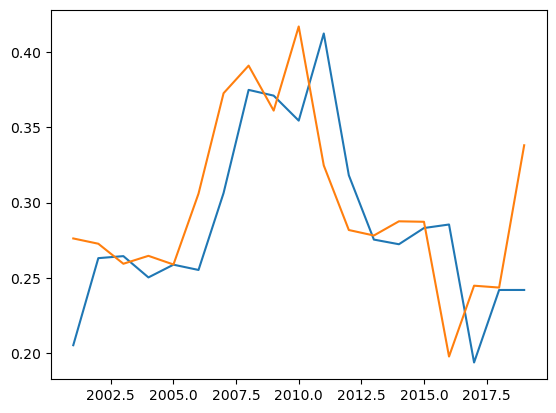

In [19]:
tau_ori_ts_means = {}
for i in range(21):
    tau_ori_ts_means[2000+i]= data_set[data_set['year'] == 2000+i]['tau_target_ori'].mean()
    
tau_hor_ts_means = {}
for i in range(21):
    tau_hor_ts_means[2000+i]= data_set[data_set['year'] == 2000+i]['tau_target_hor'].mean()

display(tau_ori_ts_means)
display(tau_hor_ts_means)
sns.lineplot(data= tau_ori_ts_means)
sns.lineplot(data= tau_hor_ts_means)

## ----------------------------------------

## Handling Wrong Data: Eliminating Incorrect Fiscal Year Dates
* Fiscal Year End Date [ _TR.CompanyFYearEnd_ ] ist compared to actual reported date _[ReportDate]_ of financial figures (features)
* Fiscal Year End Date [ _TR.CompanyFYearEnd_ ] is checked if end of month.   
   
Incorrect samples are deleted from data set.

In [20]:
fy_merged = data_set[['ric', 'date', 'fy_end_date']]
fy_merged.head()

ric                 date fy_end_date
0  A.ITC  2001-10-31 00:00:00  2022-10-31
1  A.ITC  2002-10-31 00:00:00  2022-10-31
2  A.ITC  2003-10-31 00:00:00  2022-10-31
3  A.ITC  2004-10-31 00:00:00  2022-10-31
4  A.ITC  2005-10-31 00:00:00  2022-10-31

In [21]:
date_format = '%Y-%m-%d'

fy_info = pd.DataFrame()

# ---------------- CONFIG ----------------
for i in range(len(fy_merged)):
#for i in range(2000):
    
    try:
        date_formated = datetime.strptime(fy_merged['fy_end_date'][i], date_format)
        
        # sets is_match = True if months are equal or do not differ more than one month
        if (date_formated.month - fy_merged['date'][i].month) == 0:
            is_match = True
        elif abs(date_formated.month - fy_merged['date'][i].month) == 1:
            is_match = True
        elif abs(date_formated.month - fy_merged['date'][i].month) == 11:
            is_match = True
        else:
            is_match = False
        
        # sets is_correct = True if FY end is not end of month
        if date_formated.day > 28:
            is_correct = True
        else:
            is_correct = False
        
        df = pd.DataFrame(
            [[fy_merged['ric'][i],
              date_formated,
              fy_merged['date'][i],
              str(fy_merged['date'][i].year),
              is_match,
              is_correct]],
            columns = ['ric', 'fy_end_date', 'date', 'report_year', 'fy_is_match', 'fy_day_is_correct'])
        
        fy_info = pd.concat([df, fy_info])
        
        
    except AttributeError:
        df = pd.DataFrame([fy_merged['ric'][i]], columns = ['ric'])
        fy_info = pd.concat([df, fy_info])

        pass
    
    
    except TypeError:
        df = pd.DataFrame([fy_merged['ric'][i]], columns = ['ric'])
        fy_info = pd.concat([df, fy_info])
             
        pass

    
# create df with samples with incorrect fy
incorrect_fy = fy_info[fy_info['fy_is_match'] == False].drop_duplicates()
incorrect_fy = incorrect_fy.reset_index(drop=True)

if incorrect_fy.empty == False:
    display('Samples that contain incorrect fiscal year end dates:')
    display(incorrect_fy)
else:
    display('No samples that contain deviations in FY end and reporting day in data set.')

'Samples that contain incorrect fiscal year end dates:'

ric fy_end_date       date report_year  fy_is_match  \
0     ZWS.ITC  2022-12-31 2019-03-31        2019        False   
1     ZWS.ITC  2022-12-31 2018-03-31        2018        False   
2     ZWS.ITC  2022-12-31 2017-03-31        2017        False   
3     ZWS.ITC  2022-12-31 2016-03-31        2016        False   
4     ZWS.ITC  2022-12-31 2015-03-31        2015        False   
5     ZWS.ITC  2022-12-31 2014-03-31        2014        False   
6     ZWS.ITC  2022-12-31 2013-03-31        2013        False   
7     YVR.ITC  2021-11-30 2017-02-28        2017        False   
8     YVR.ITC  2021-11-30 2016-02-29        2016        False   
9     YVR.ITC  2021-11-30 2015-02-28        2015        False   
10    YVR.ITC  2021-11-30 2014-02-28        2014        False   
11    YVR.ITC  2021-11-30 2013-02-28        2013        False   
12    YVR.ITC  2021-11-30 2012-02-29        2012        False   
13    YVR.ITC  2021-11-30 2011-02-28        2011        False   
14    YVR.ITC  2021-11-30 2010-02-28        2010        False   
15    YVR.ITC  2021-11-30 2009-02-28        2009        False   
16    YVR.ITC  2021-11-30 2008-02-29        2008        False   
17    YVR.ITC  2021-11-30 2007-02-28        2007        False   
18    YVR.ITC  2021-11-30 2006-02-28        2006        False   
19    YVR.ITC  2021-11-30 2005-02-28        2005        False   
20    YVR.ITC  2021-11-30 2004-02-29        2004        False   
21    YVR.ITC  2021-11-30 2003-02-28        2003        False   
22    YVR.ITC  2021-11-30 2002-02-28        2002        False   
23    WWE.ITC  2022-12-31 2005-04-30        2005        False   
24    WWE.ITC  2022-12-31 2004-04-30        2004        False   
25    WWE.ITC  2022-12-31 2003-04-30        2003        False   
26    WWE.ITC  2022-12-31 2002-04-30        2002        False   
27   WPRT.ITC  2022-12-31 2010-03-31        2010        False   
28   WPRT.ITC  2022-12-31 2009-03-31        2009        False   
29    WOR.ITC  2023-05-31 2013-12-31        2013        False   
30   VXRT.ITC  2022-12-31 2016-06-30        2016        False   
31   VXRT.ITC  2022-12-31 2015-06-30        2015        False   
32   VXRT.ITC  2022-12-31 2014-06-30        2014        False   
33   VXRT.ITC  2022-12-31 2013-06-30        2013        False   
34   VXRT.ITC  2022-12-31 2012-06-30        2012        False   
35   VTRS.ITC  2022-12-31 2006-03-31        2006        False   
36   VTRS.ITC  2022-12-31 2005-03-31        2005        False   
37   VTRS.ITC  2022-12-31 2004-03-31        2004        False   
38   VTRS.ITC  2022-12-31 2003-03-31        2003        False   
39   VTRS.ITC  2022-12-31 2002-03-31        2002        False   
40   VTOL.ITC  2023-03-31 2019-12-31        2019        False   
41   VTOL.ITC  2023-03-31 2018-12-31        2018        False   
42   VTOL.ITC  2023-03-31 2017-12-31        2017        False   
43   VTOL.ITC  2023-03-31 2016-12-31        2016        False   
44   VTOL.ITC  2023-03-31 2015-12-31        2015        False   
45   VTOL.ITC  2023-03-31 2014-12-31        2014        False   
46    VFC.ITC  2023-03-31 2017-12-30        2017        False   
47    VFC.ITC  2023-03-31 2016-01-02        2016        False   
48    VFC.ITC  2023-03-31 2016-12-31        2016        False   
49    VFC.ITC  2023-03-31 2015-01-03        2015        False   
50    VFC.ITC  2023-03-31 2012-12-29        2012        False   
51    VFC.ITC  2023-03-31 2011-01-01        2011        False   
52    VFC.ITC  2023-03-31 2011-12-31        2011        False   
53    VFC.ITC  2023-03-31 2010-01-02        2010        False   
54    VFC.ITC  2023-03-31 2009-01-03        2009        False   
55    VFC.ITC  2023-03-31 2006-12-30        2006        False   
56    VFC.ITC  2023-03-31 2005-01-01        2005        False   
57    VFC.ITC  2023-03-31 2005-12-31        2005        False   
58    VFC.ITC  2023-03-31 2004-01-03        2004        False   
59    VFC.ITC  2023-03-31 2003-01-04        2003        False   
60    VEV.ITC  2022-12-31 2015-08-31        2

In [22]:
# eleminate incorrect fy from data_set
cleaned_df = data_set.copy()
for i in range(len(incorrect_fy)):

    ric = str(incorrect_fy.ric[i])
    date = incorrect_fy.date[i]

    idx = np.where((data_set['ric'] == ric) & (data_set['date'] == date))
    cleaned_df = cleaned_df.drop(idx[0])

print(str(len(data_set)) + ' samples before')
print(str(len(cleaned_df)) + ' samples after')

data_set = cleaned_df.copy()

40660 samples before
39796 samples after


## ----------------------------------------
## Elimination of Features with too Much Missing Data
Features with too much missing data are deleted from data_set (missing rate treshhold according to literature).

In [23]:
missing_rate_treshhold = 0.2

In [24]:
missing_data_features = {'feature':[], 'missing_rate':[]}

for i in data_set:
    missing_rate = data_set[i].isna().sum() / len(data_set[i])
    
    if missing_rate > missing_rate_treshhold:
        missing_data_features['feature'].append(i)
        missing_data_features['missing_rate'].append(missing_rate)
    
missing_data_features = pd.DataFrame(missing_data_features)
missing_data_features = pd.merge(missing_data_features, mapping)
missing_data_features

feature  missing_rate                  eikon_code  \
0       invst      0.405443               TR.F.InvstTot   
1         cor      0.232511                TR.F.COGSTot   
2  compincbmi      0.569831  TR.F.ComprIncBefMinIntrTot   
3          qr      0.396698             TR.F.QuickRatio   
4       oplev      0.911599                  TR.F.OpLev   
5         rnd      0.617374  TR.F.RnDExclCapRnDPctofRev   
6        wacc      0.662303                     TR.WACC   
7      comeps      0.573123     TR.F.ComprEPSBasicIssue   
8       divpo      0.278747      TR.F.DivPayoutRatioPct   

                                                 description  
0                                        Investments - Total  
1                                   Cost of Revenues - Total  
2      Comprehensive Income before Minority Interest - Total  
3                                                Quick Ratio  
4                                         Operating Leverage  
5                       R&D Expn Percentage of Total Revenue  
6                      Weighted Average Cost of Capital, (%)  
7  Comprehensive Earnings Per Share - Basic - Issue Specific  
8                                  Dividend Payout Ratio - %

In [25]:
data_set = data_set.drop(missing_data_features.feature.values, axis = 1)
print('Deletion of ' + str(len(missing_data_features)) + ' features with more than ' + str(int(missing_rate_treshhold * 100)) + '% missing data')

Deletion of 9 features with more than 20% missing data


## ----------------------------------------
## Handling Missing Data by Imputation
* mean
* IterativeImputer https://scikit-learn.org/stable/modules/impute.html
* Time Series https://www.kaggle.com/code/parulpandey/a-guide-to-handling-missing-values-in-python

* Lin Reg Model analyticsvidhya.com/blog/2021/05/dealing-with-missing-values-in-python-a-complete-guide/
* Deterministic Regression Imputation https://www.kaggle.com/code/shashankasubrahmanya/missing-data-imputation-using-regression/notebook
* Stochastic Regression Imputation https://www.kaggle.com/code/shashankasubrahmanya/missing-data-imputation-using-regression/notebook

In [26]:
# handling shouts column
#'Unable to collect data for the field \'TR.SharesOutstanding \' and some specific identifier(s).'
data_set = data_set[data_set.shouts.apply(lambda x: not isinstance(x, str))]
data_set['shouts'] = data_set['shouts'].astype(float)

### Categorial: Imputation by Most Frequent (MODE)

In [27]:
# percentage of missing values
print(data_set['naics'].isnull().mean())

0.0006533648288686737


In [28]:
data_set['naics'] = data_set['naics'].replace('Admin., Support, Waste Management and Remediation Services', 'Admin., Support, Waste Mgmnt., Remediation Serv')

In [29]:
data_set['naics'].unique()

array(['Manufacturing', 'Finance and Insurance',
       'Transportation and Warehousing', 'Retail Trade',
       'Real Estate and Rental and Leasing',
       'Mining, Quarrying, and Oil and Gas Extraction', 'Wholesale Trade',
       'Professional, Scientific, and Technical Services',
       'Administrative and Support and Waste Management and Remediation Services',
       'Construction', 'Health Care and Social Assistance', 'Information',
       'Utilities', 'Agriculture, Forestry, Fishing and Hunting',
       'Accommodation and Food Services', 'Educational Services',
       'Other Services (except Public Administration)',
       'Arts, Entertainment, and Recreation', nan,
       'Public Administration'], dtype=object)

Text(0, 0.5, 'Number of observations')

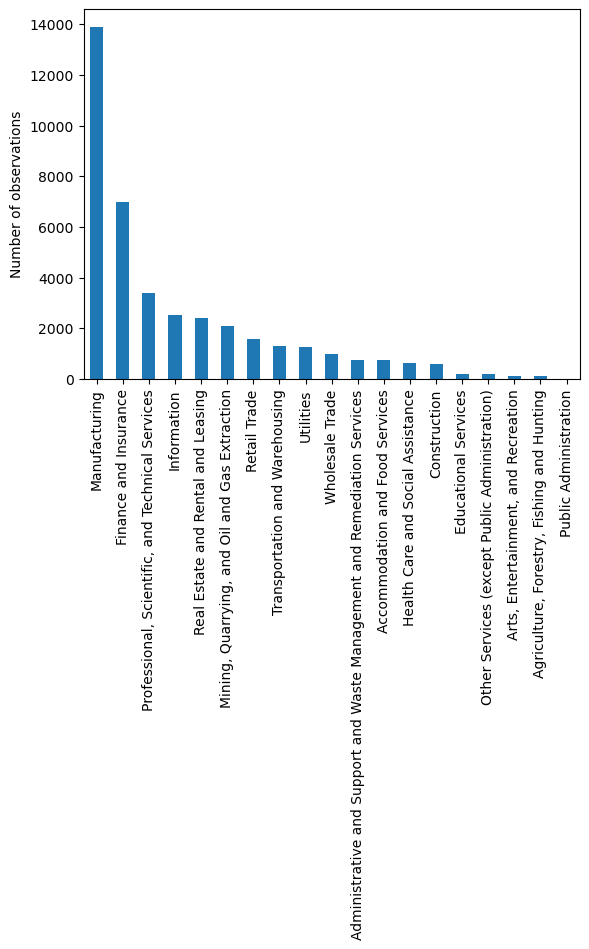

In [30]:
# number of observations per category
data_set['naics'].value_counts().sort_values(ascending=False).plot.bar()
plt.ylabel('Number of observations')

In [31]:
# most frequent category 
data_set['naics'].mode()

0    Manufacturing
Name: naics, dtype: object

Text(0.5, 1.0, 'NAICS')

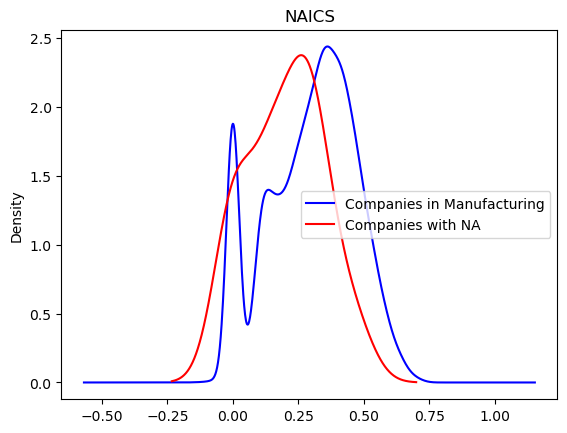

In [32]:
# plotting the distribution of target variable with respect to NAICS
fig = plt.figure()
ax = fig.add_subplot(111)

# select and plot naics with the most frequent label
data_set[data_set['naics'] == 'Manufacturing']['tau_target_hor'].plot(kind='kde', ax=ax, color='blue')
# select and plot naics with missing data in the variable
data_set[data_set['naics'].isnull()]['tau_target_hor'].plot(kind='kde', ax=ax, color='red')

lines, labels = ax.get_legend_handles_labels()
labels = ['Companies in Manufacturing', 'Companies with NA']
ax.legend(lines, labels, loc='best')

# add figure title
plt.title('NAICS')

In [33]:
data_set_before = data_set.copy()
data_set['naics'].fillna('Manufacturing', inplace=True)
# percentage of missing values in each variable
data_set['naics'].isnull().mean()

0.0

Text(0.5, 1.0, 'NAICS')

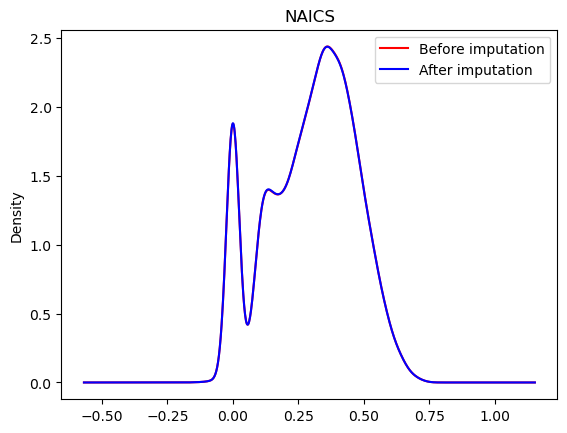

In [34]:
# plotting the distribution of target variable with respect to NAICS
fig = plt.figure()
ax = fig.add_subplot(111)

# select and plot naics with the most frequent label before imputation
data_set_before[data_set_before['naics'] == 'Manufacturing']['tau_target_hor'].plot(kind='kde', ax=ax, color='red')
# select and plot naics with the most frequent label after imputation
data_set[data_set['naics'] == 'Manufacturing']['tau_target_hor'].plot(kind='kde', ax=ax, color='blue')

lines, labels = ax.get_legend_handles_labels()
labels = ['Before imputation', 'After imputation']
ax.legend(lines, labels, loc='best')

# add figure title
plt.title('NAICS')

In [35]:
print(len(data_set_before[data_set_before['naics'] == 'Manufacturing'])/len(data_set_before))
print(len(data_set[data_set['naics'] == 'Manufacturing'])/len(data_set))

0.34907272453133636
0.34972608936020505


### Numerical: Nearest neighbors imputation

In [36]:
imp_features = data_set[['debt', 'tass', 'rtass', 'tlia',
       'tsheq', 'comeq', 'comsi', 'noa', 'wc', 'ndebt', 'capex', 'ncfo',
       'levfcf', 'nincam', 'gp', 'trev', 'ebit', 'roe', 'roce', 'rnoa',
       'ebitmarg', 'shouts', 'mc', 'ptbvps', 'oips', 'cfps', 'ros_c', 'prof_c',
       'finlev_c', 'inc_days', 'ipo_days']].copy(deep=True)

knnimputer = KNNImputer(n_neighbors=3)

imp_features.iloc[:,:] = knnimputer.fit_transform(imp_features)

In [37]:
data_set = data_set.drop(columns=['debt', 'tass', 'rtass', 'tlia',
       'tsheq', 'comeq', 'comsi', 'noa', 'wc', 'ndebt', 'capex', 'ncfo',
       'levfcf', 'nincam', 'gp', 'trev', 'ebit', 'roe', 'roce', 'rnoa',
       'ebitmarg', 'shouts', 'mc', 'ptbvps', 'oips', 'cfps', 'ros_c', 'prof_c',
       'finlev_c', 'inc_days', 'ipo_days'])

list = ['debt', 'tass', 'rtass', 'tlia',
       'tsheq', 'comeq', 'comsi', 'noa', 'wc', 'ndebt', 'capex', 'ncfo',
       'levfcf', 'nincam', 'gp', 'trev', 'ebit', 'roe', 'roce', 'rnoa',
       'ebitmarg', 'shouts', 'mc', 'ptbvps', 'oips', 'cfps', 'ros_c', 'prof_c',
       'finlev_c', 'inc_days', 'ipo_days']

for feature in list:
    data_set[feature] = imp_features[feature]
    
data_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39794 entries, 0 to 40659
Data columns (total 49 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ric             39794 non-null  object 
 1   year            39794 non-null  int64  
 2   date            39794 non-null  object 
 3   isin            39794 non-null  object 
 4   symbol          39794 non-null  object 
 5   naics           39794 non-null  object 
 6   fy_end_date     39794 non-null  object 
 7   tau_cop_3y      39794 non-null  float64
 8   tau_cop_5y      39794 non-null  float64
 9   fam_target_ori  39794 non-null  object 
 10  rot_target_ori  39794 non-null  int64  
 11  tau_target_ori  39794 non-null  float64
 12  par_target_ori  39794 non-null  object 
 13  year_hor        39794 non-null  int64  
 14  tau_target_hor  39794 non-null  float64
 15  fam_target_hor  39794 non-null  object 
 16  rot_target_hor  39794 non-null  int64  
 17  par_target_hor  39794 non-null 

## ----------------------------------------
## Handling Outliers / Noise Reduction

In [38]:
data_set_indexed = data_set.set_index(['ric', 'year'])
data_set_indexed.head()

date          isin symbol          naics  \
ric   year                                                            
A.ITC 2001  2001-10-31 00:00:00  US00846U1016      A  Manufacturing   
      2002  2002-10-31 00:00:00  US00846U1016      A  Manufacturing   
      2003  2003-10-31 00:00:00  US00846U1016      A  Manufacturing   
      2004  2004-10-31 00:00:00  US00846U1016      A  Manufacturing   
      2005  2005-10-31 00:00:00  US00846U1016      A  Manufacturing   

           fy_end_date  tau_cop_3y  tau_cop_5y fam_target_ori  rot_target_ori  \
ric   year                                                                      
A.ITC 2001  2022-10-31    0.344151    0.344151       gaussian               0   
      2002  2022-10-31    0.391592    0.391592          frank               0   
      2003  2022-10-31    0.471121    0.417179         gumbel             180   
      2004  2022-10-31    0.485946    0.425203          frank               0   
      2005  2022-10-31    0.451243    0.457525          frank               0   

            tau_target_ori  par_target_ori  year_hor  tau_target_hor  \
ric   year                                                             
A.ITC 2001        0.458727  [[0.65981076]]      2002        0.499681   
      2002        0.499681  [[5.73048141]]      2003        0.505513   
      2003        0.505513  [[2.02229729]]      2004        0.462612   
      2004        0.462612  [[5.09499262]]      2005        0.371968   
      2005        0.371968  [[3.78686423]]      2006        0.384465   

           fam_target_hor  rot_target_hor  par_target_hor          debt  \
ric   year                                                                
A.ITC 2001          frank               0  [[5.73048141]]  8.000000e+06   
      2002         gumbel             180  [[2.02229729]]  1.150000e+09   
      2003          frank               0  [[5.09499262]]  1.150000e+09   
      2004          frank               0  [[3.78686423]]  1.150000e+09   
      2005       gaussian               0  [[0.56787014]]  0.000000e+00   

                    tass      rtass          tlia         tsheq         comeq  \
ric   year                                                                      
A.ITC 2001  7.986000e+09  -3.579309  2.327000e+09  5.659000e+09  5.659000e+09   
      2002  8.203000e+09 -12.625857  3.576000e+09  4.627000e+09  4.627000e+09   
      2003  6.297000e+09 -24.510345  3.473000e+09  2.824000e+09  2.824000e+09   
      2004  7.144000e+09   0.877911  3.575000e+09  3.569000e+09  3.569000e+09   
      2005  6.751000e+09   2.749190  2.670000e+09  4.081000e+09  4.081000e+09   

                  comsi           noa            wc         ndebt  \
ric   year                                                          
A.ITC 2001  461030000.0  4.497000e+09  2.797000e+09 -1.162000e+09   
      2002  467000000.0  3.933000e+09  2.899000e+09 -6.940000e+08   
      2003  476000000.0  2.367000e+09  1.983000e+09 -4.570000e+08   
      2004  487000000.0  2.404000e+09  2.891000e+09 -1.165000e+09   
      2005  512000000.0  1.830000e+09  2.511000e+09 -2.251000e+09   

                  capex          ncfo       levfcf        nincam  \
ric   year                                                         
A.ITC 2001  881000000.0  1.502000e+09  621000000.0  3.600000e+08   
      2002  301000000.0 -5.040000e+08 -805000000.0 -1.032000e+09   
      2003  171000000.0 -1.580000e+08 -329000000.0 -1.790000e+09   
      2004   79000000.0  6.700000e+08  591000000.0  3.690000e+08   
      2005  128000000.0  8.990000e+08  771000000.0  3.270000e+08   

                      gp          trev          ebit        roe       roce  \
ric   year                                                                   
A.ITC 2001  3.308000e+09  8.396000e+09 -7.030000e+08  -5.346027 -12.067634   
      2002  2.144000e+09  6.010000e+09 -1.343000e+09 -19.871670 -22.005571   
      2003  1.835000e+09  4.468000e+09 -7.200000e+08 -47.698296 -13.568265   
      2004 

In [39]:
features = ['tau_target_ori', 'debt', 'tass', 'rtass', 'tlia', 'tsheq', 'comeq', 'comsi', 'noa', 'wc', 'ndebt',
            'capex', 'ncfo', 'levfcf', 'nincam', 'gp', 'trev', 'ebit', 'roe', 'roce', 'rnoa', 'ebitmarg',
            'shouts', 'mc', 'ptbvps', 'oips', 'cfps', 'ros_c', 'prof_c', 'finlev_c', 'inc_days', 'ipo_days',
            'tau_cop_3y', 'tau_cop_5y']

### Histograms, density functions, boxplots and percentile plots

### tau_target_ori

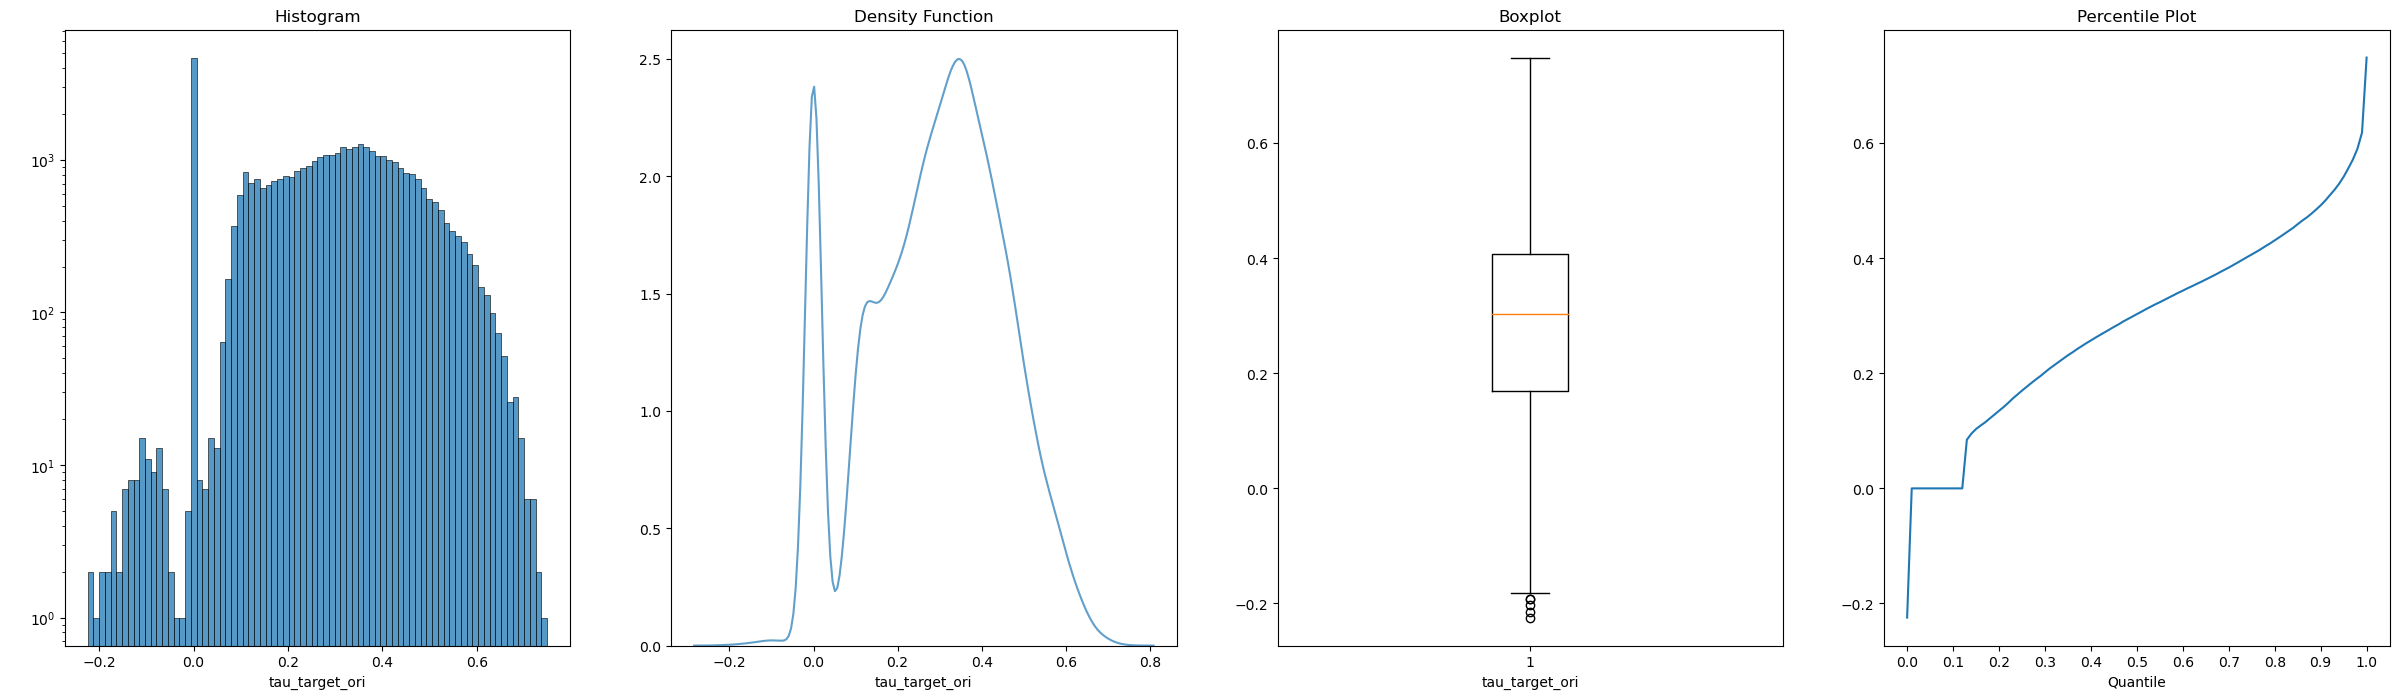

### debt

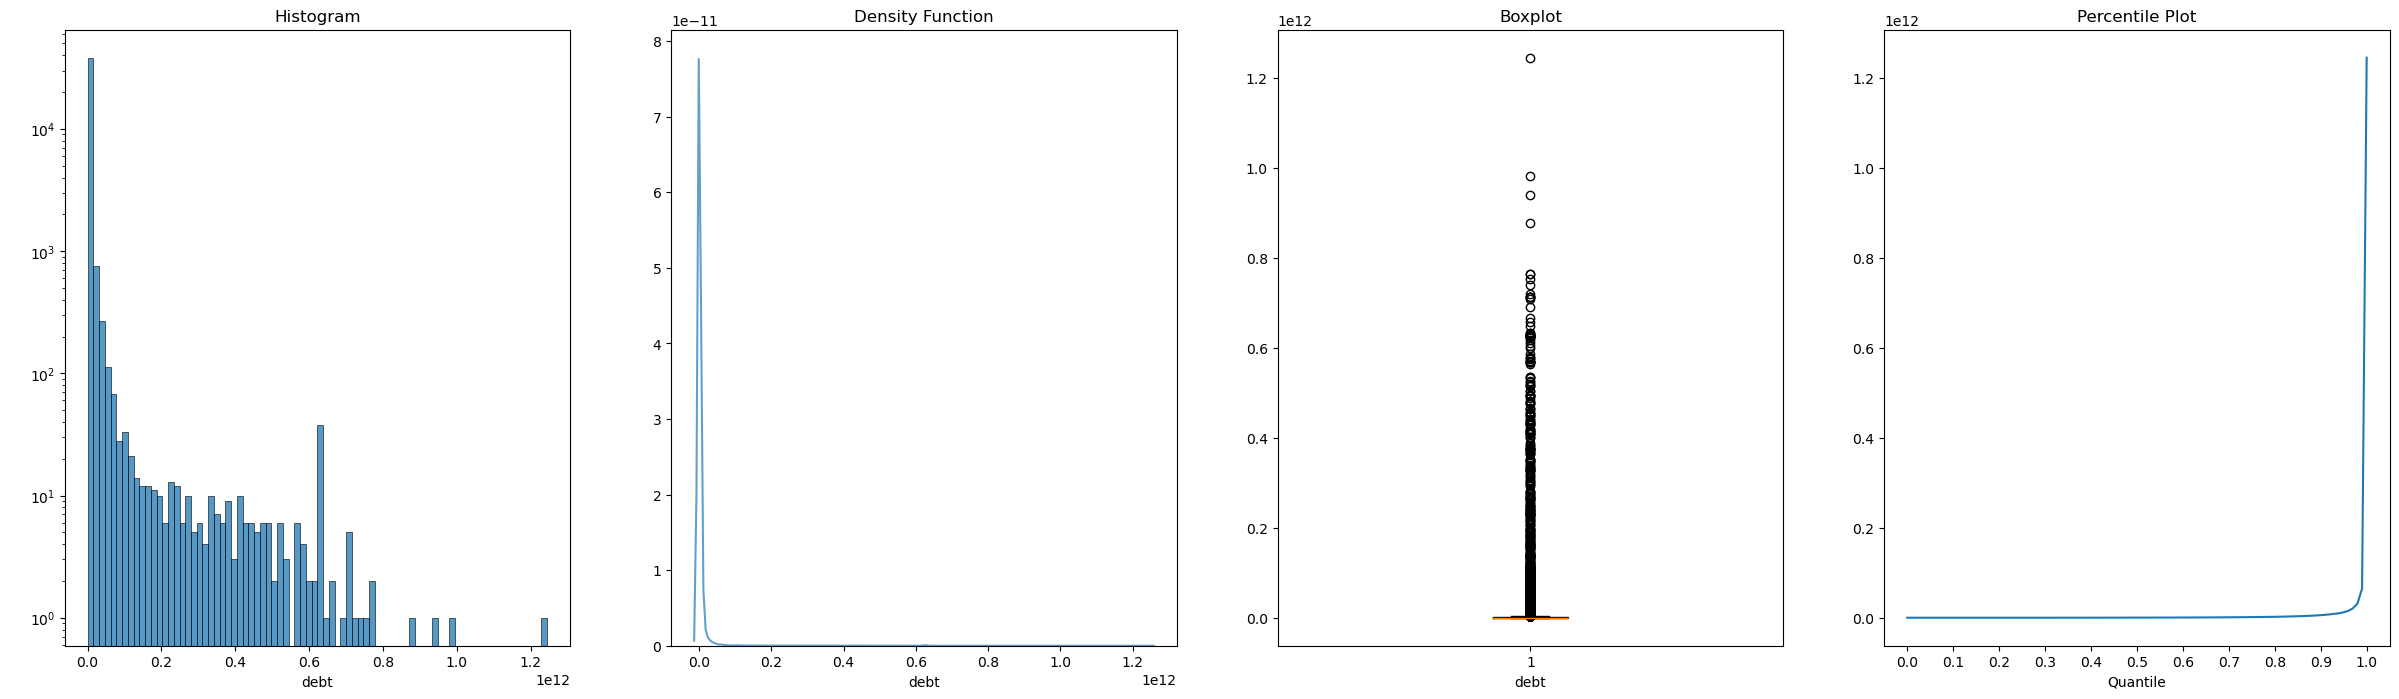

### tass

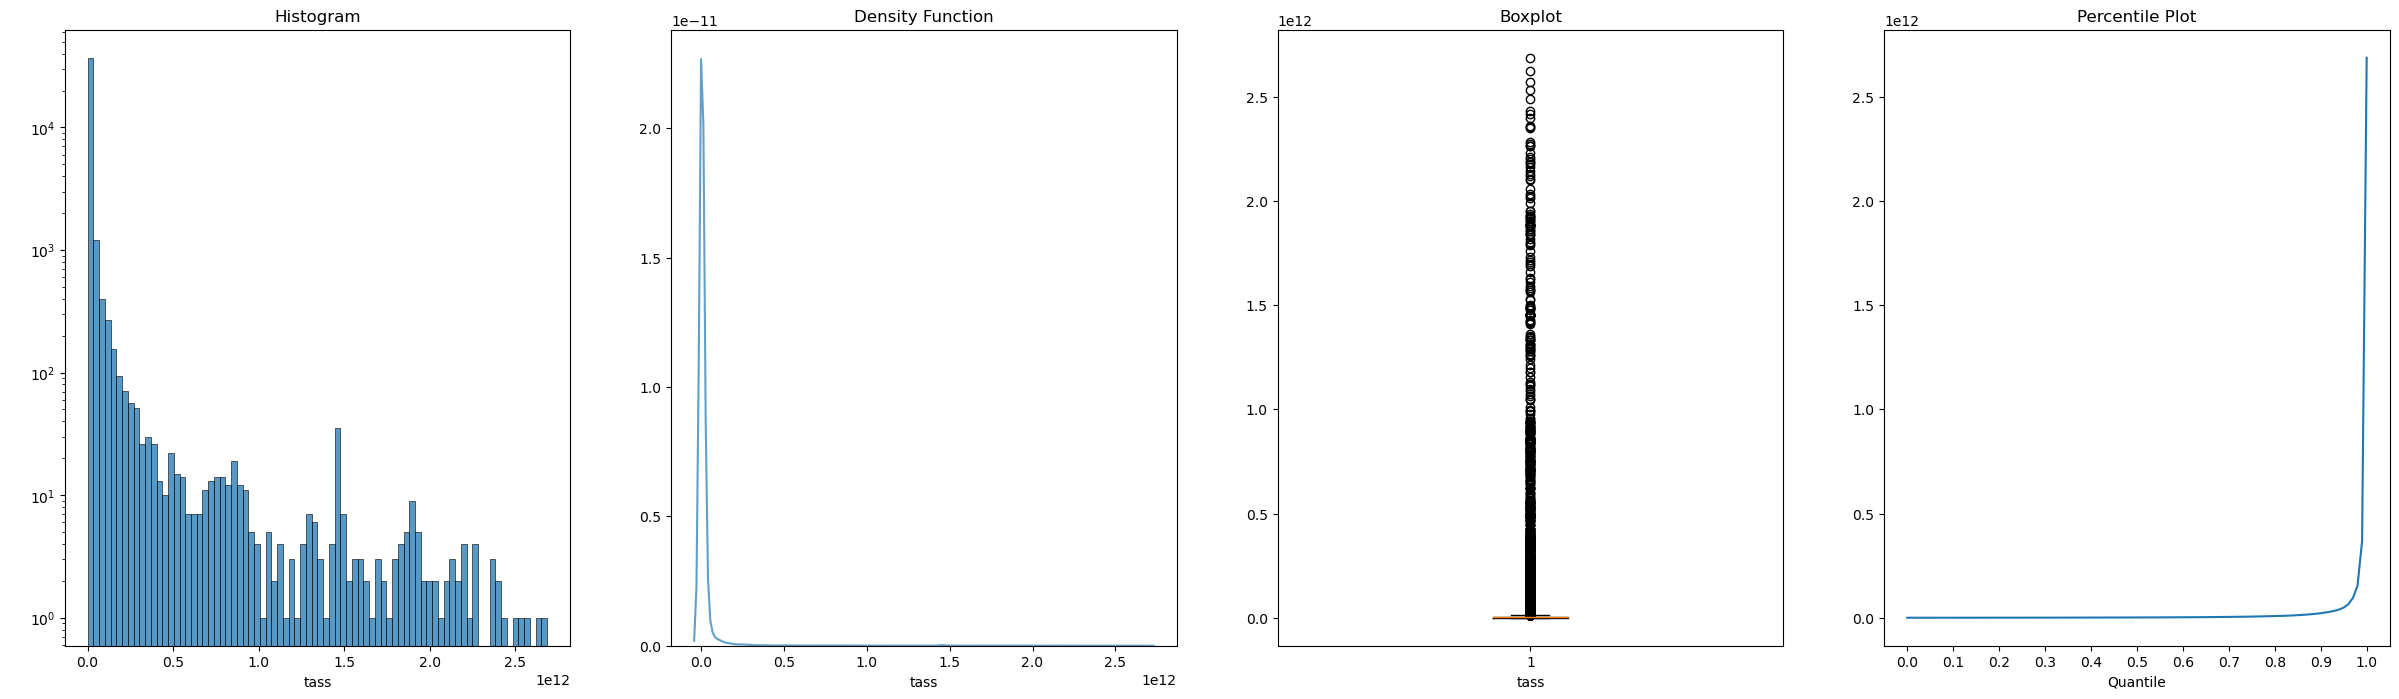

### rtass

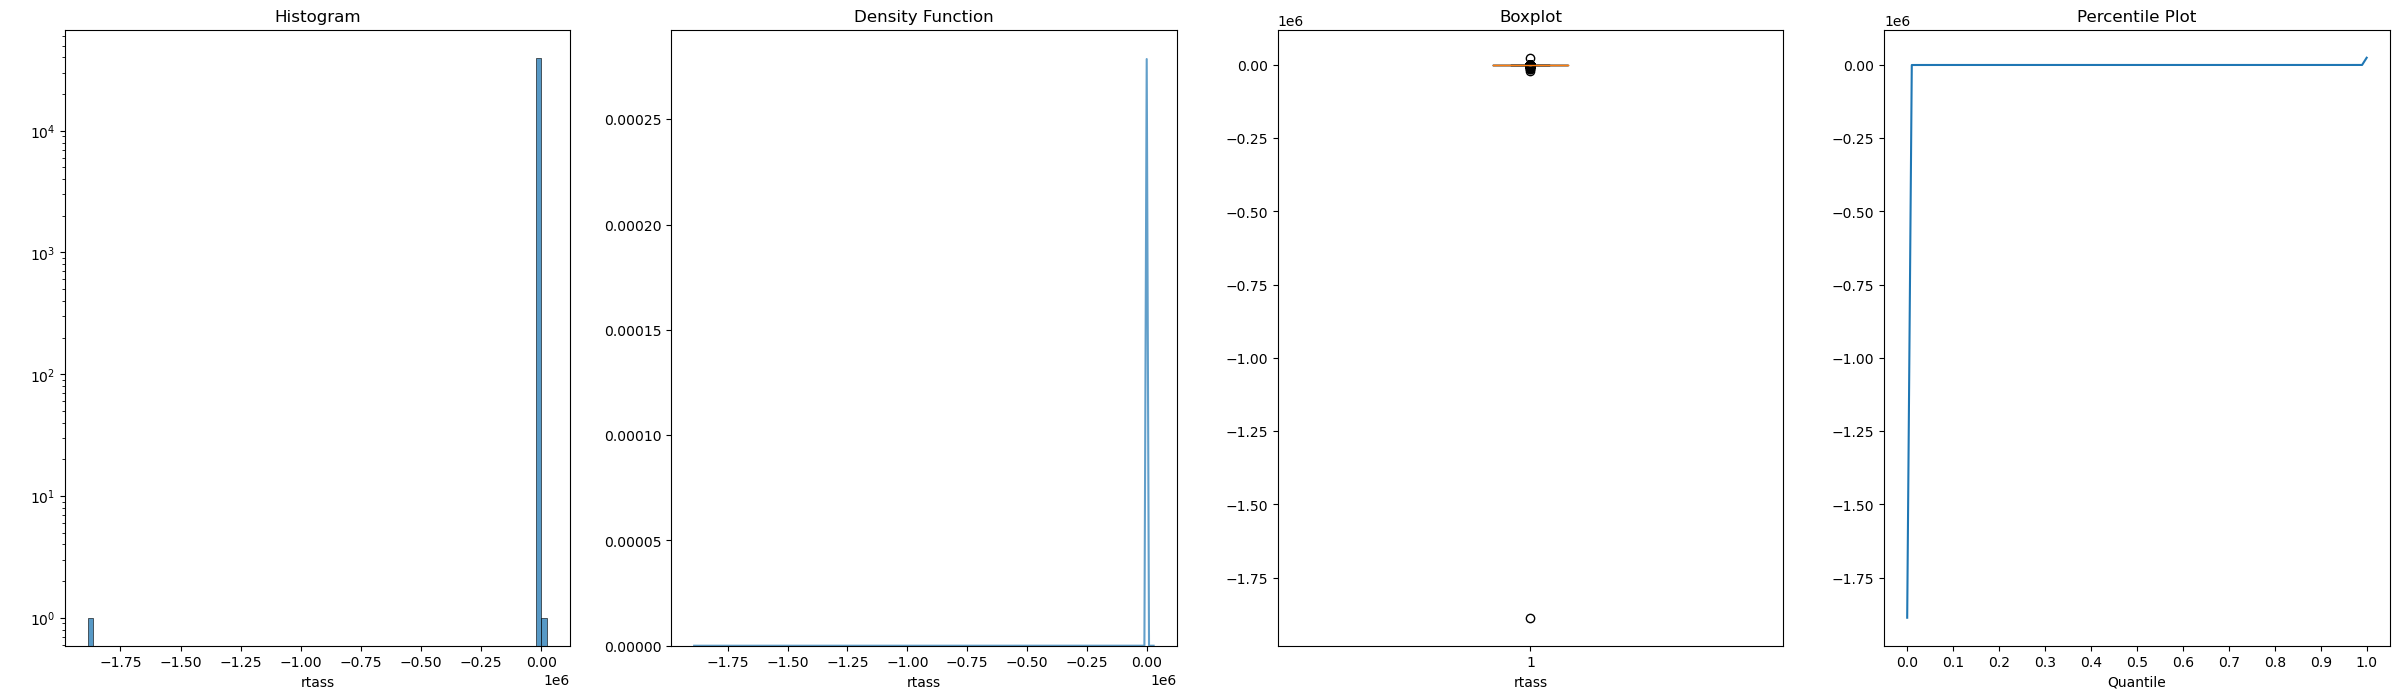

### tlia

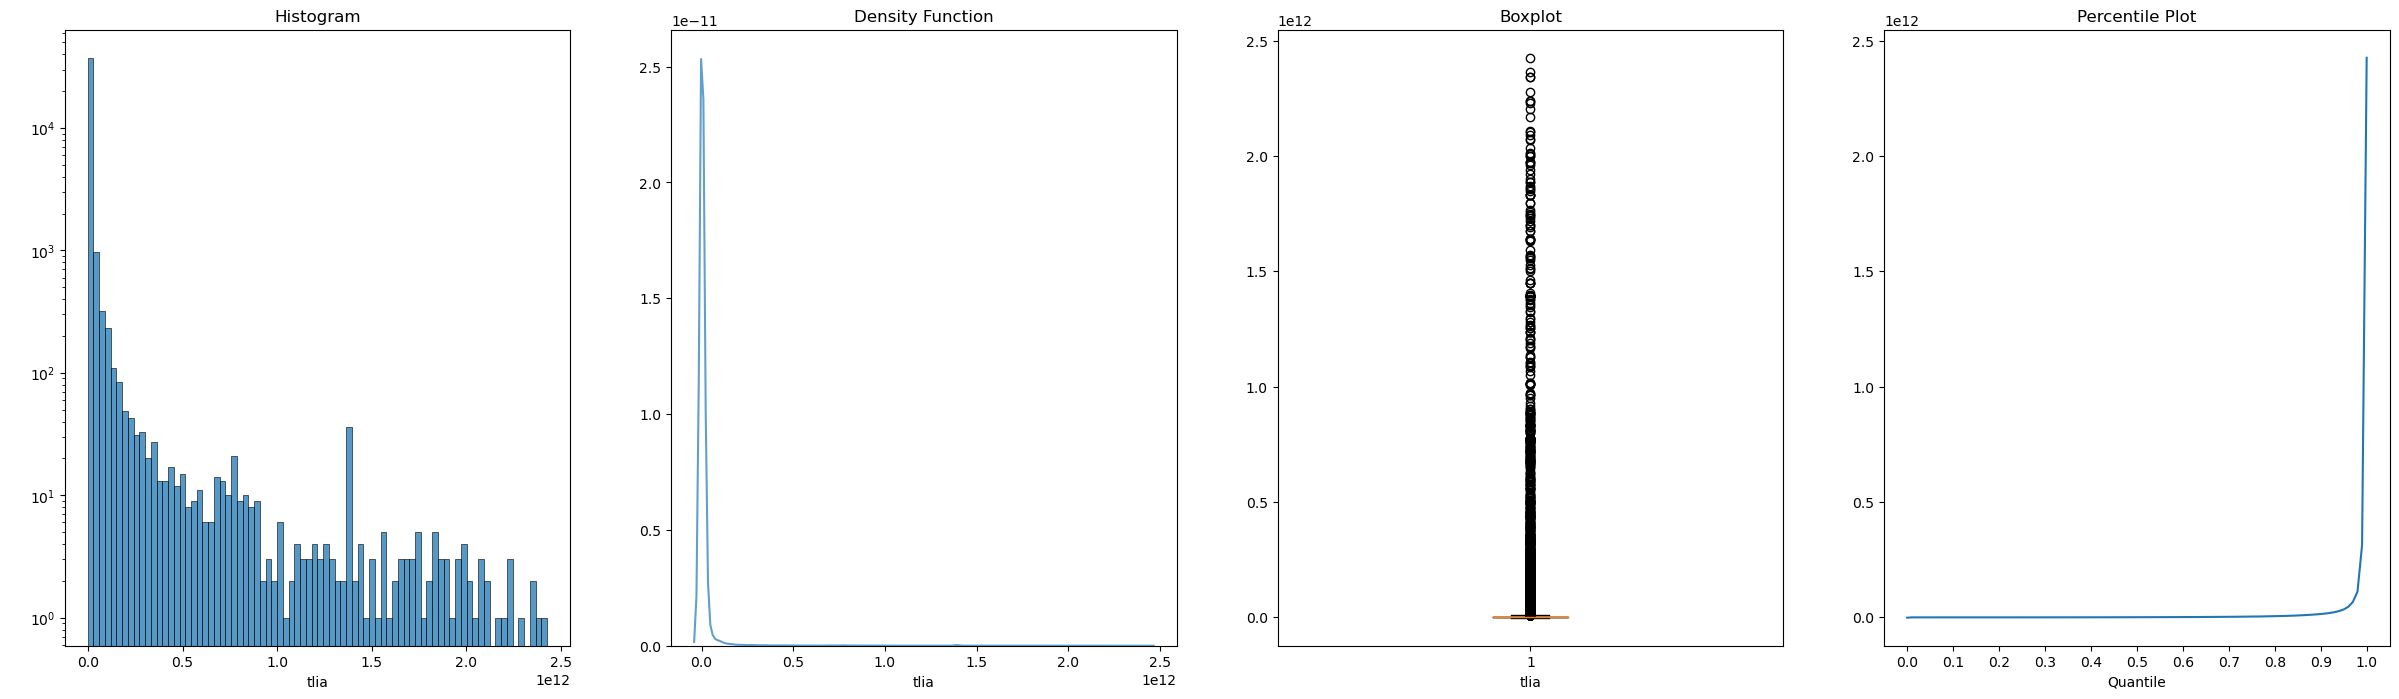

### tsheq

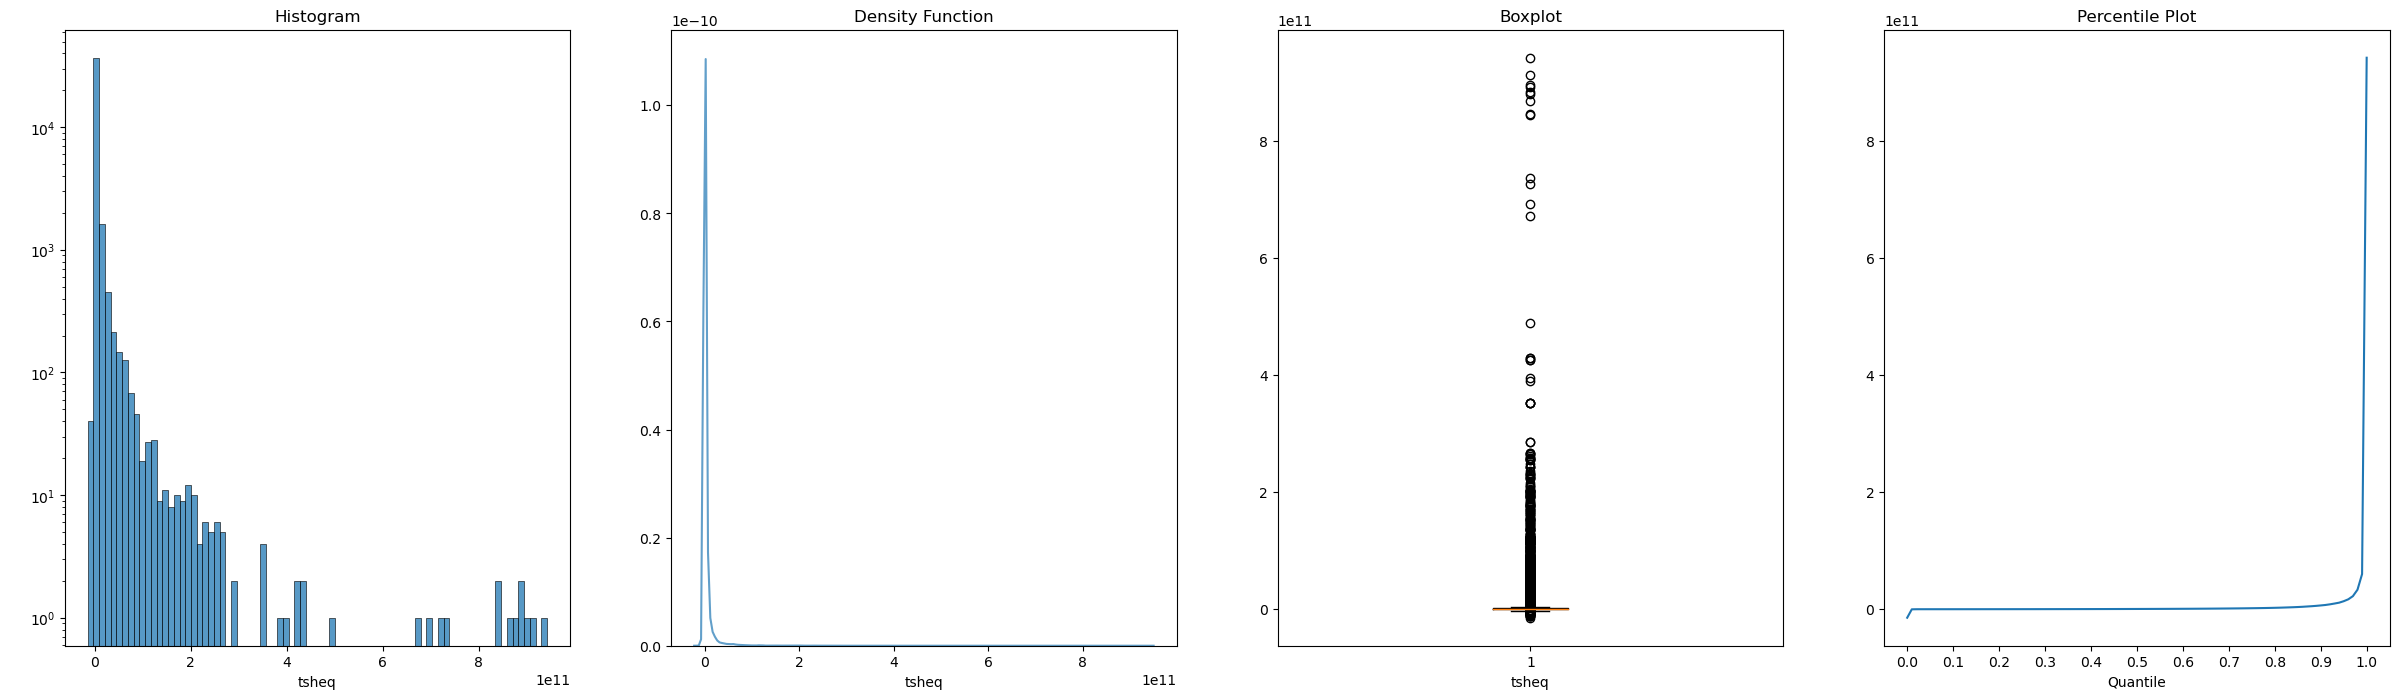

### comeq

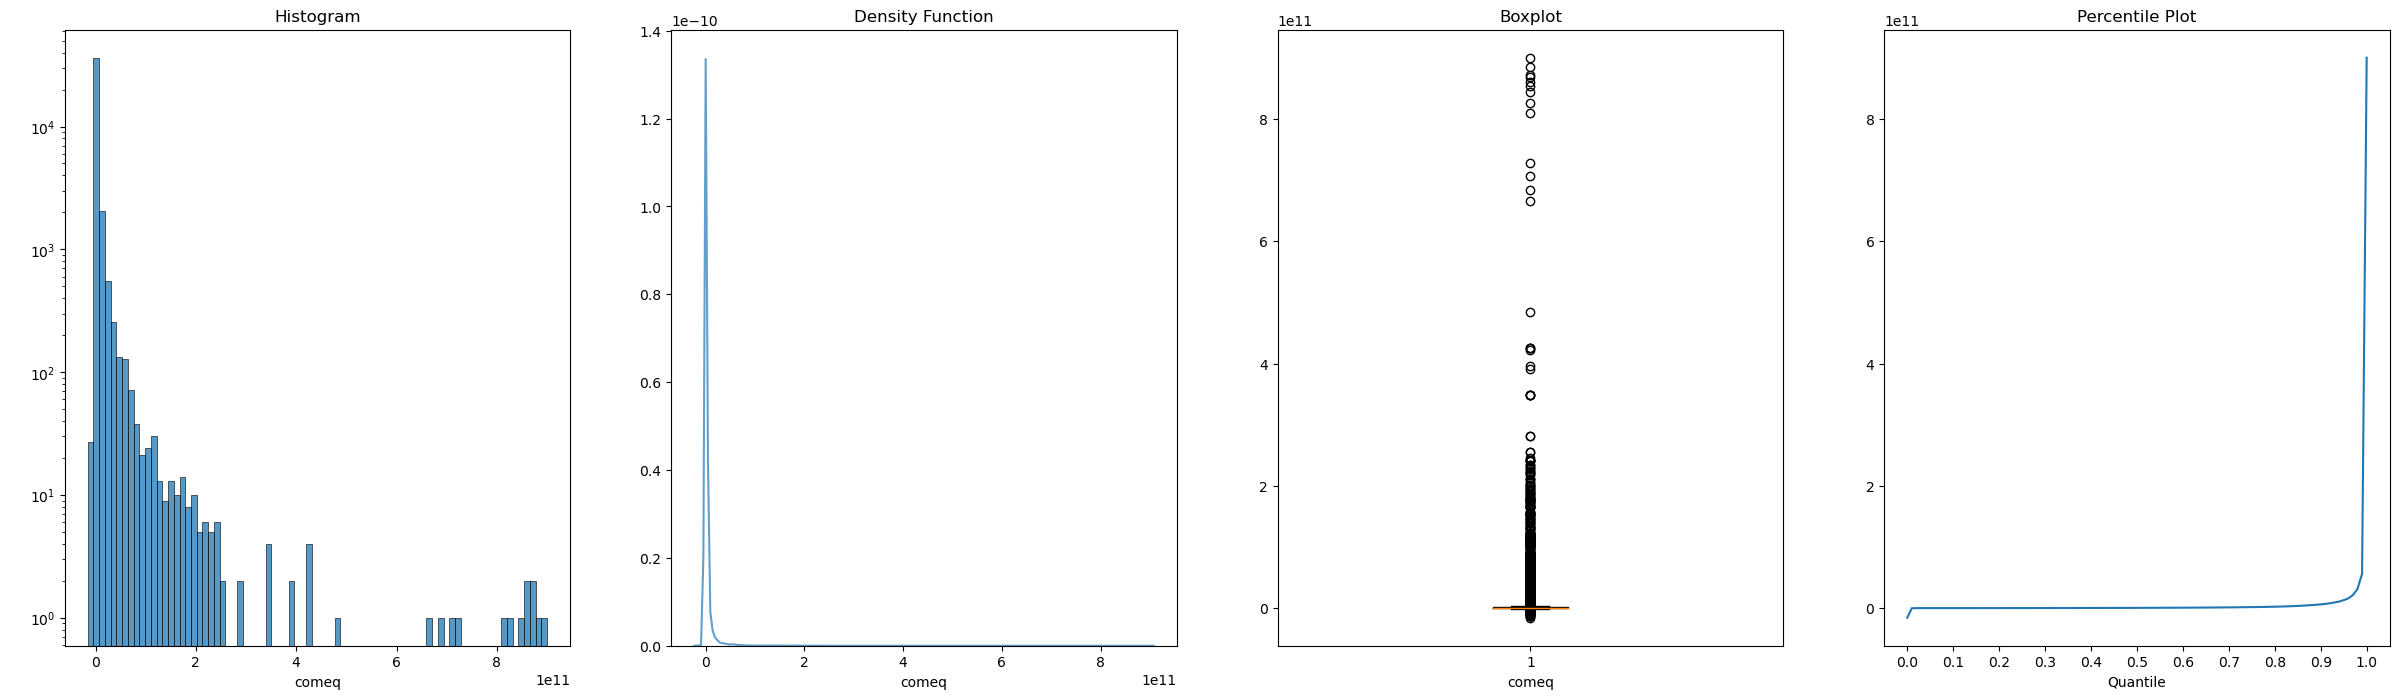

### comsi

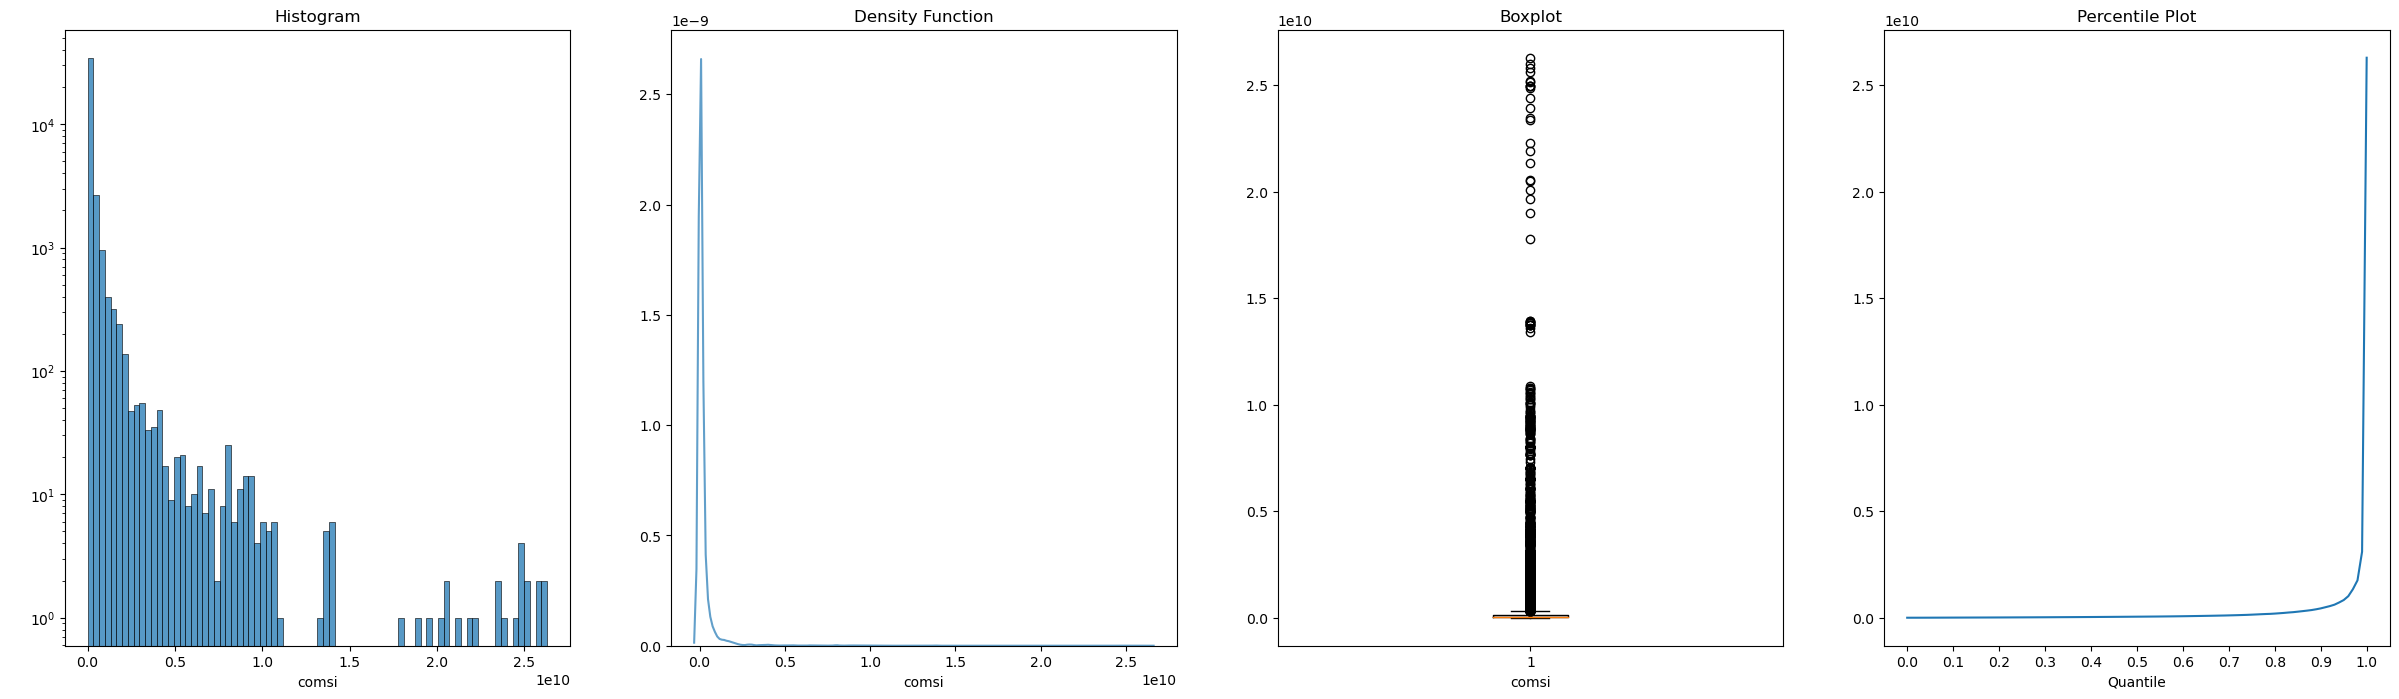

### noa

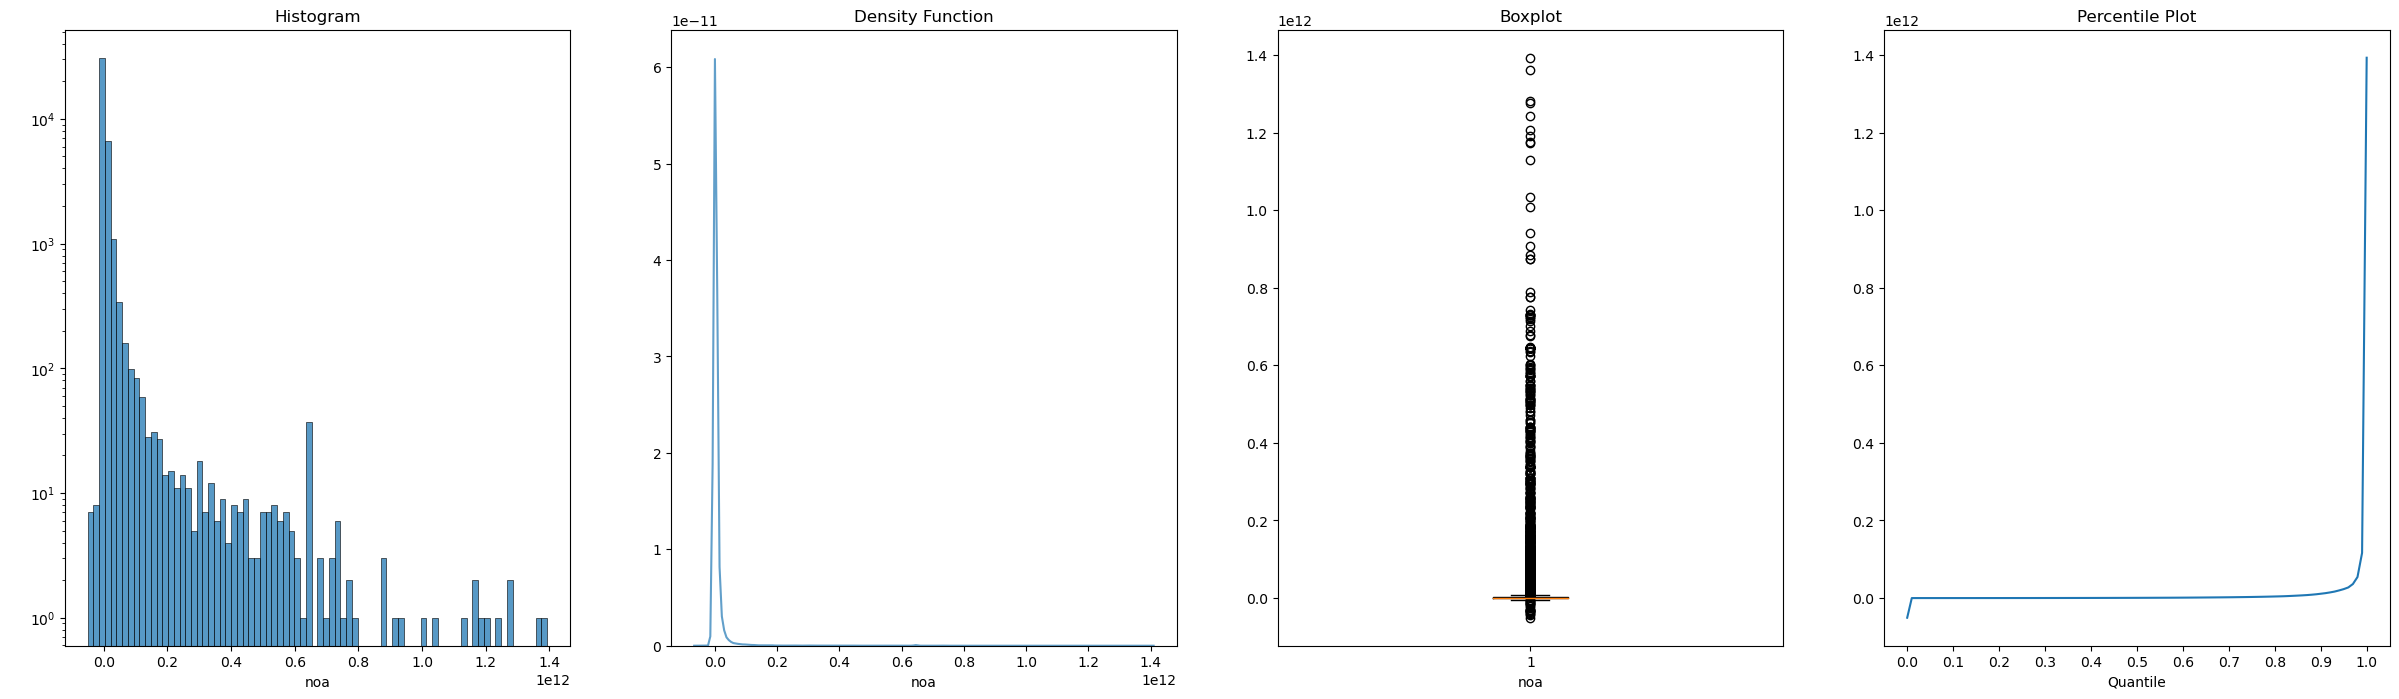

### wc

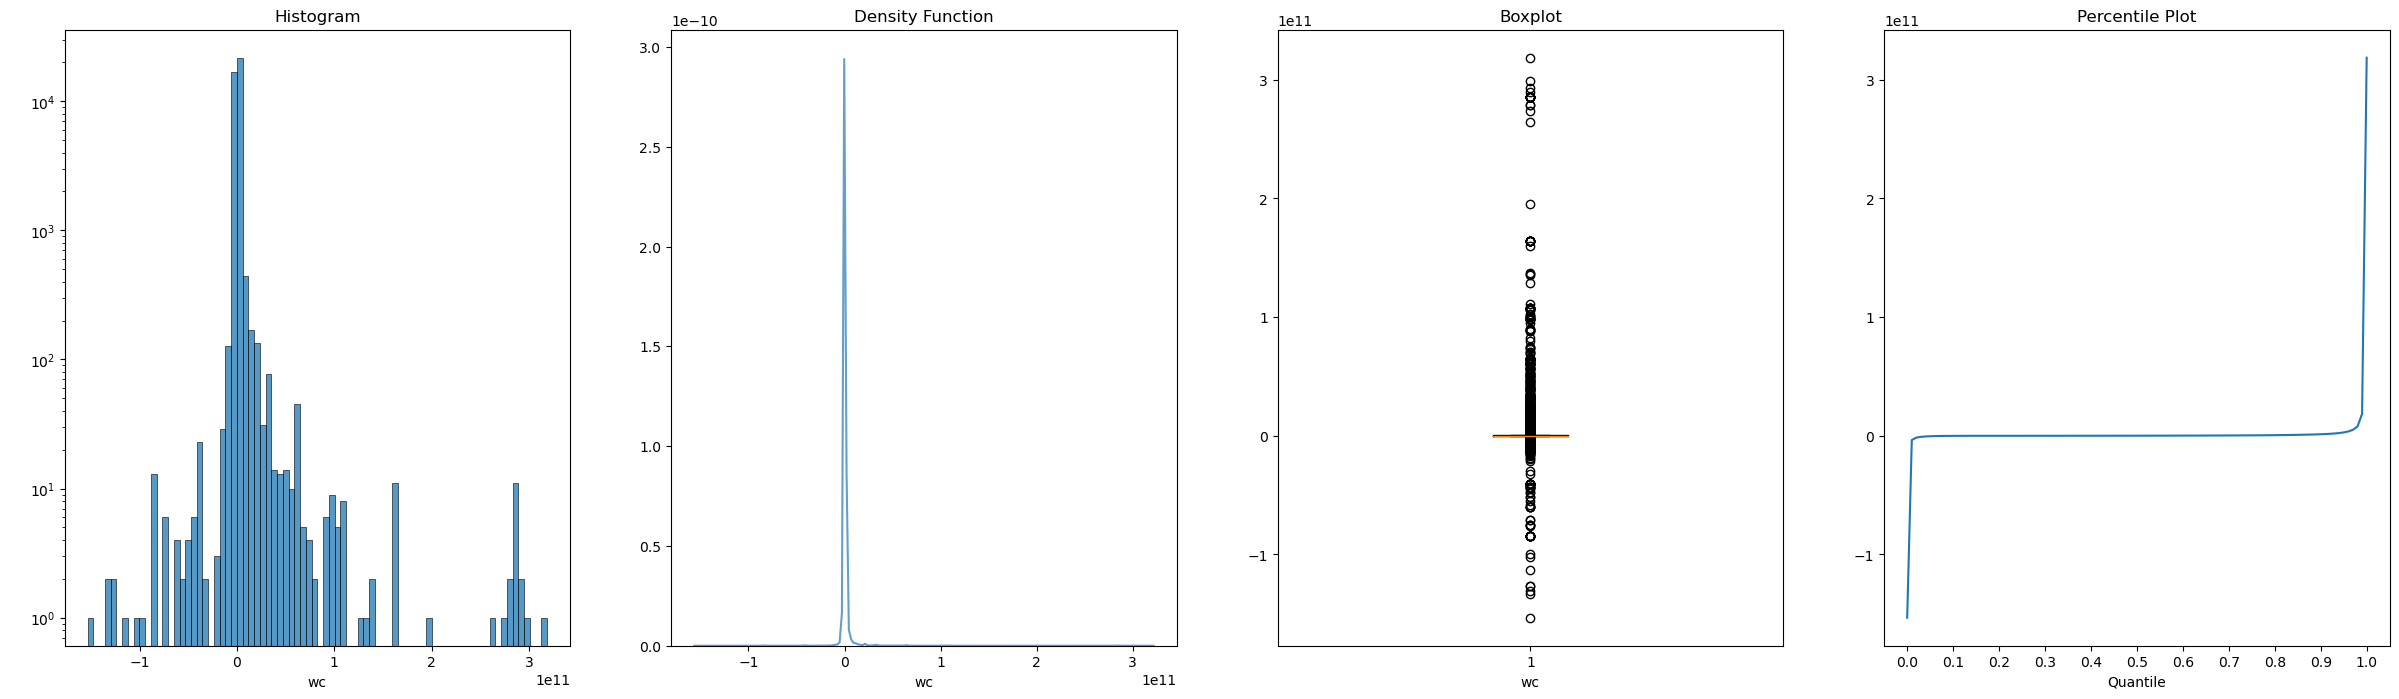

### ndebt

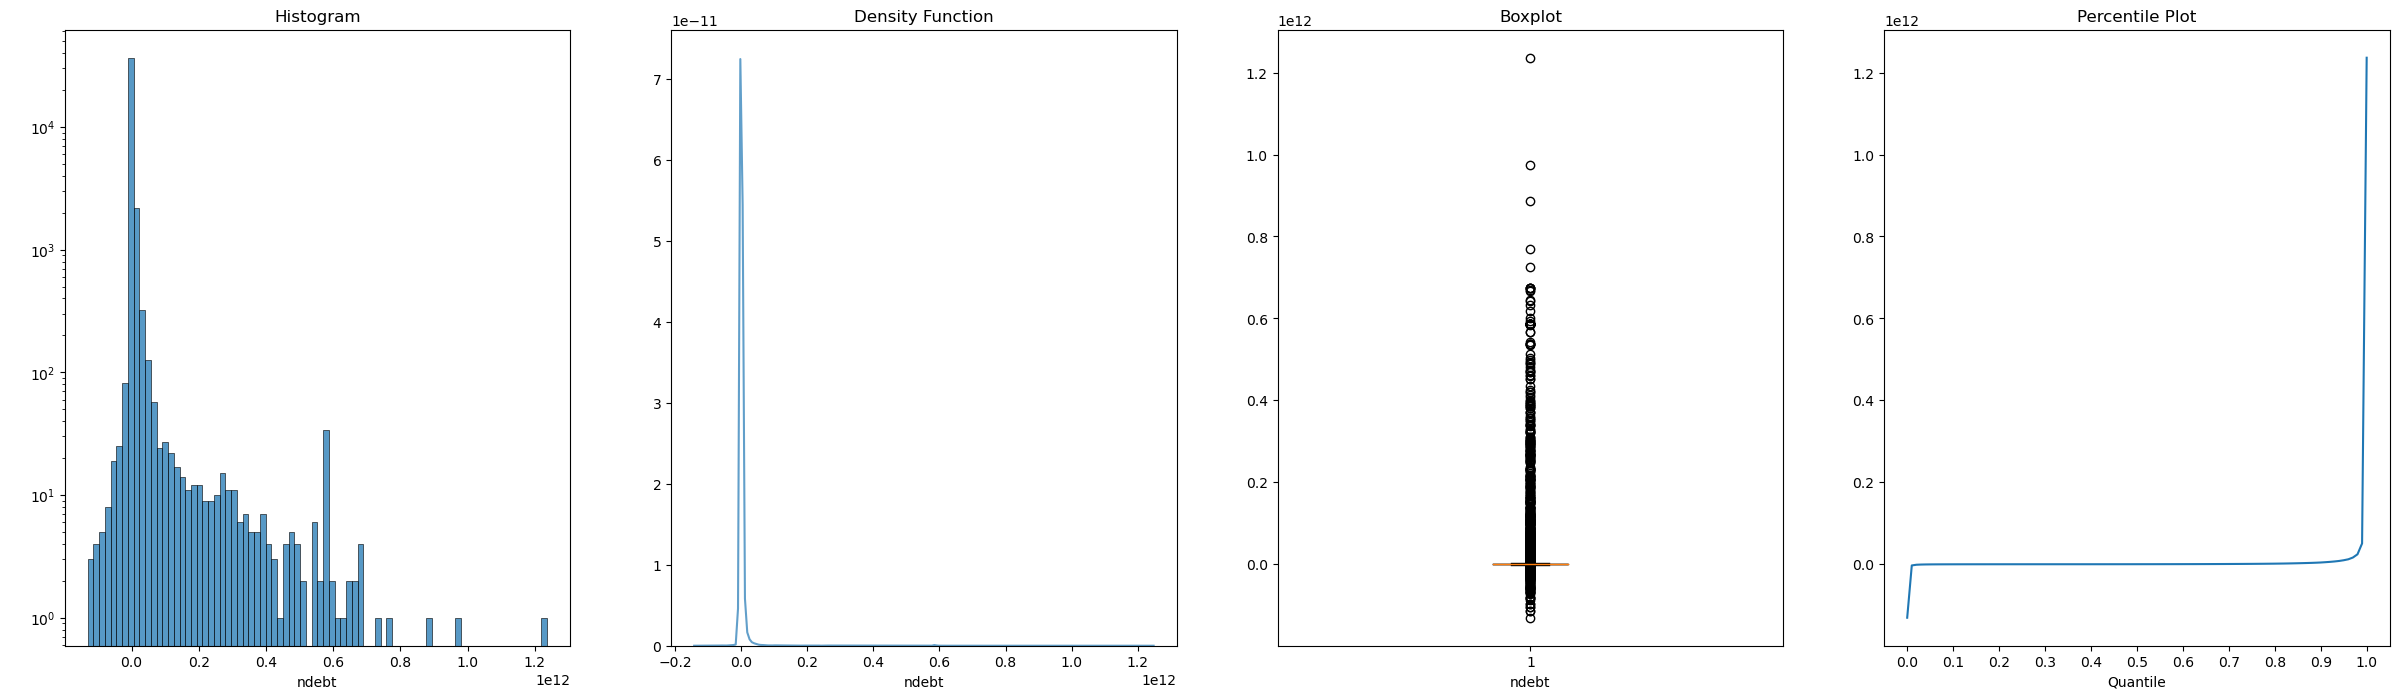

### capex

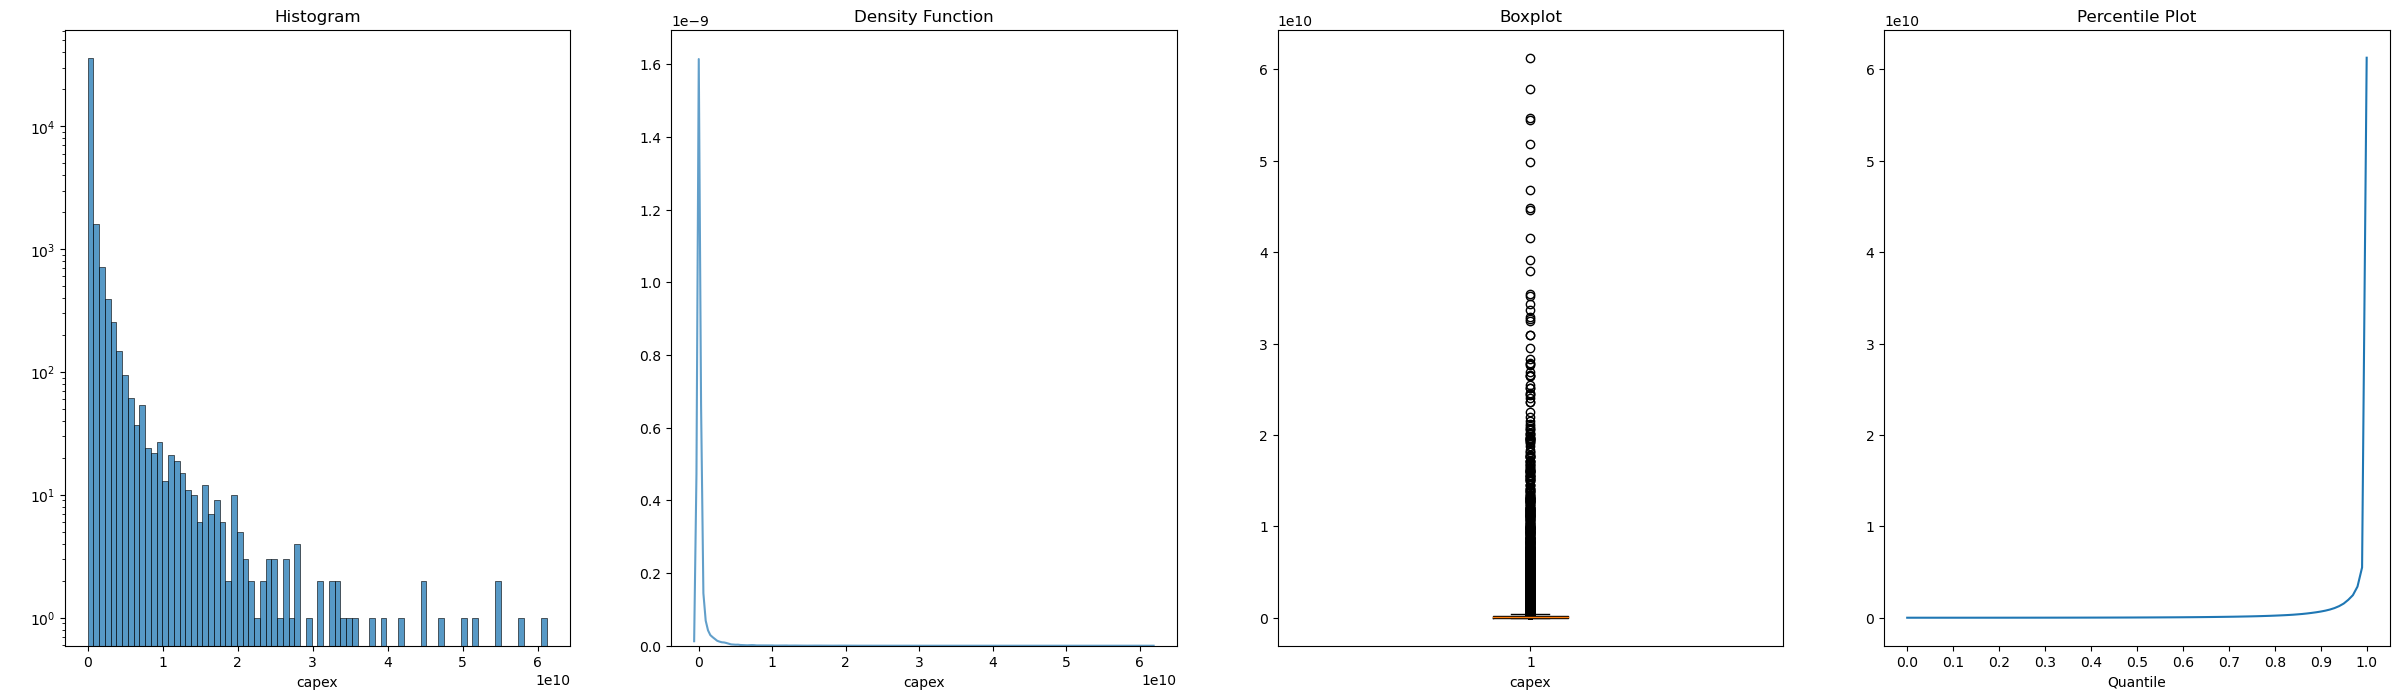

### ncfo

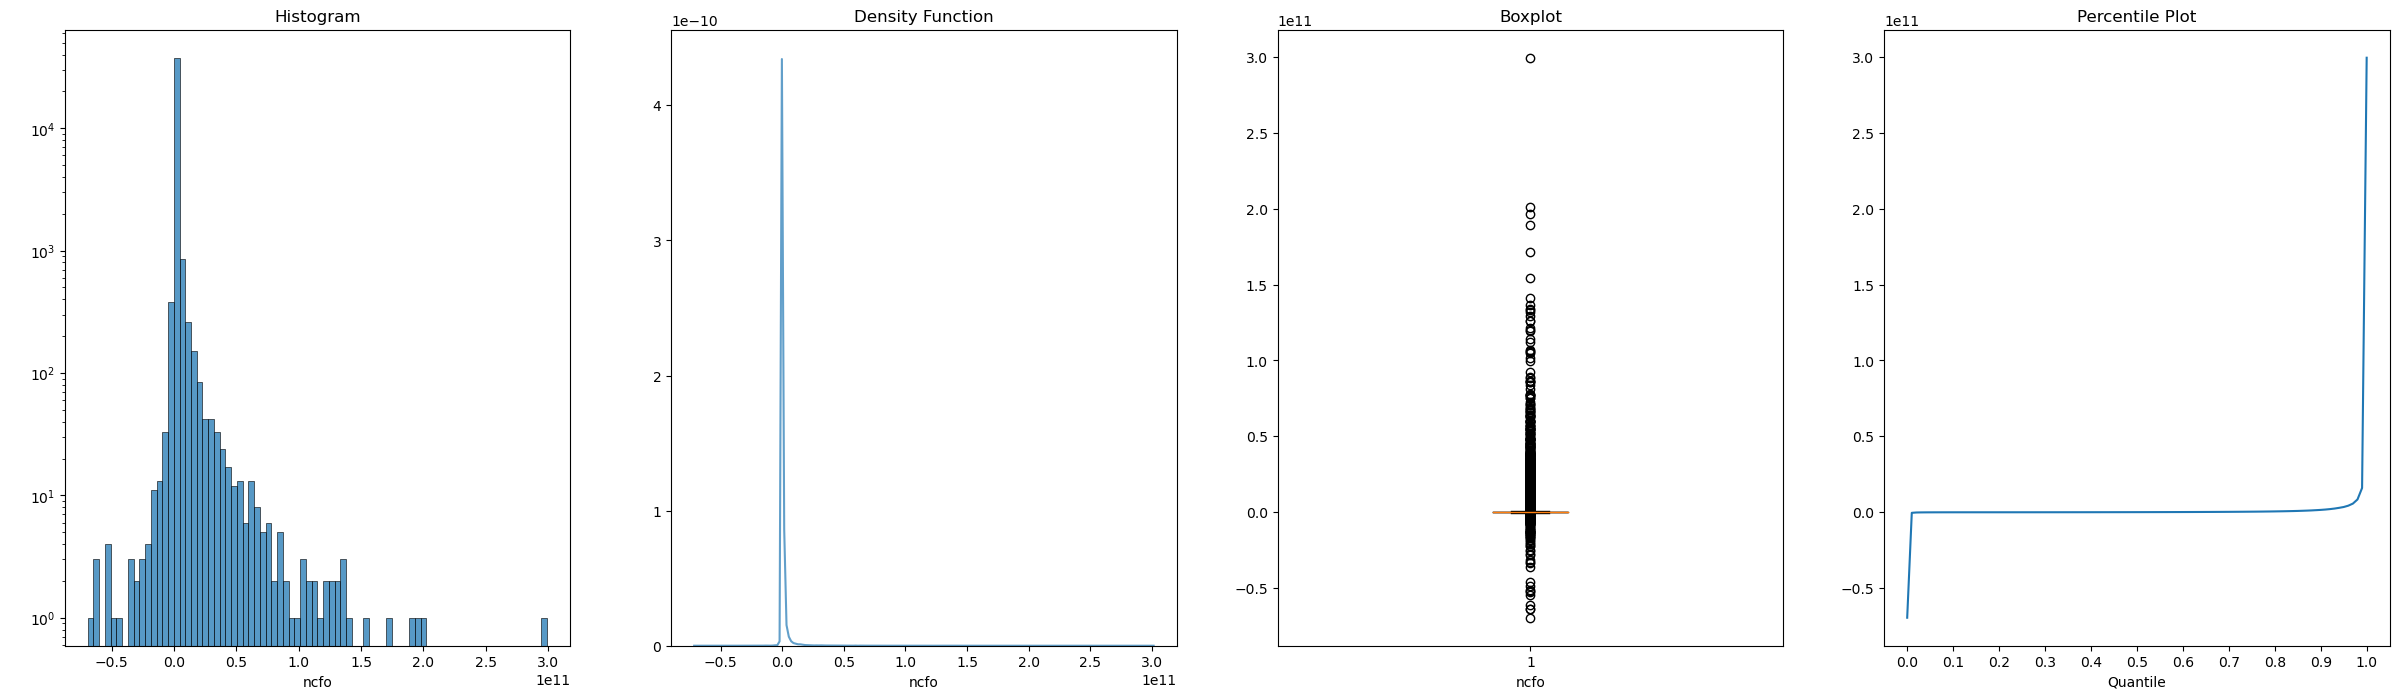

### levfcf

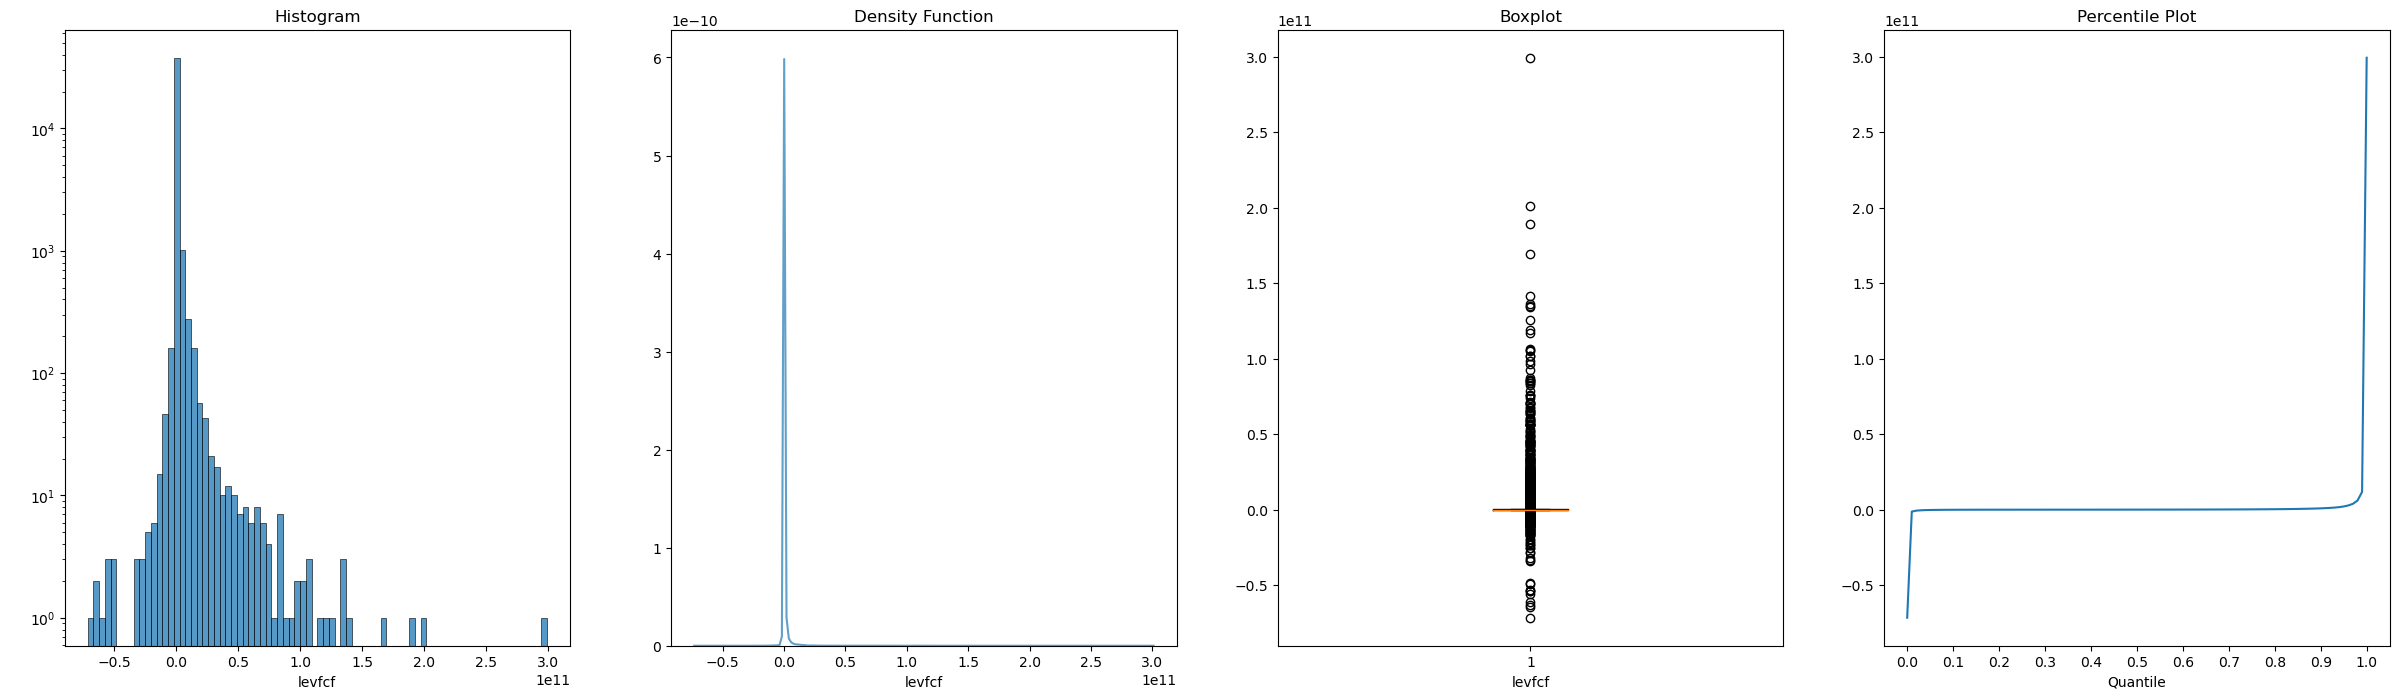

### nincam

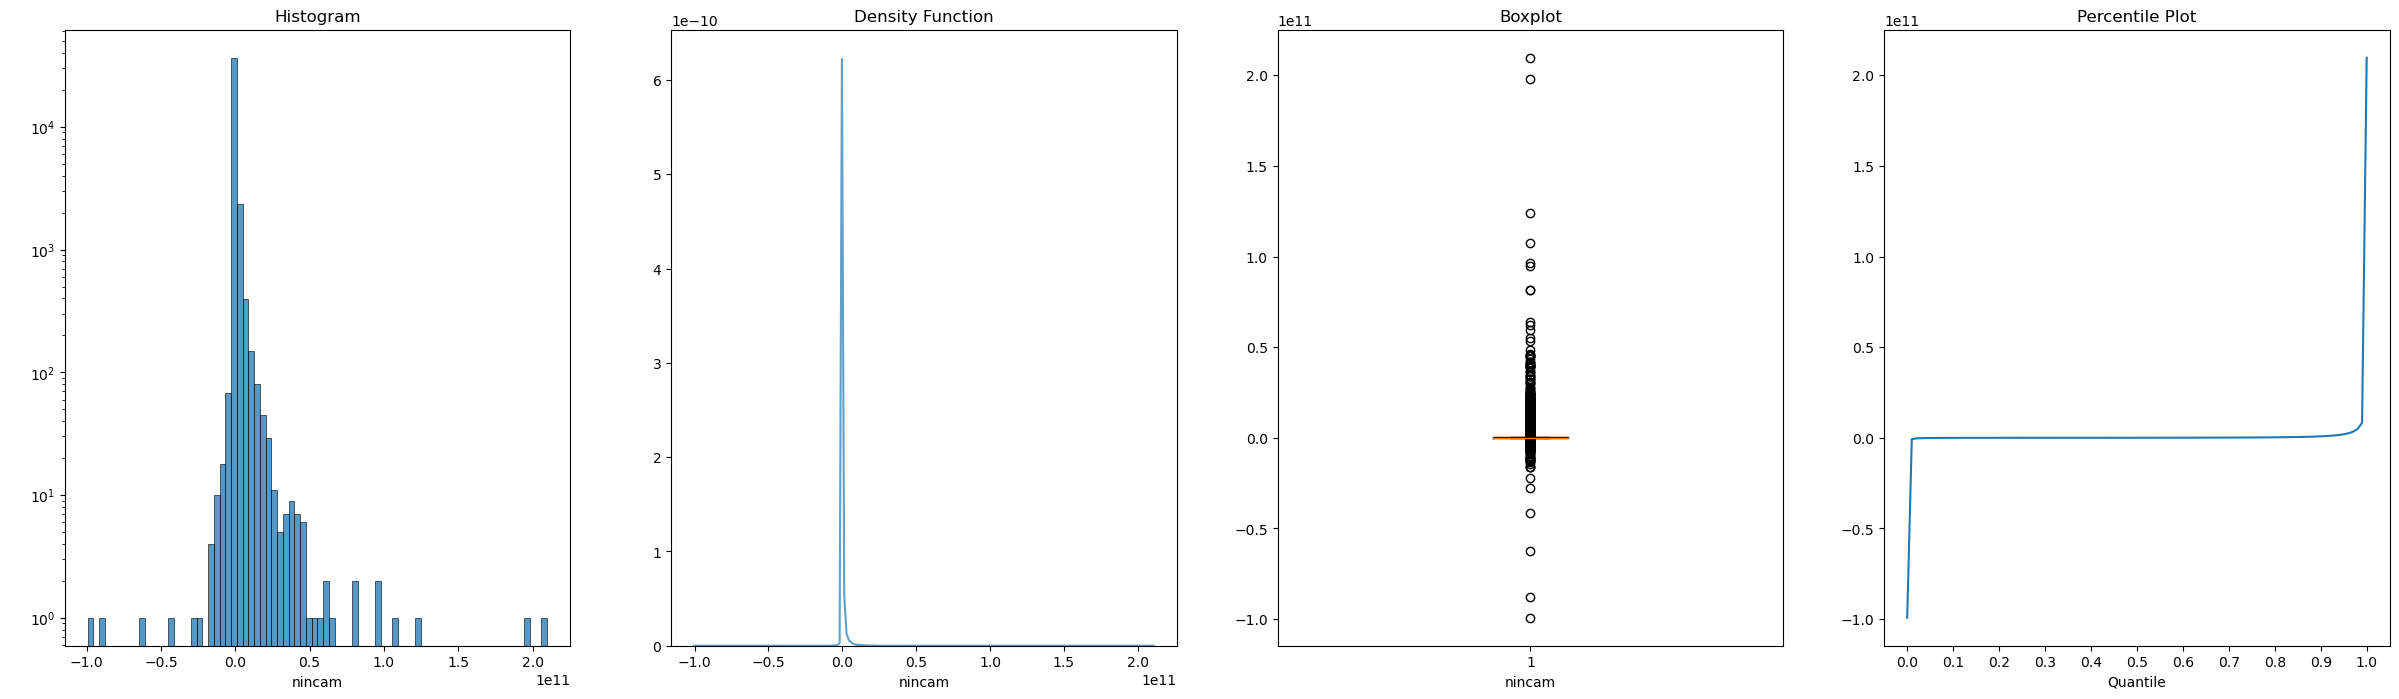

### gp

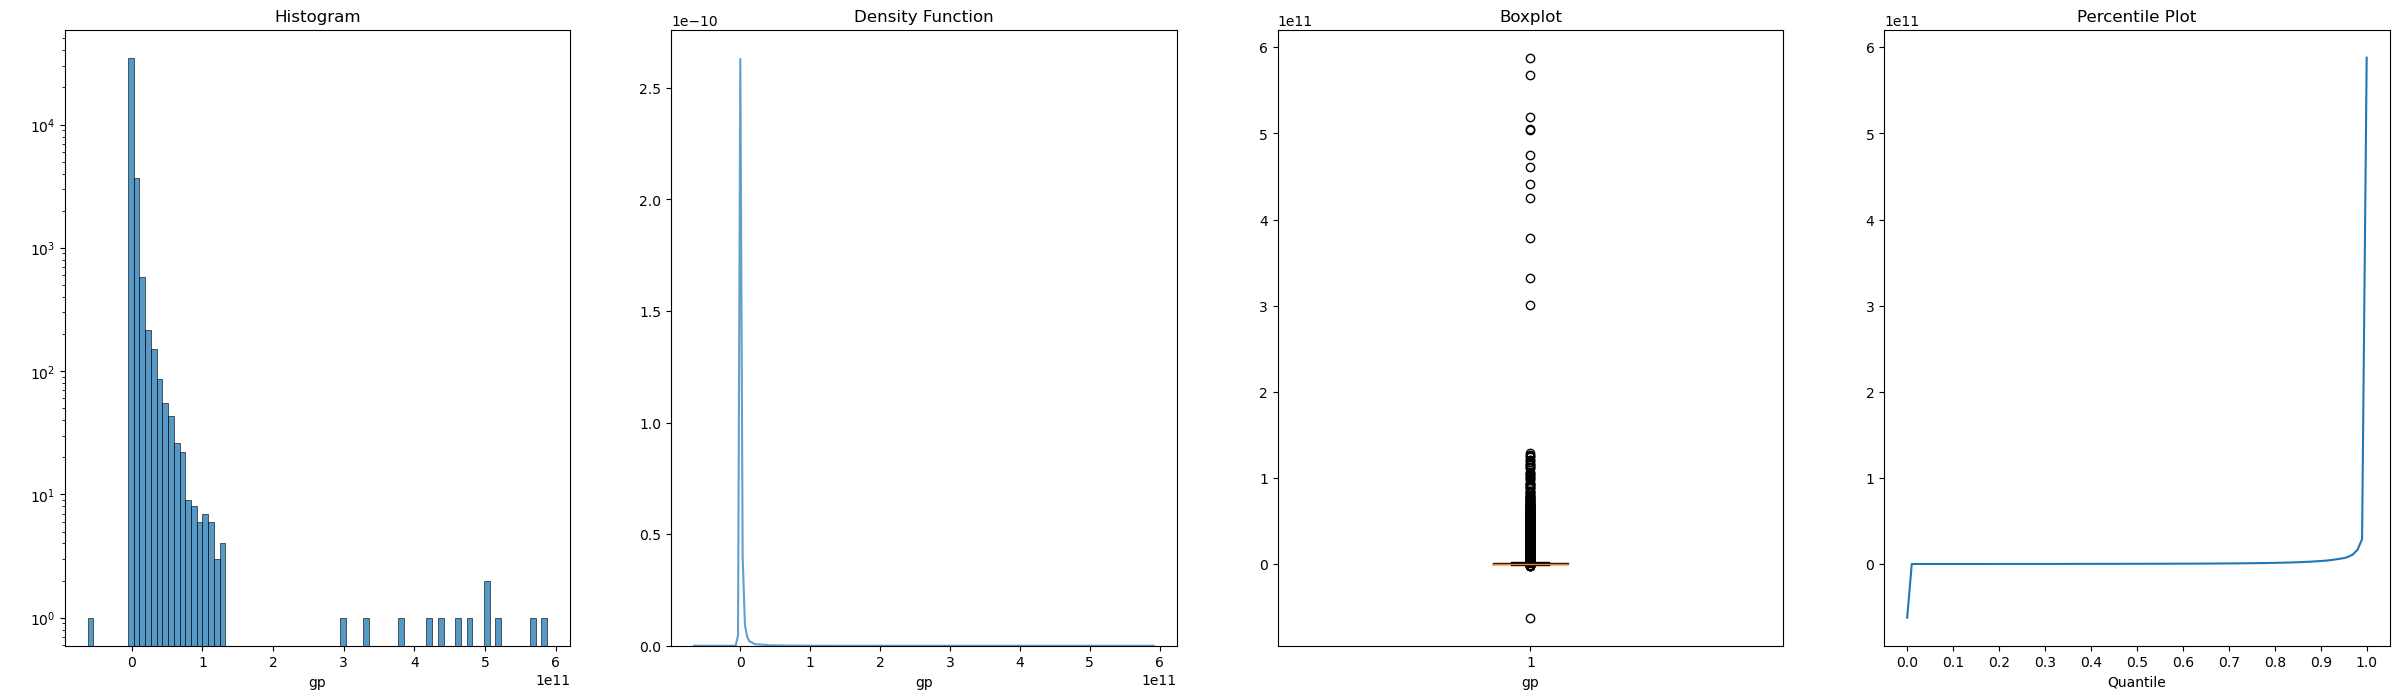

### trev

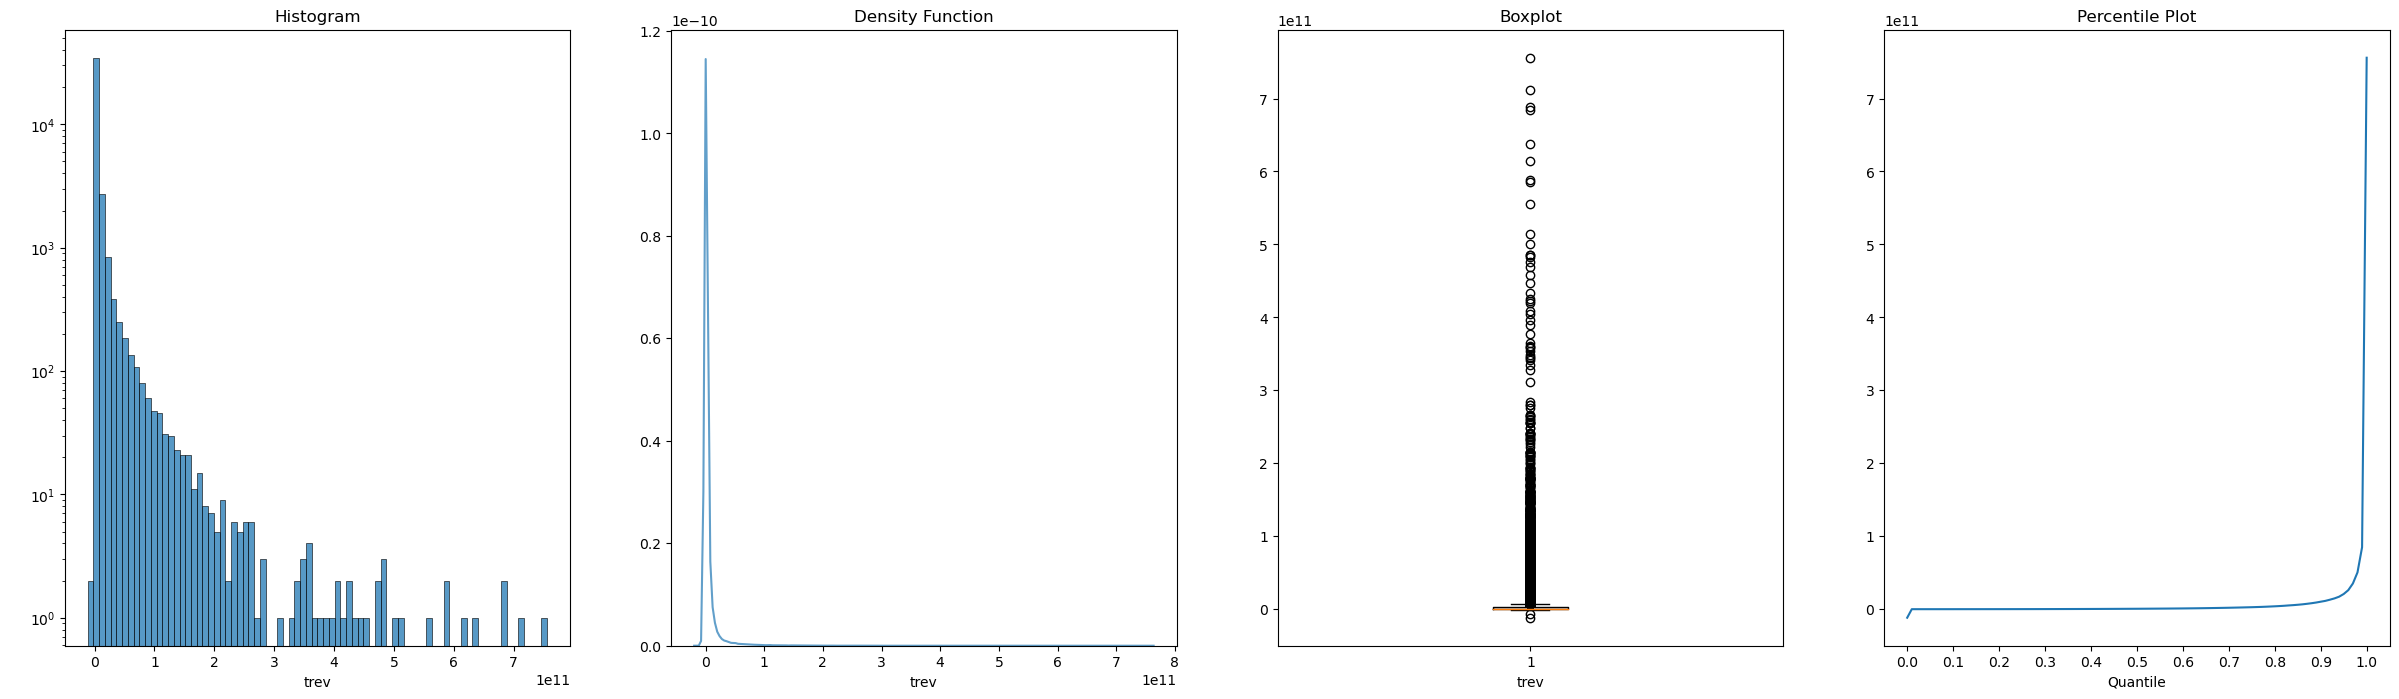

### ebit

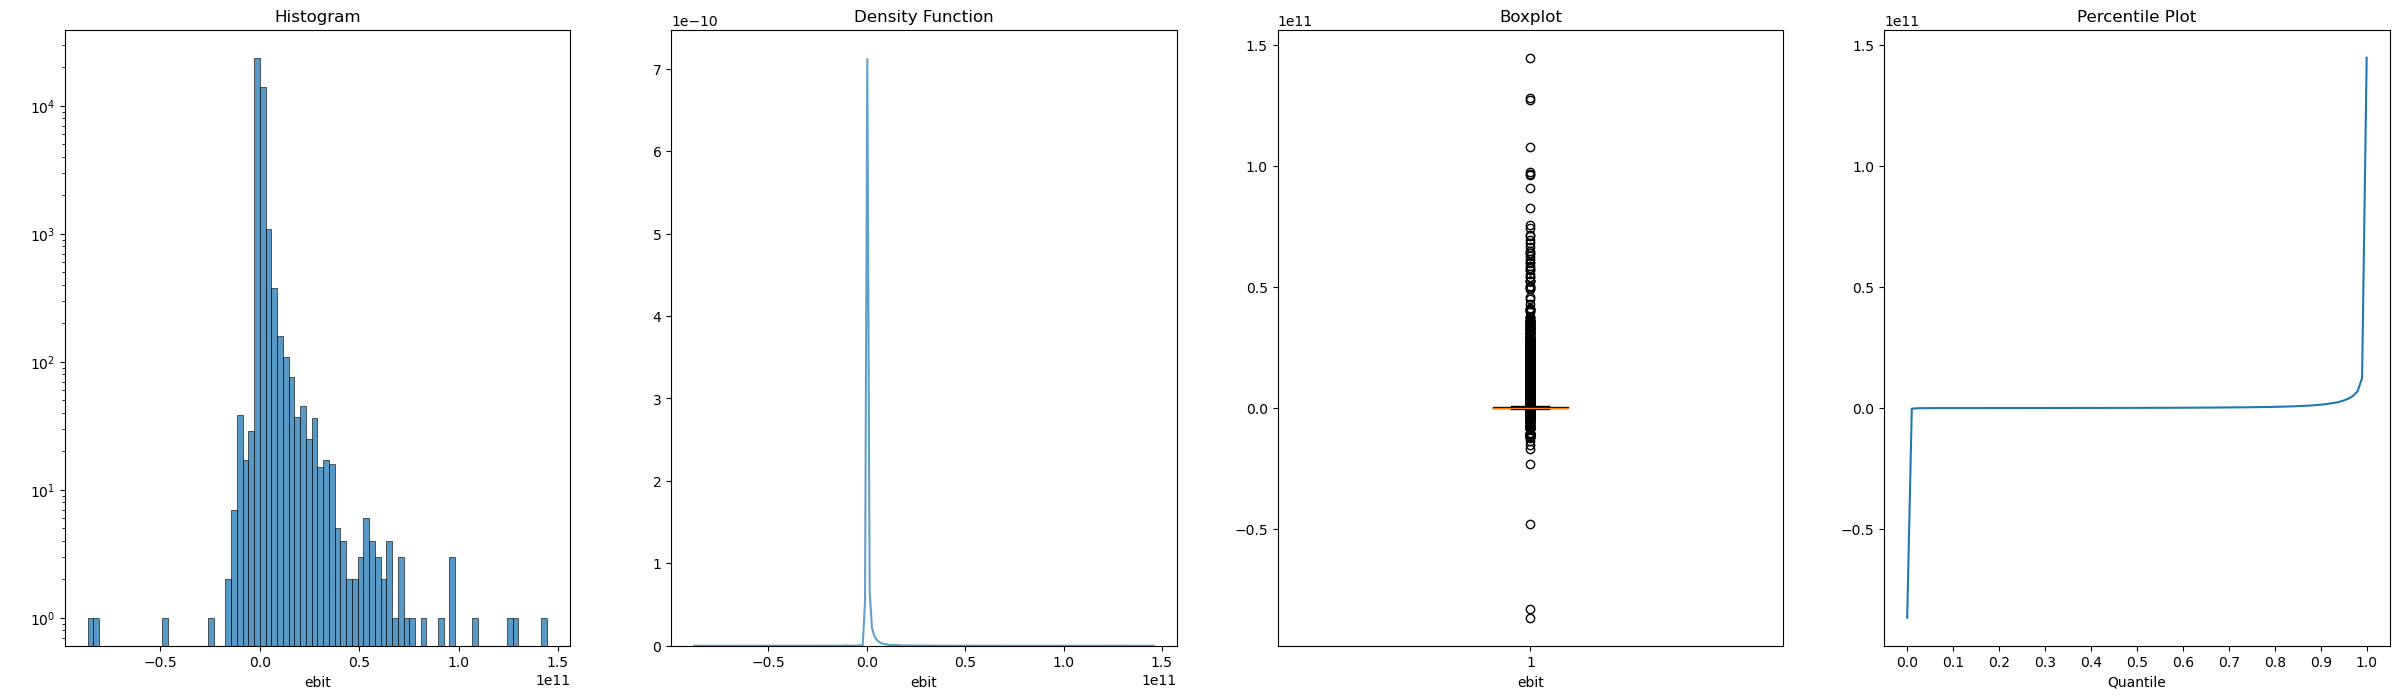

### roe

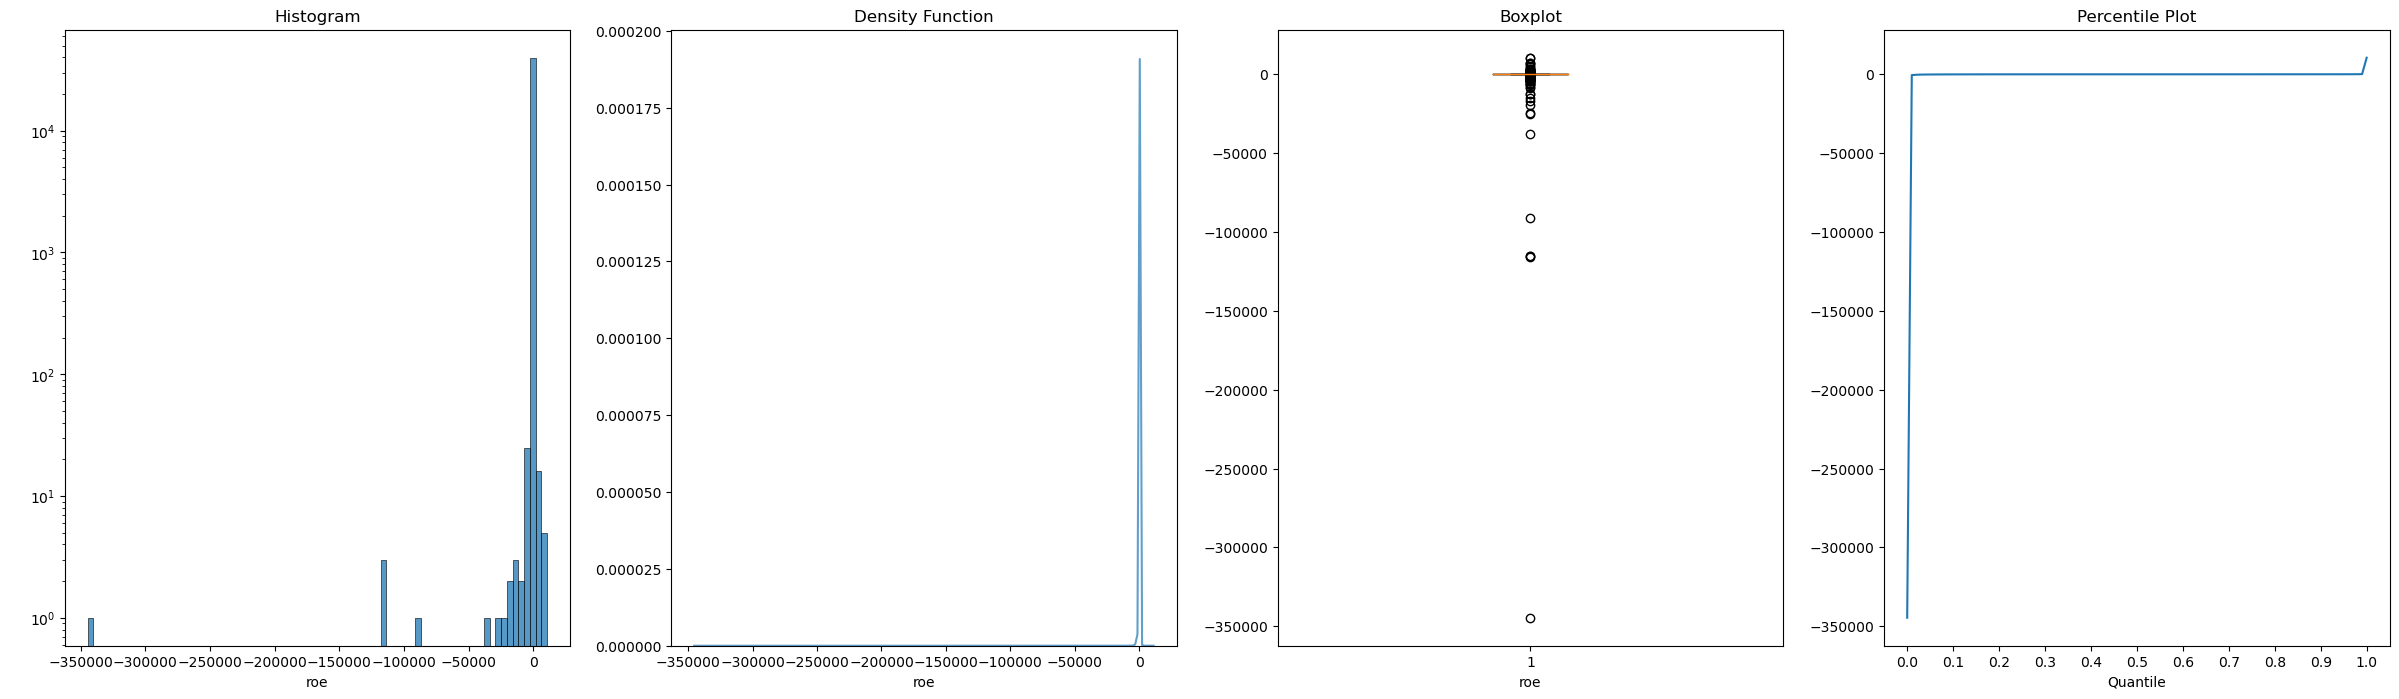

### roce

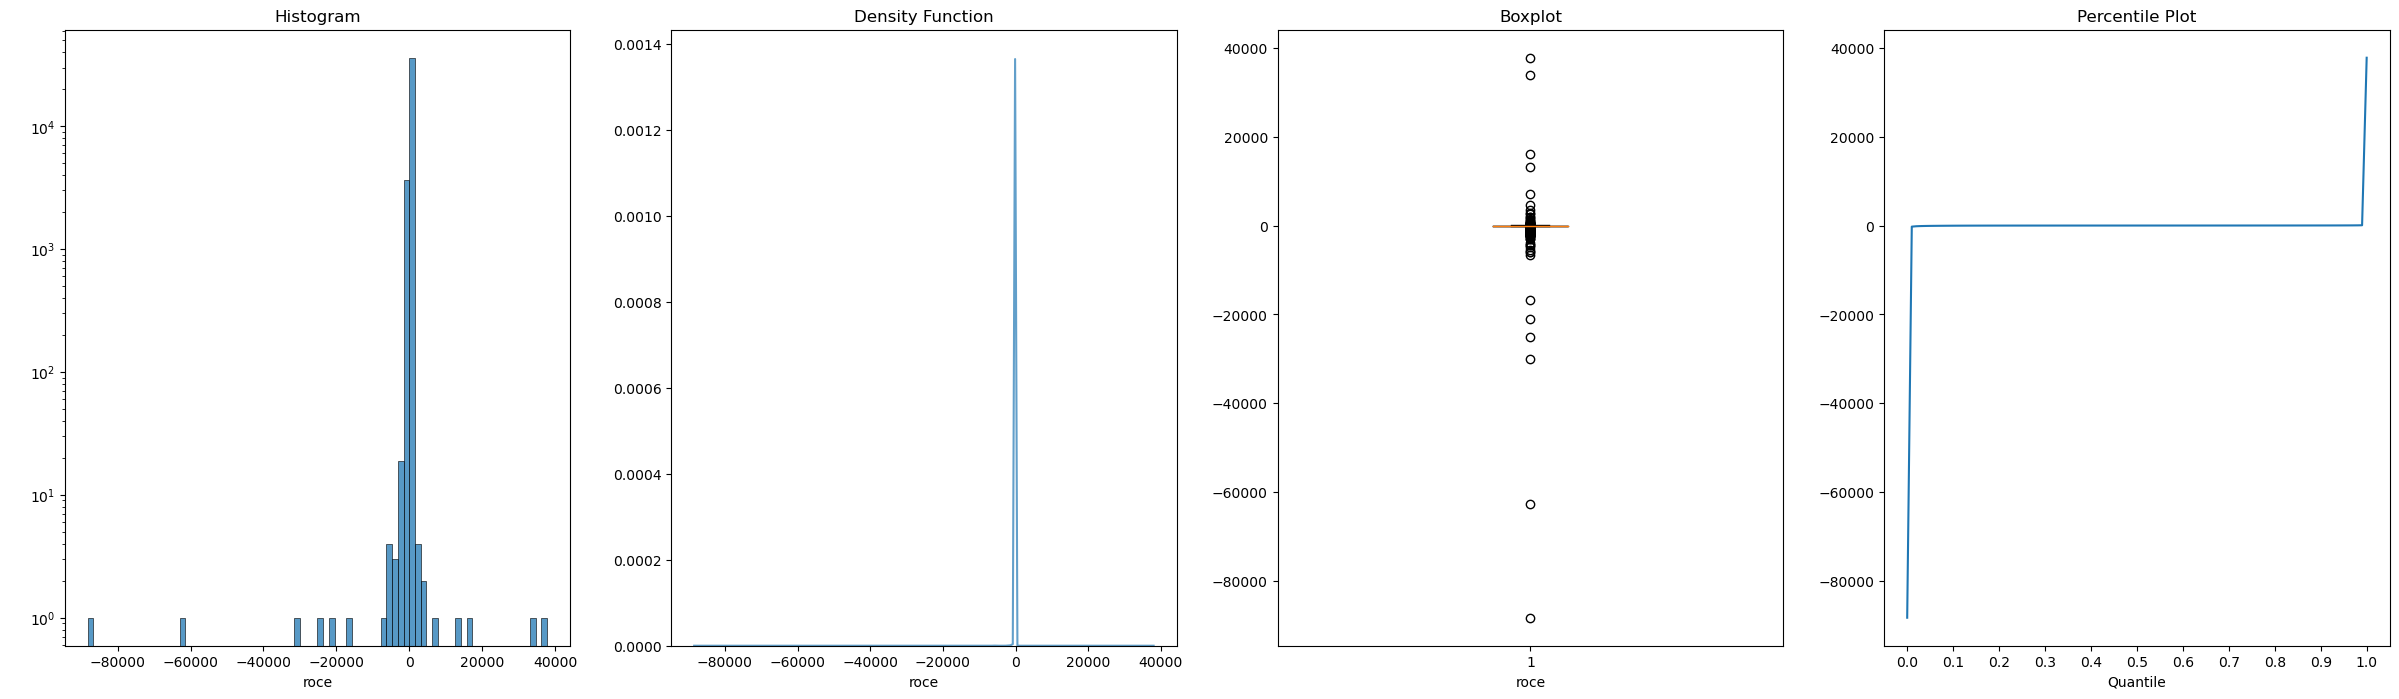

### rnoa

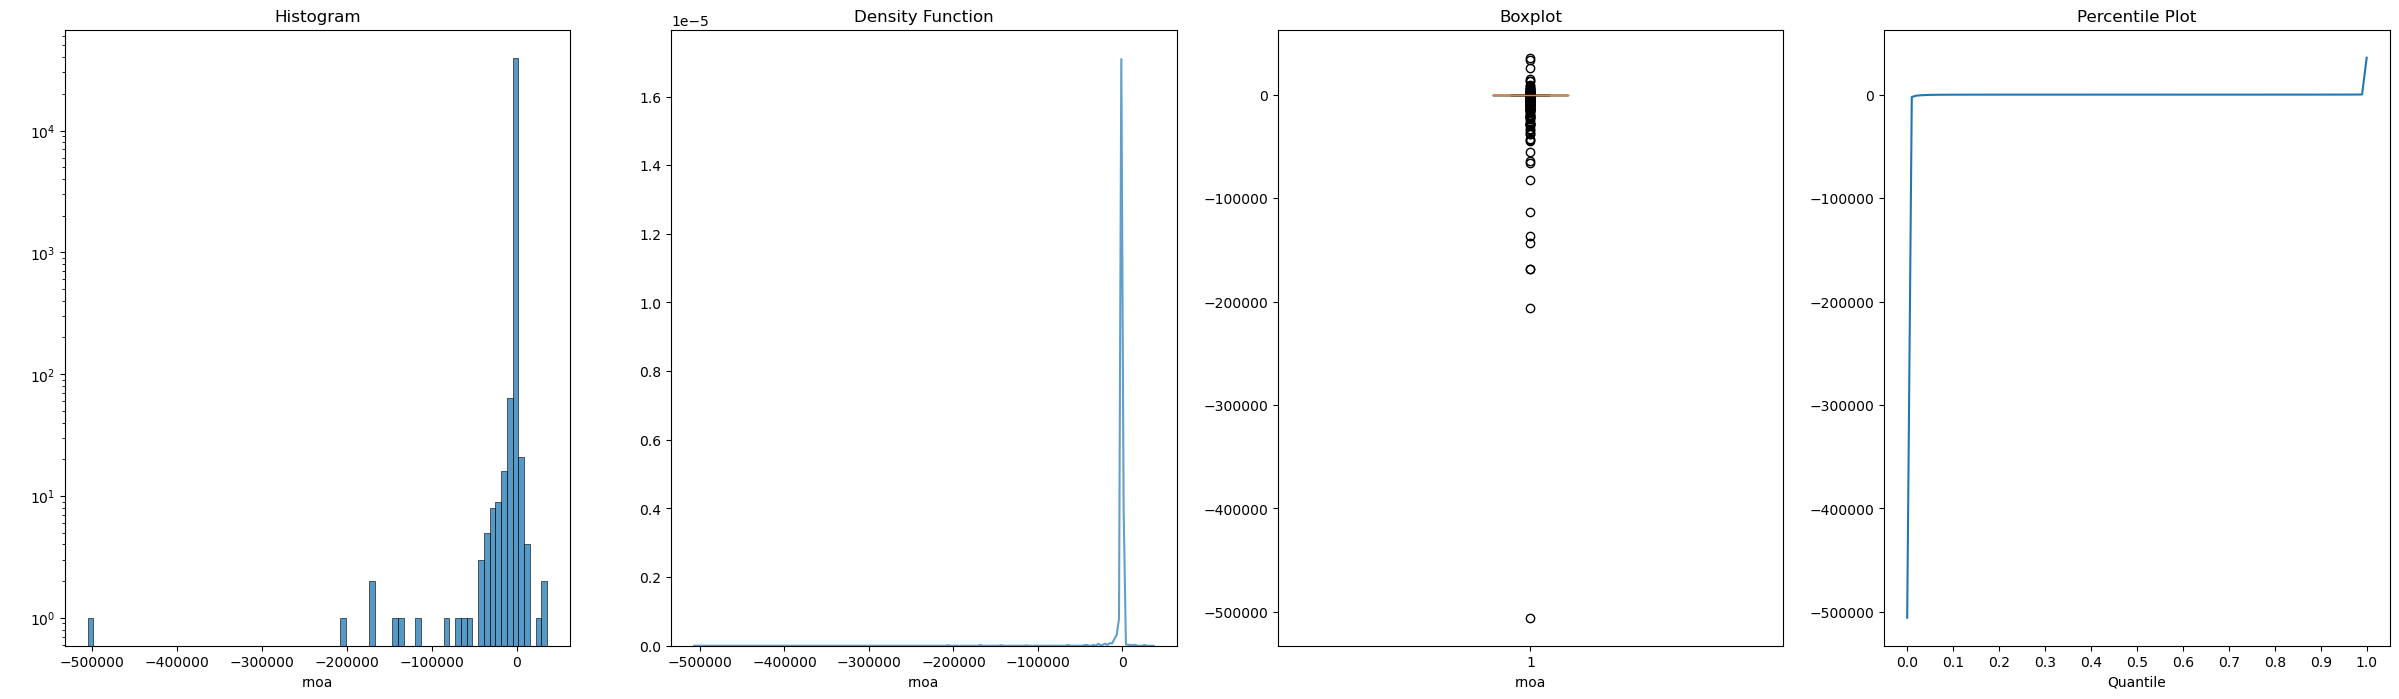

### ebitmarg

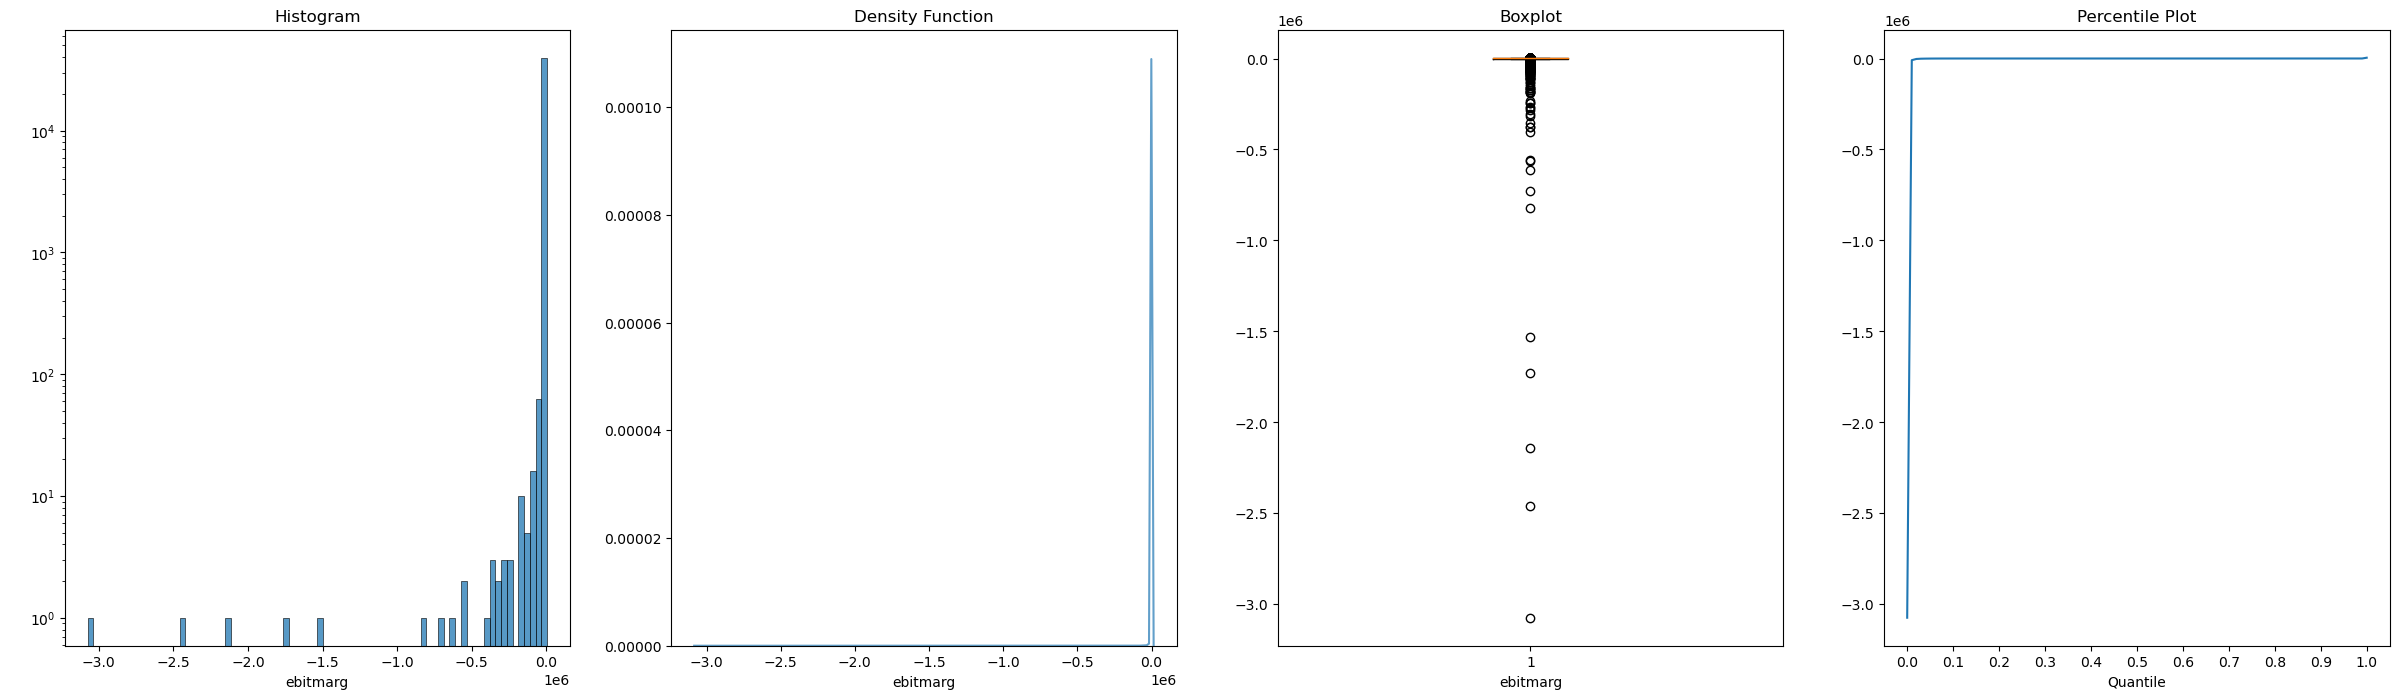

### shouts

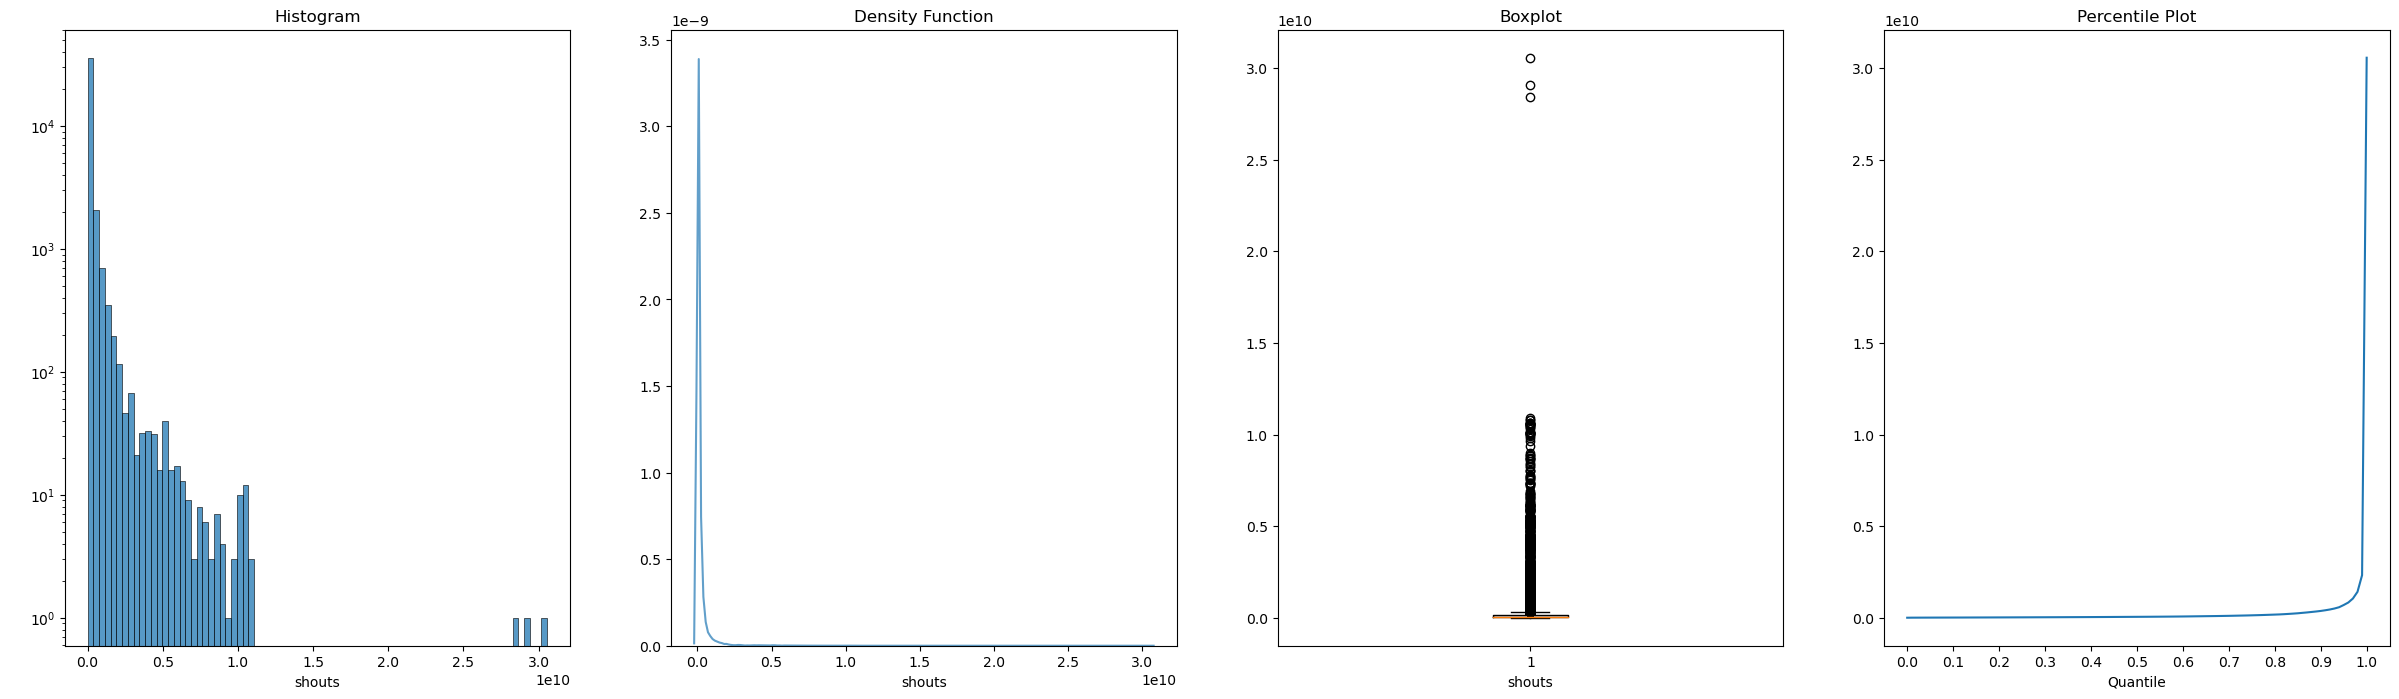

### mc

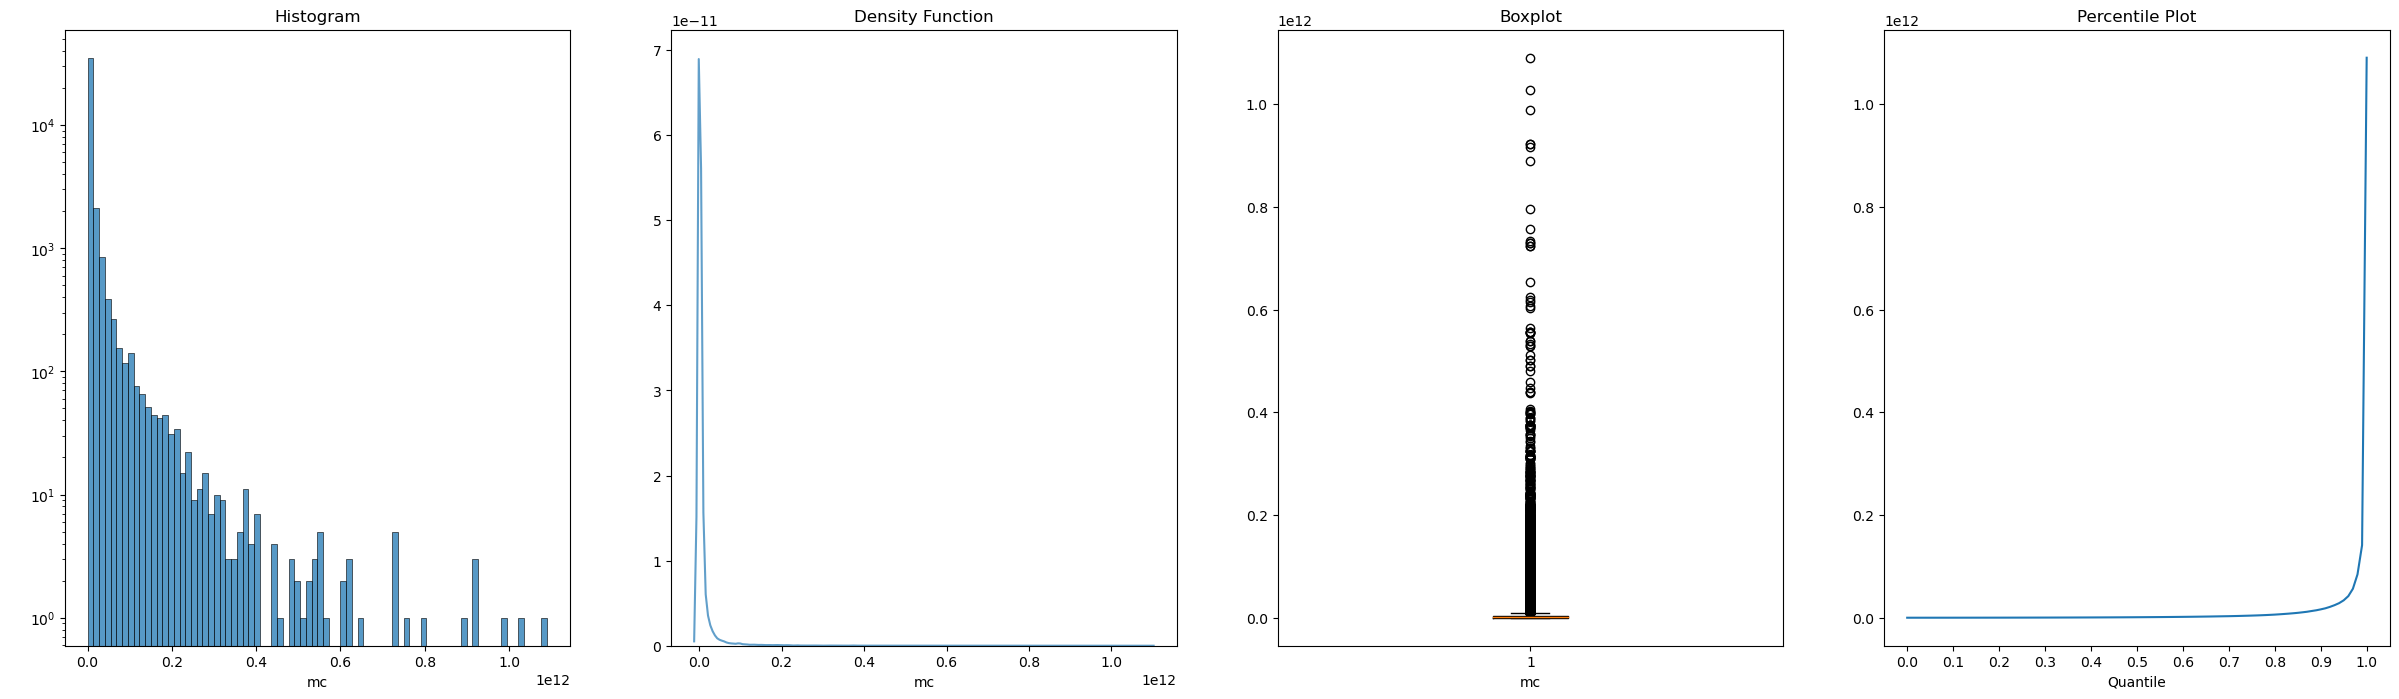

### ptbvps

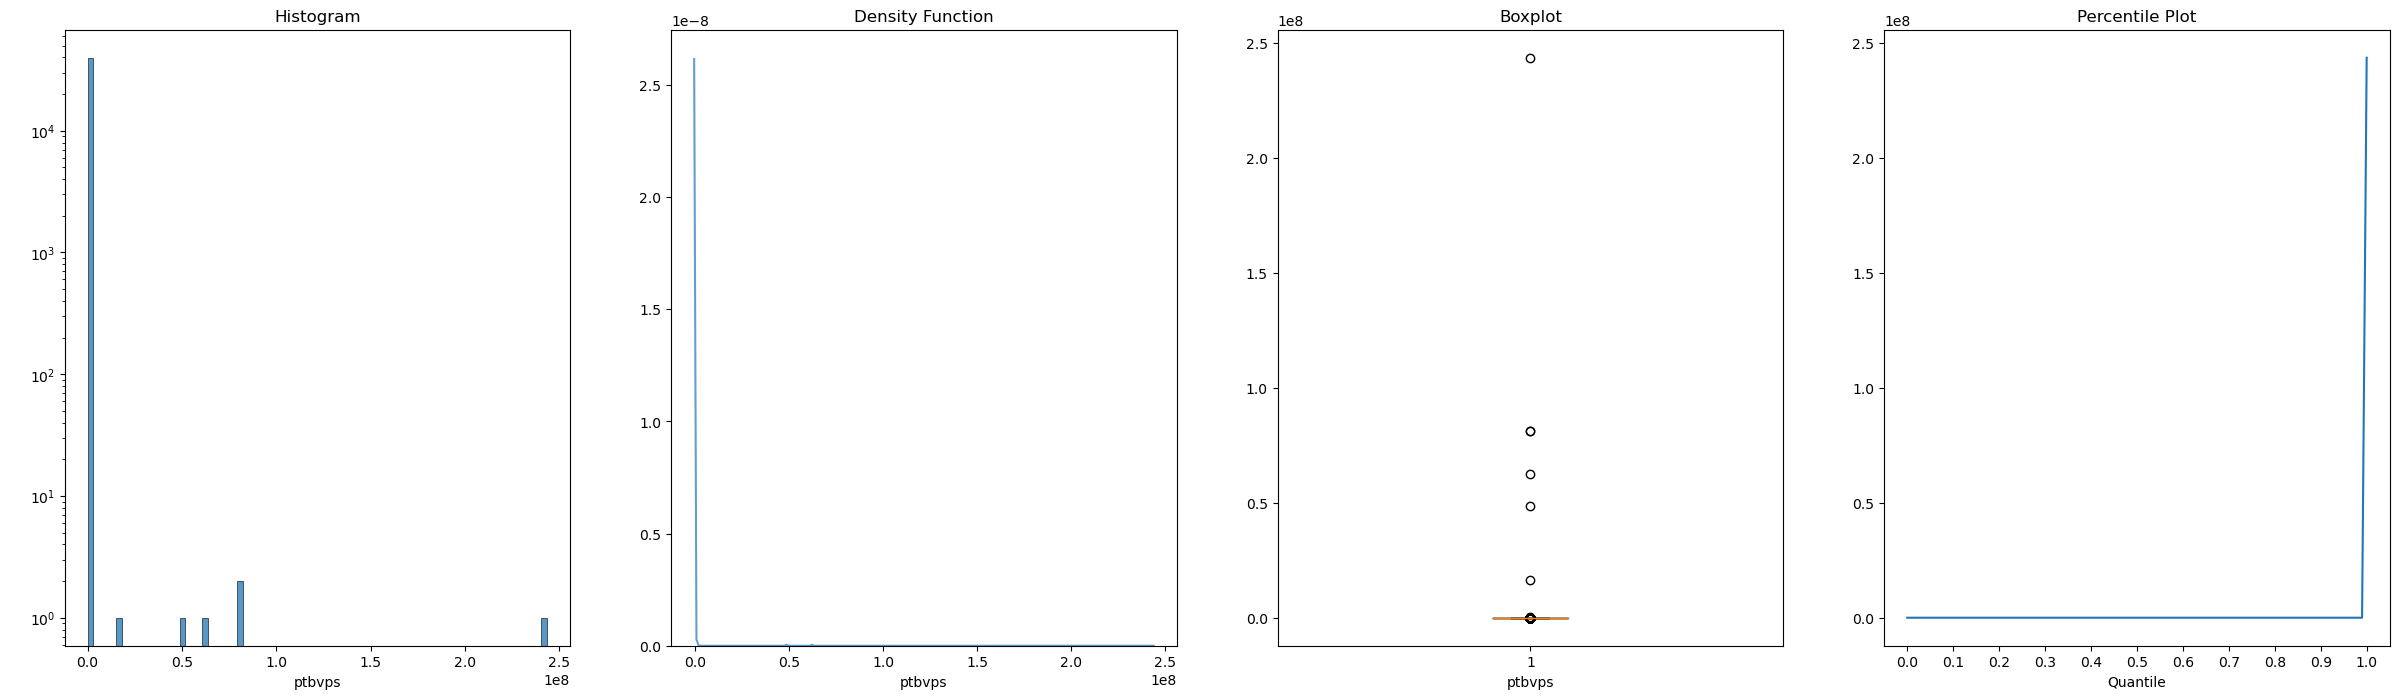

### oips

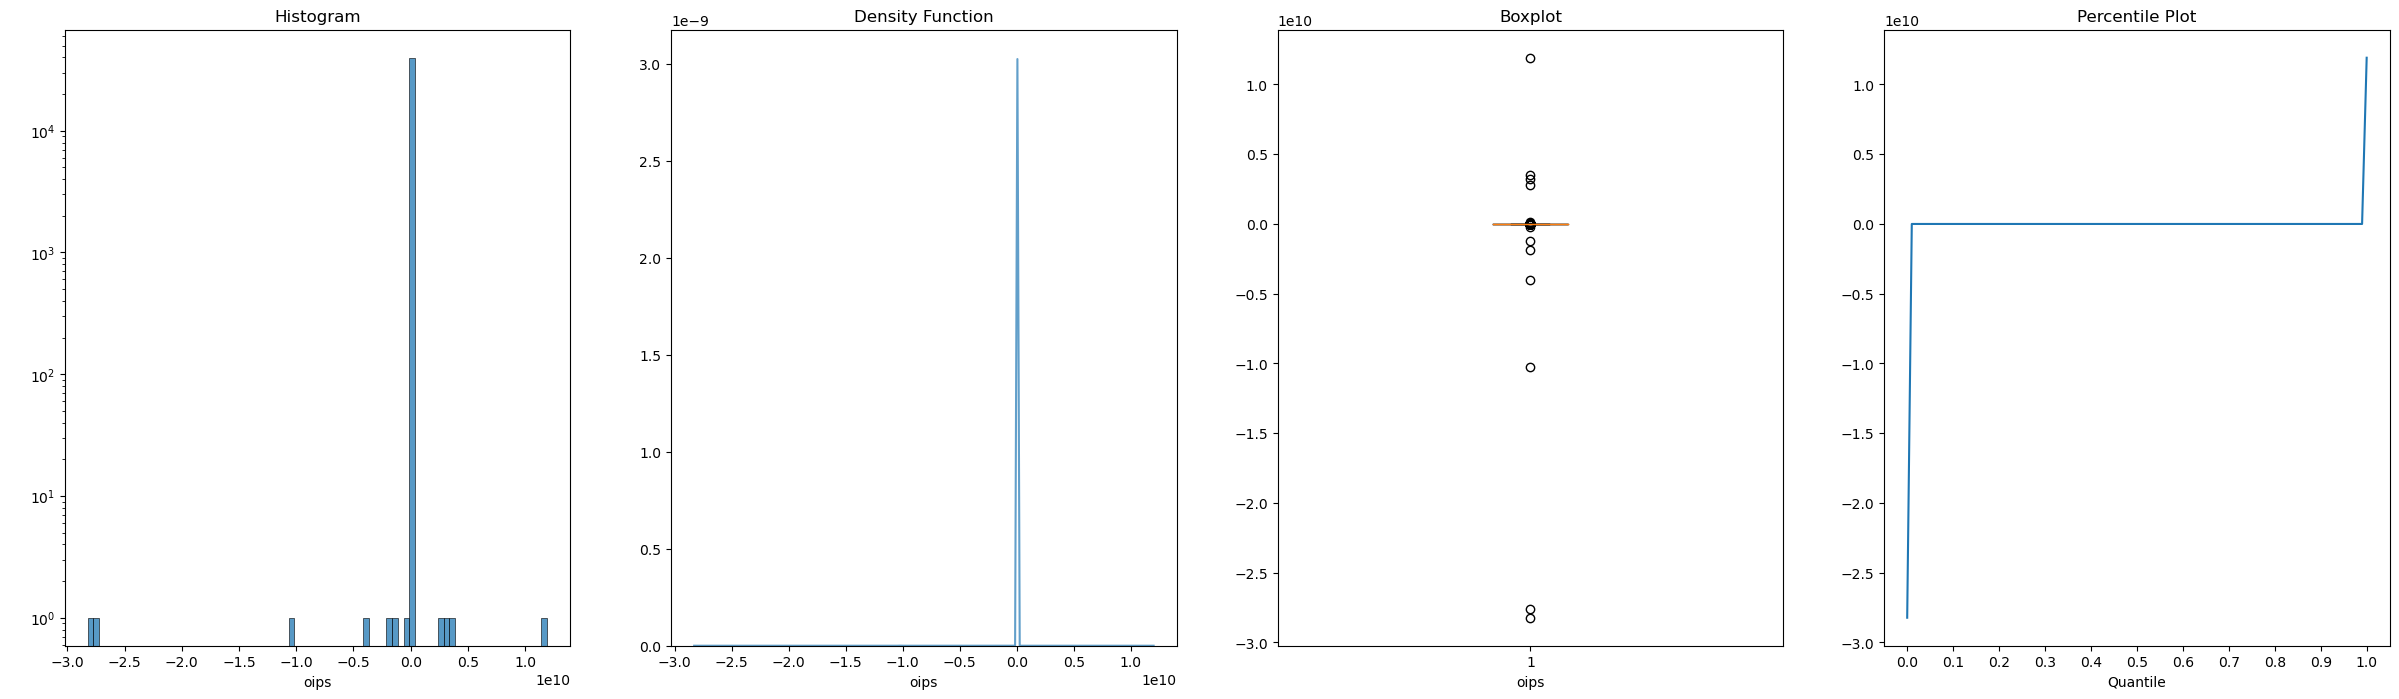

### cfps

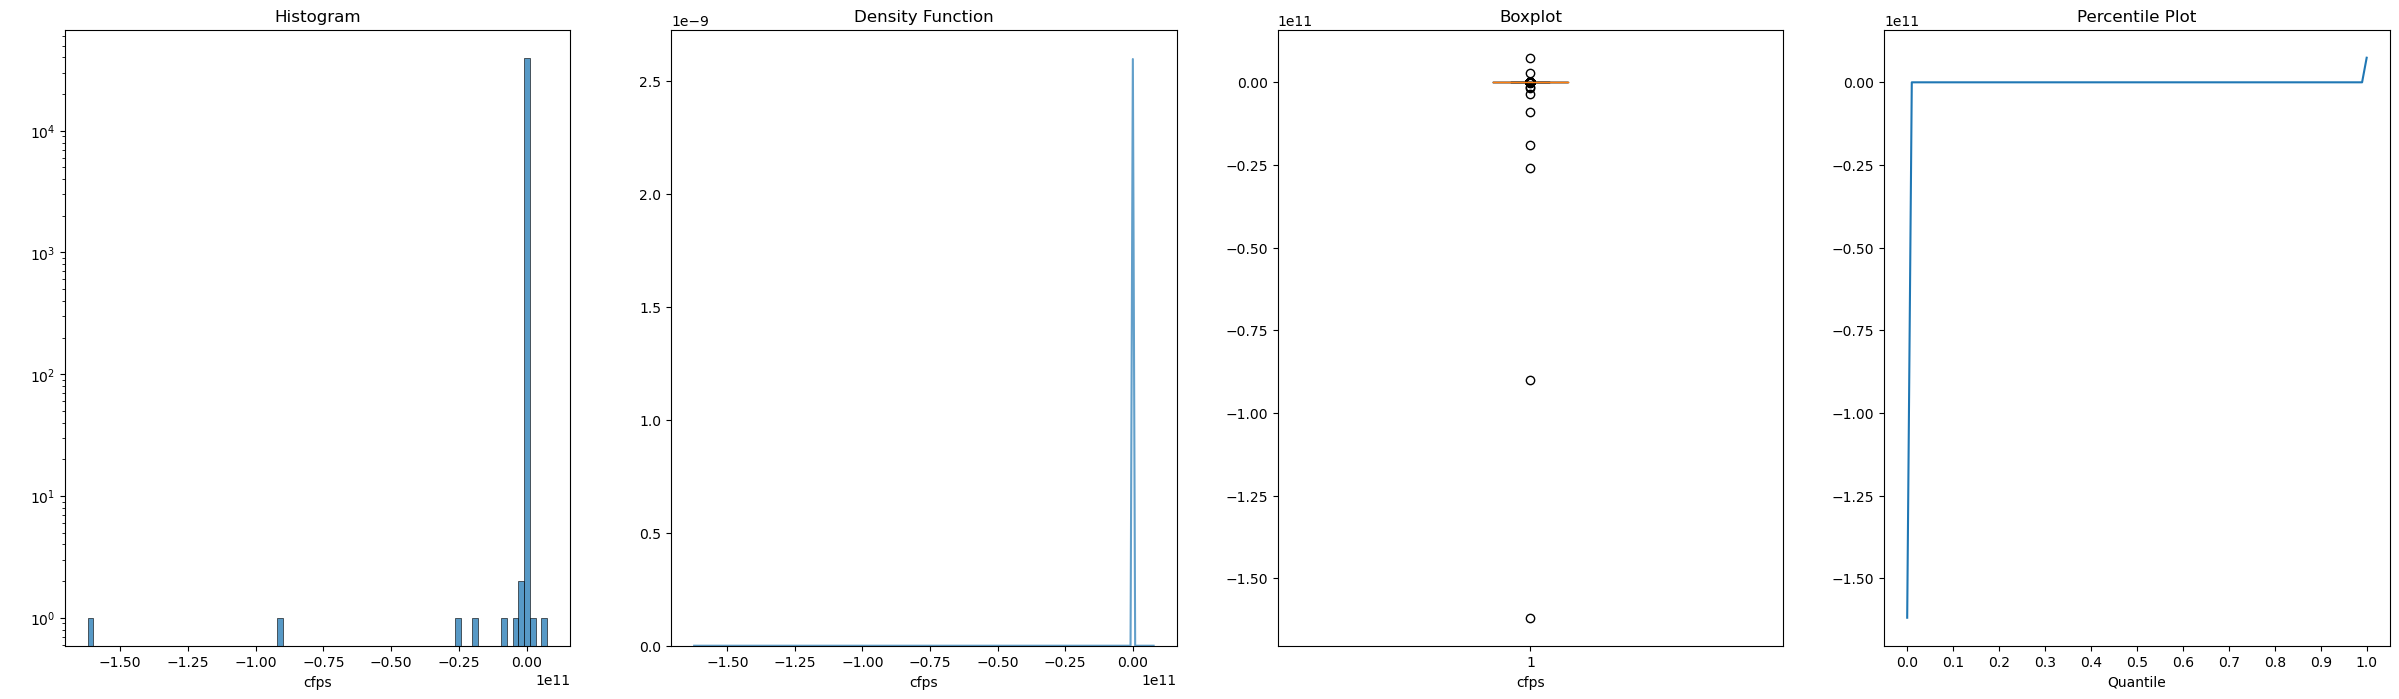

### ros_c

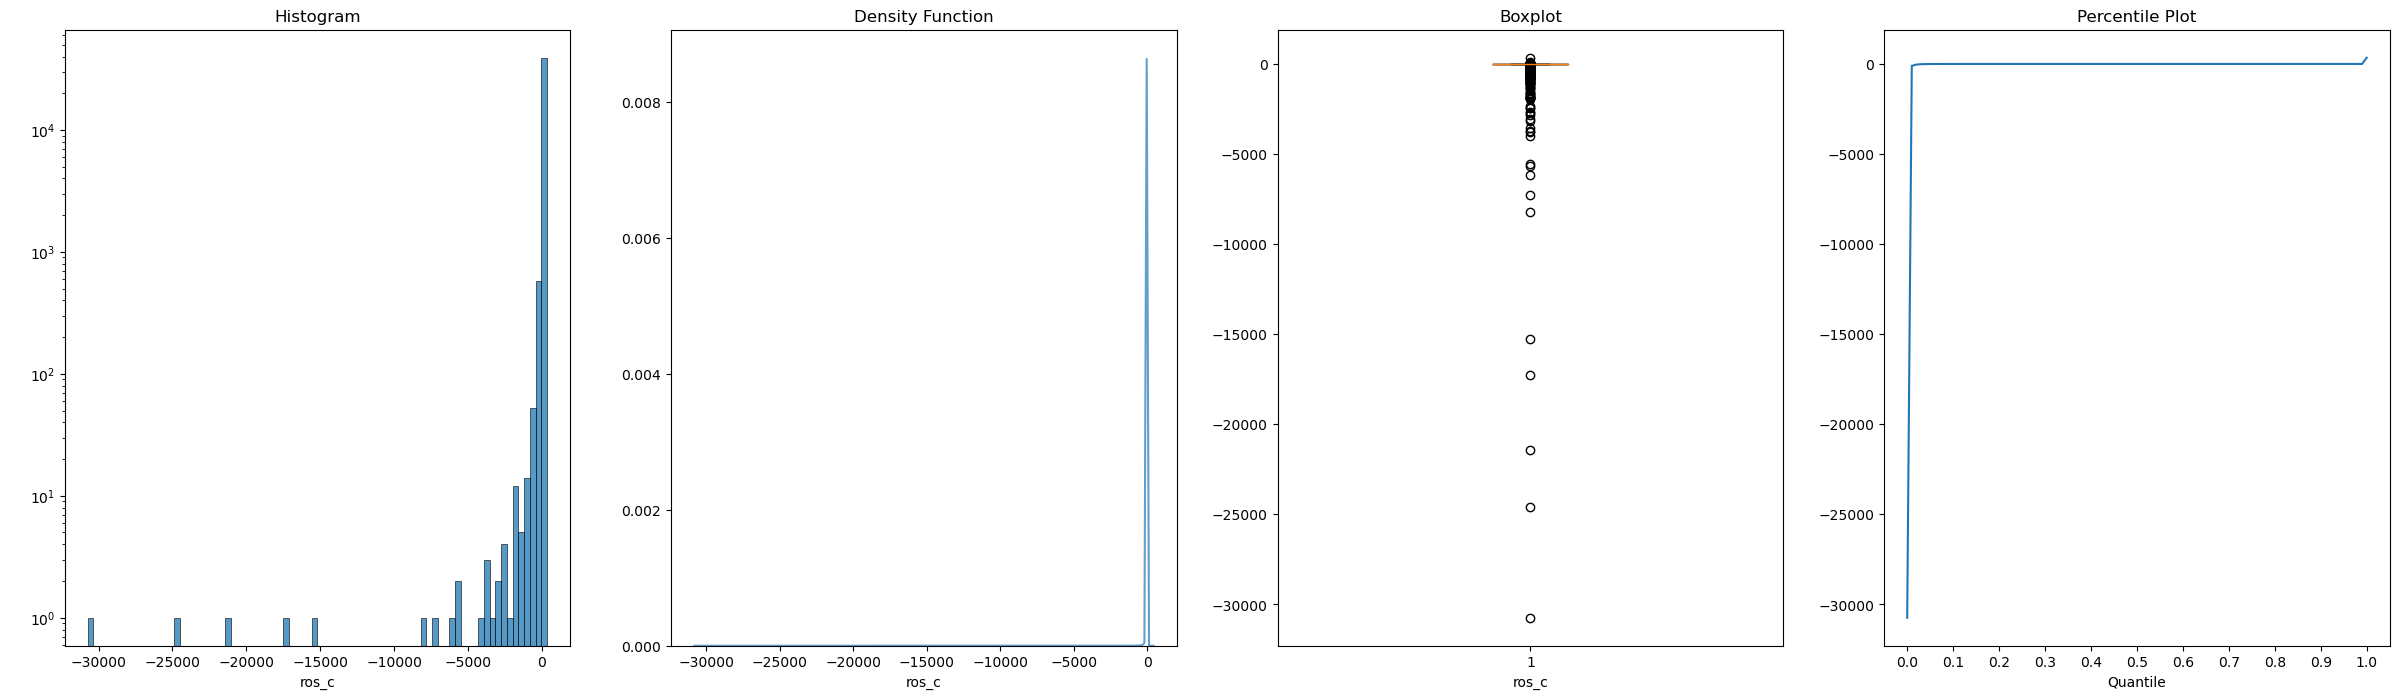

### prof_c

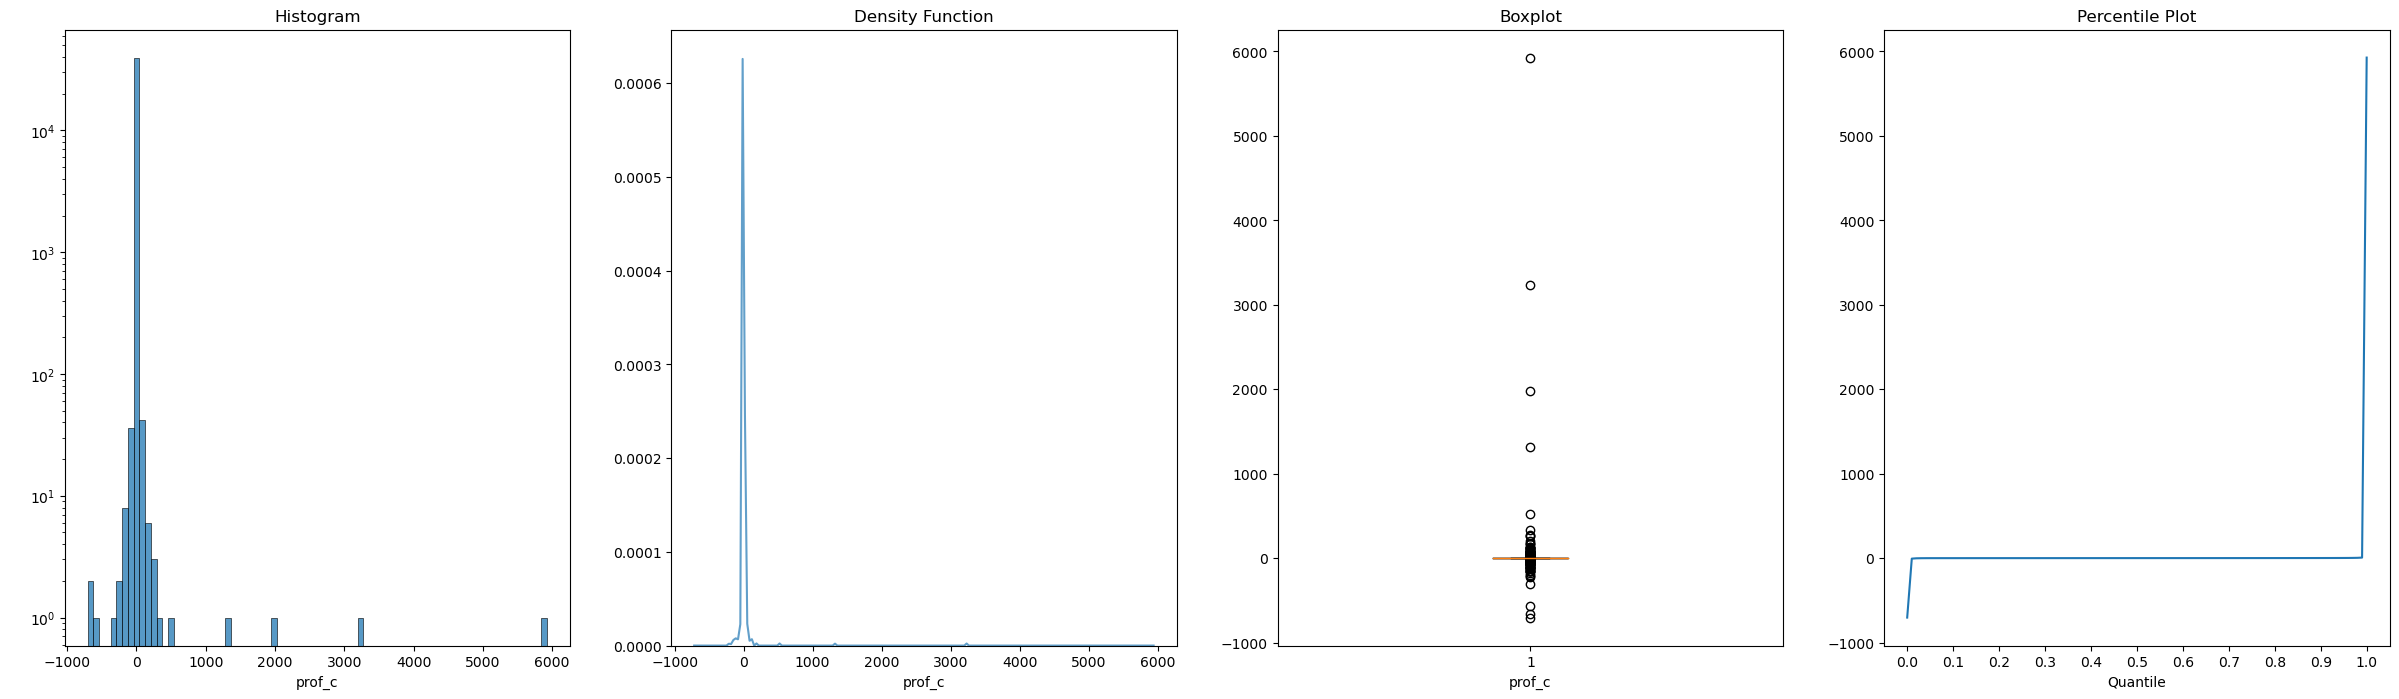

### finlev_c

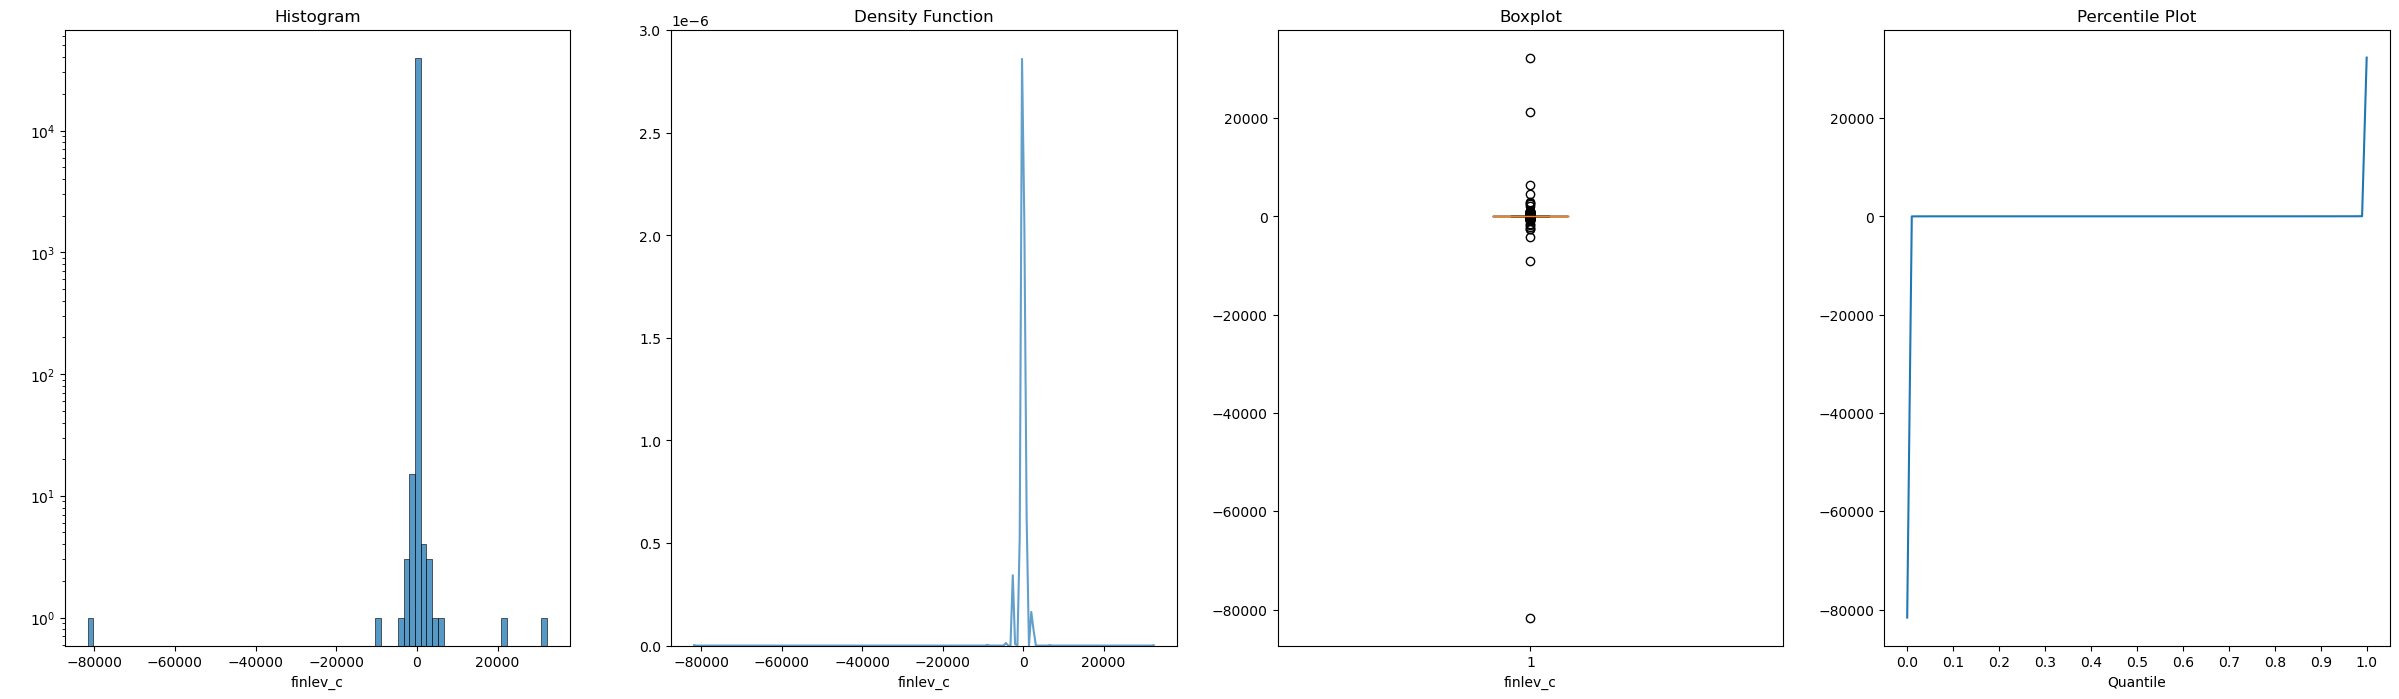

### inc_days

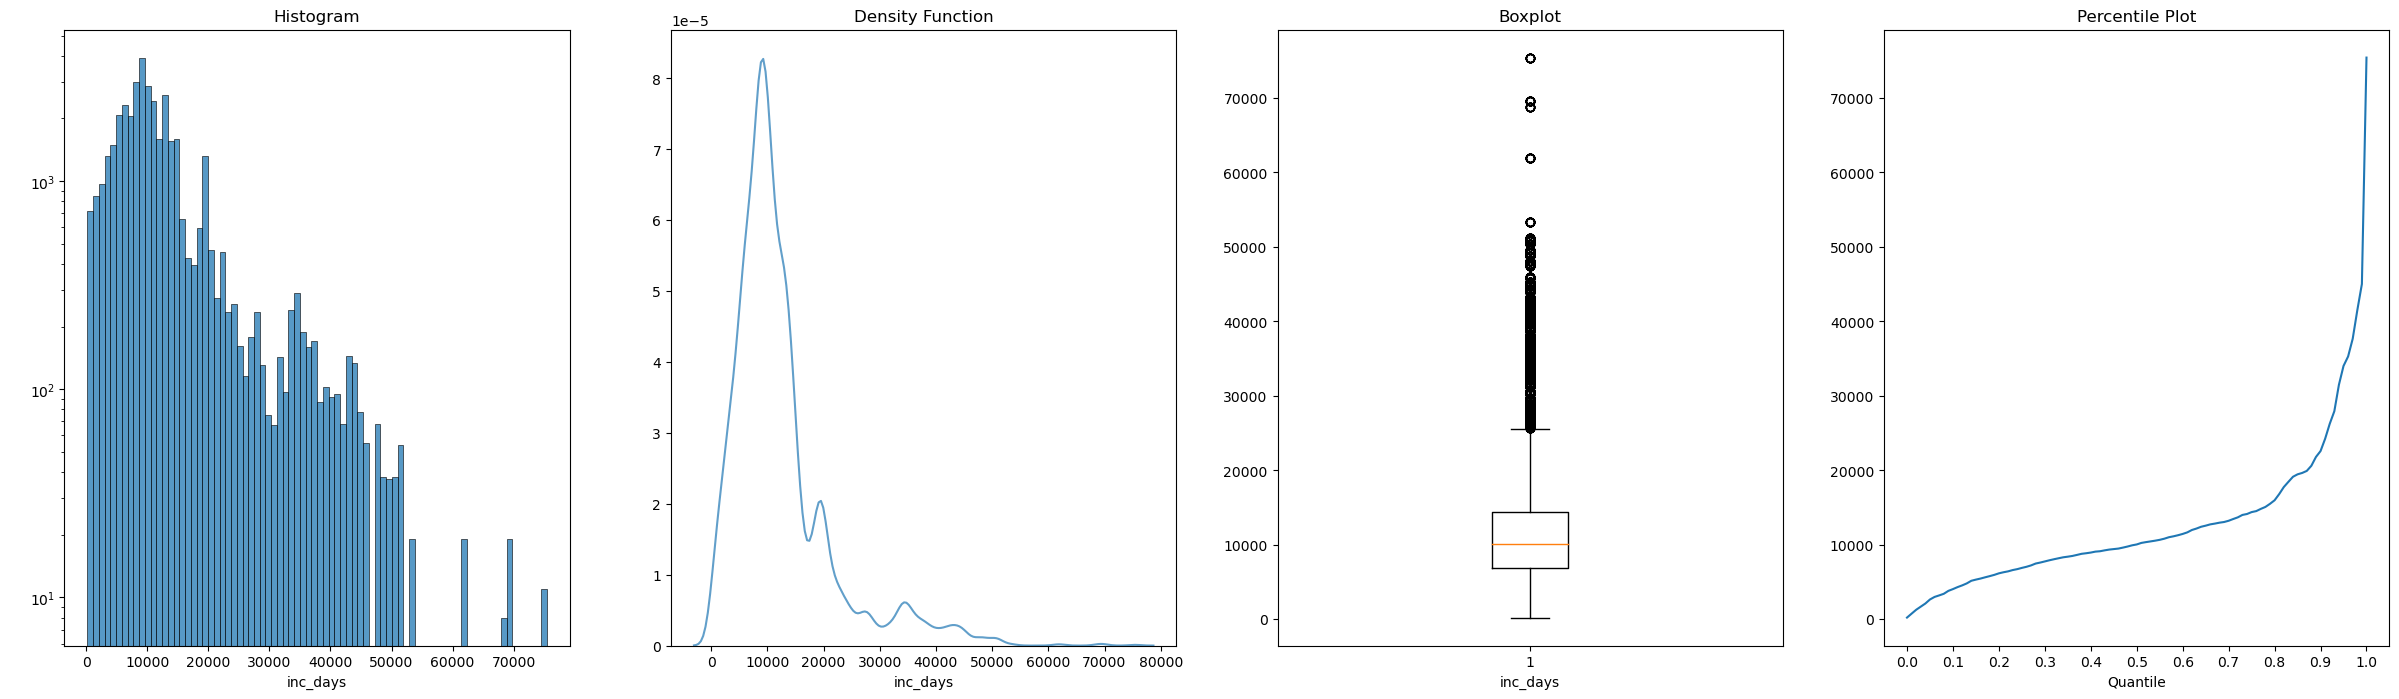

### ipo_days

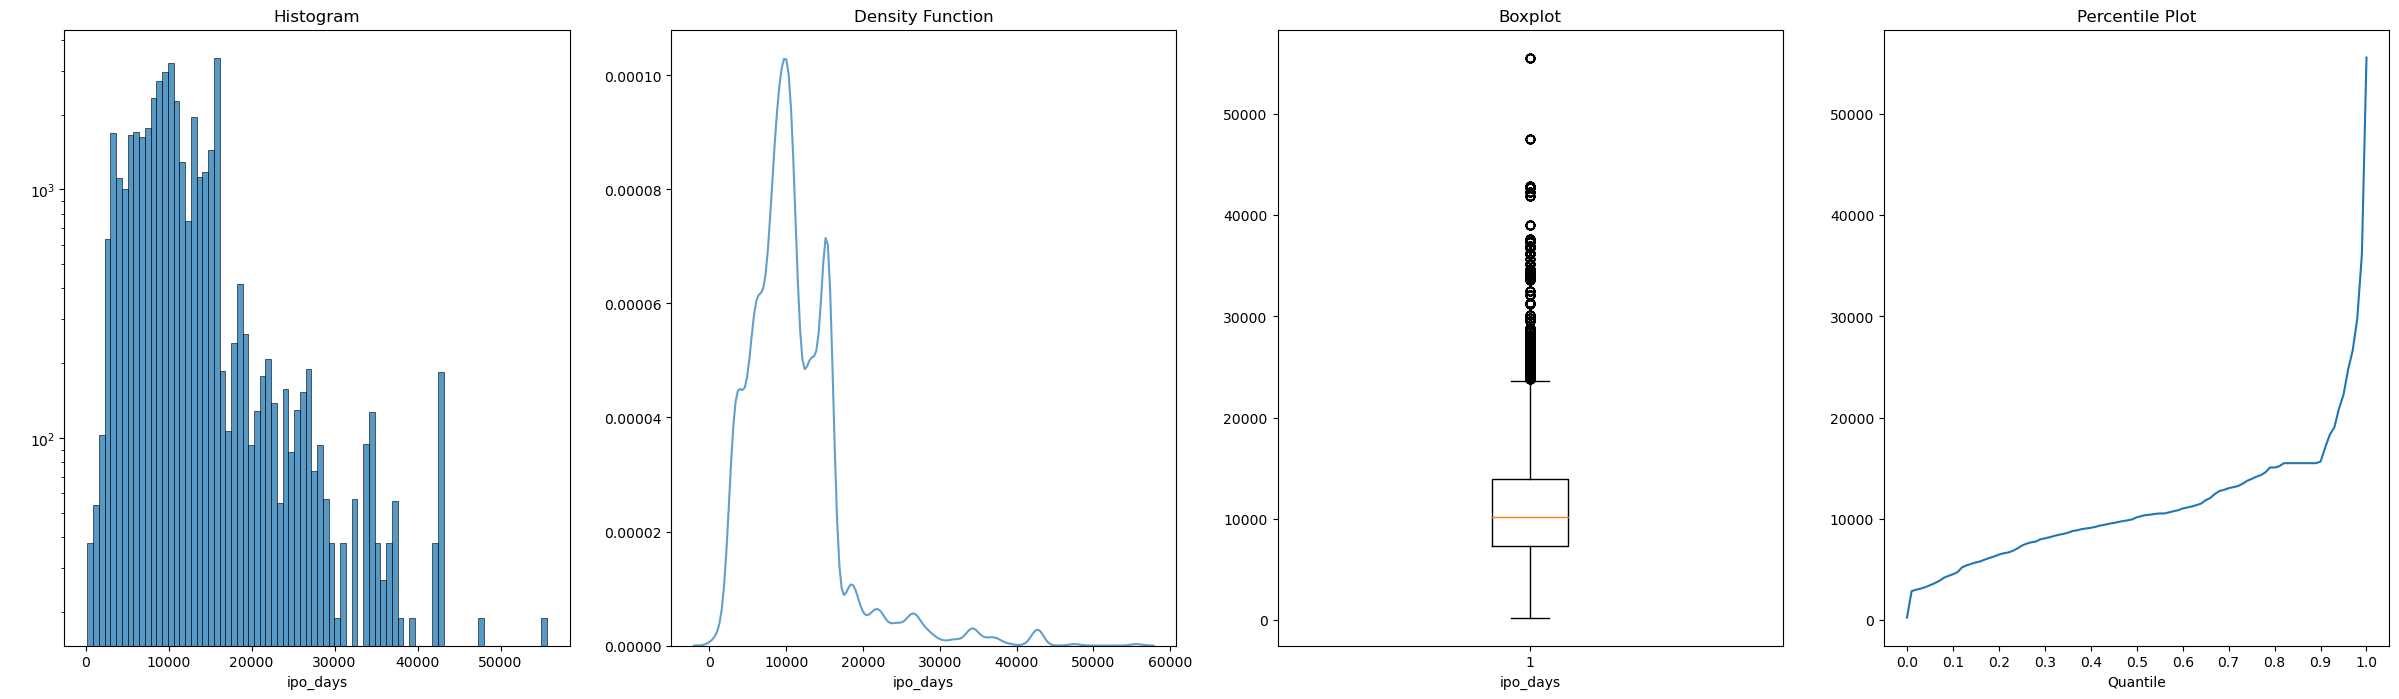

### tau_cop_3y

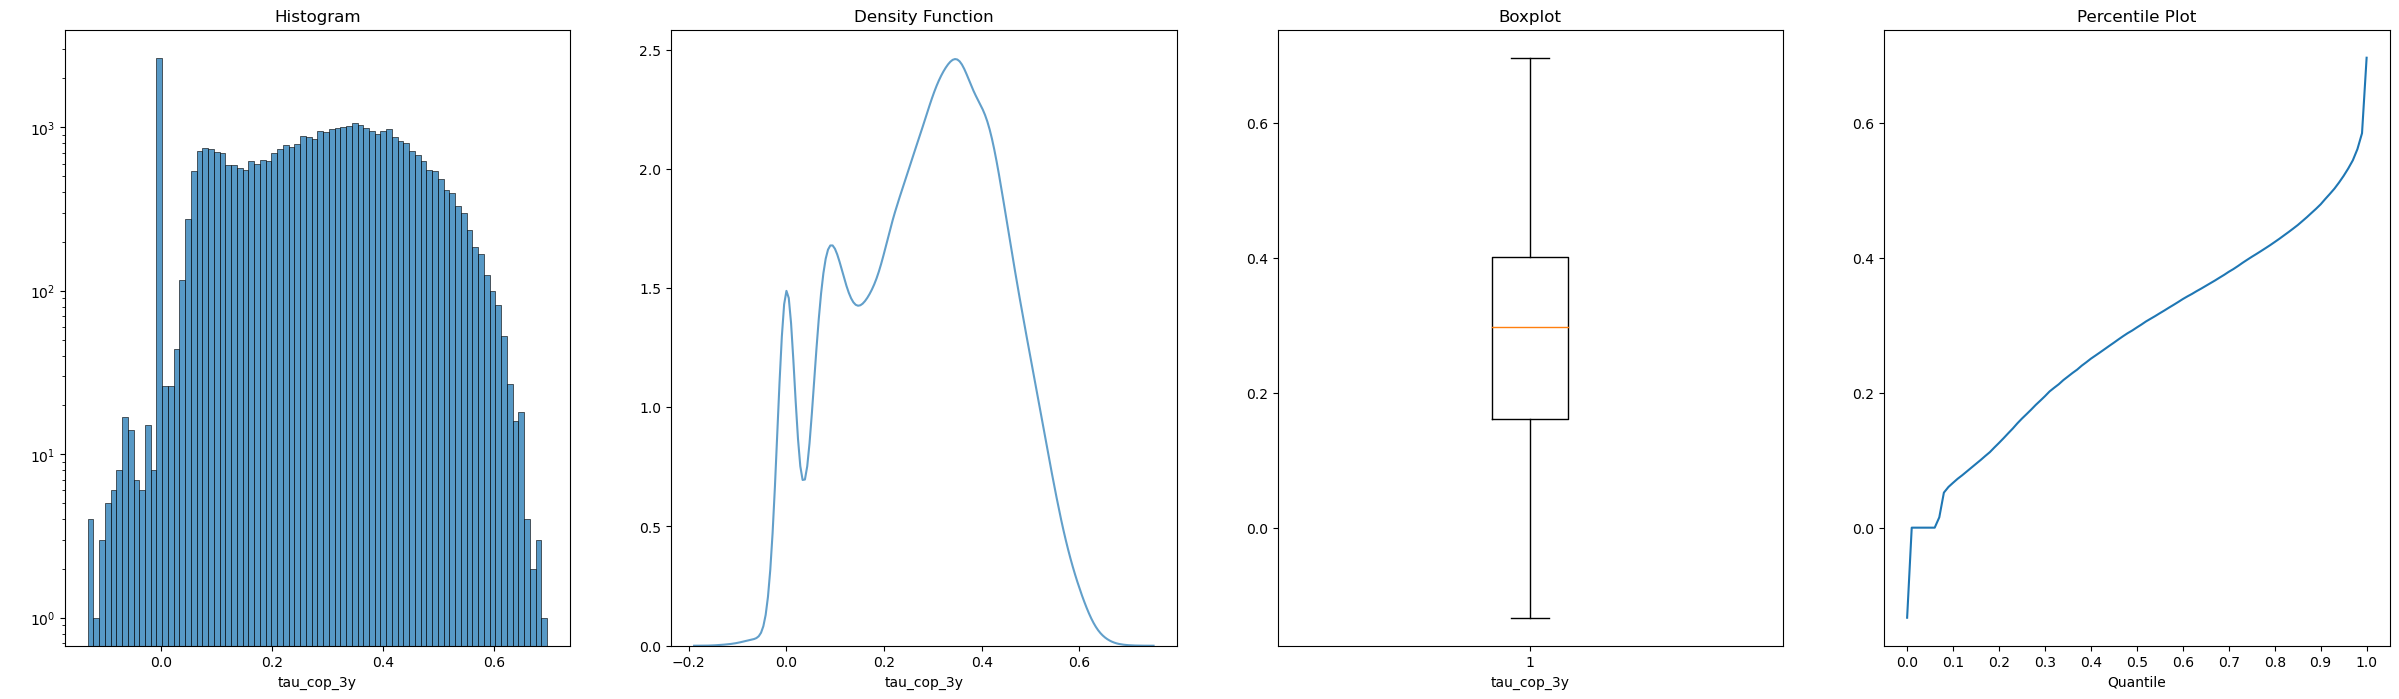

### tau_cop_5y

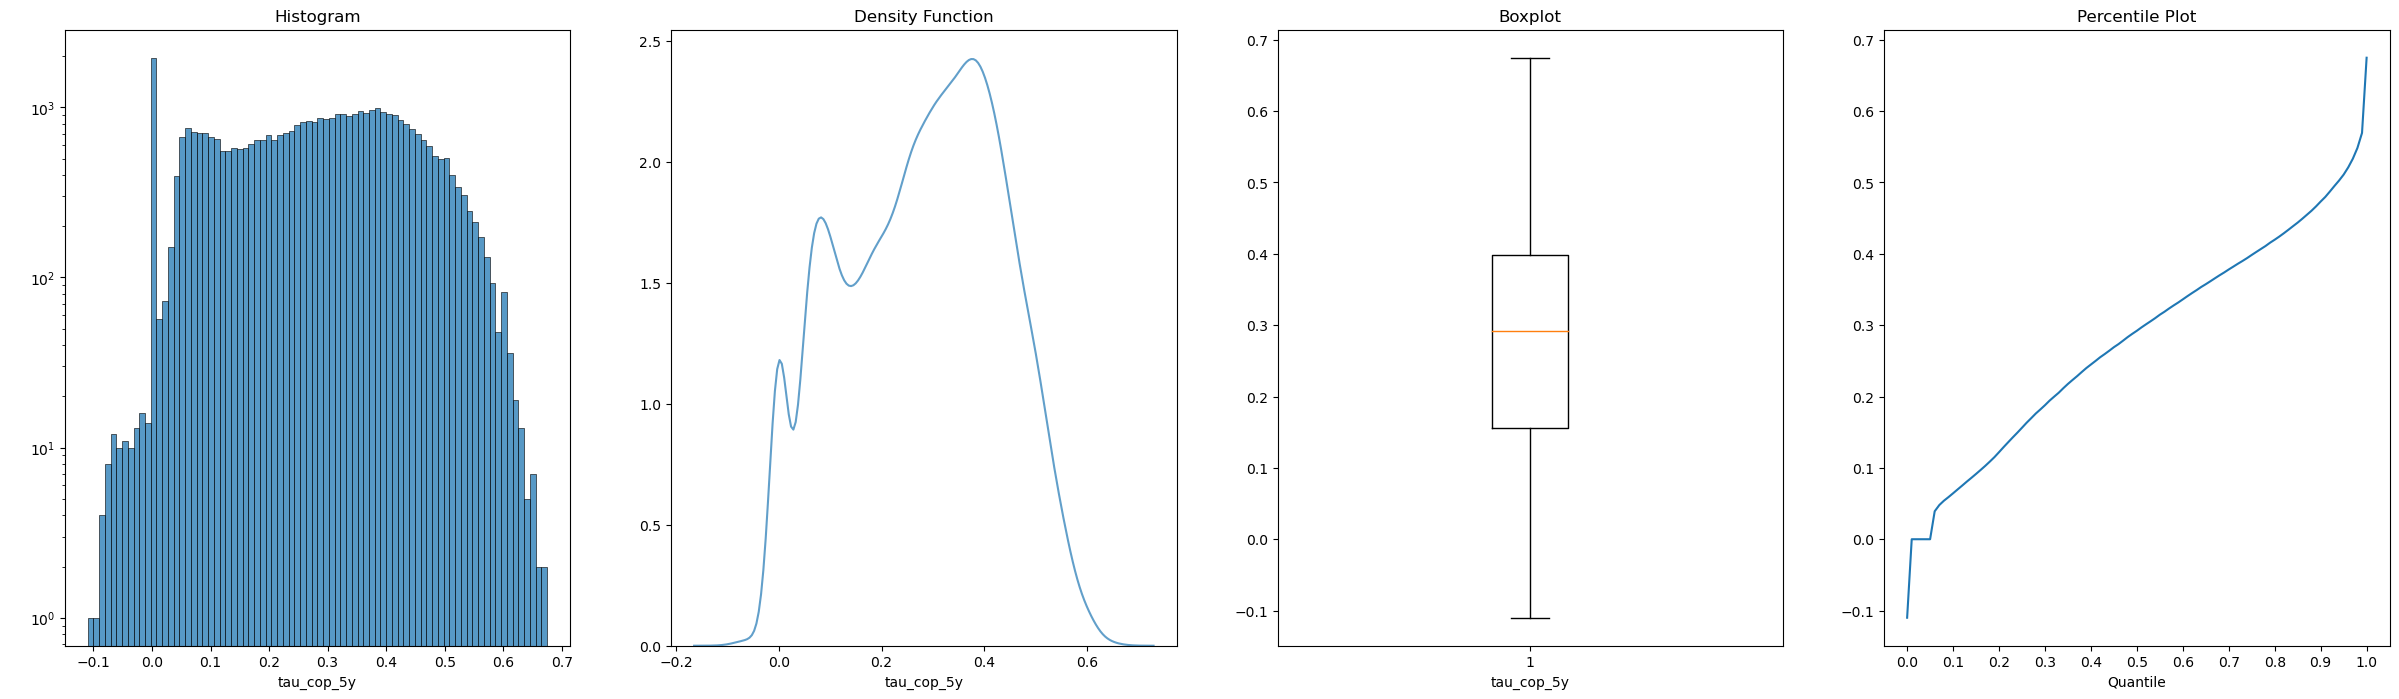

In [40]:
for feature in features:
    display(Markdown('### {feature}'.format(feature=feature)))
    data = data_set[feature].copy()
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
    fig.set_size_inches(30, 8)

    # histogram / distribution
    sns.histplot(data = data_set, x = feature, log_scale = (False, True), bins = 80, ax=ax1)
    ax1.set_xlabel(feature)
    ax1.set_ylabel(' ')
    ax1.set_title('Histogram')

    # density function
    sns.kdeplot(data, alpha=0.7, ax=ax2)
    ax2.set_xlabel(feature)
    ax2.set_ylabel(' ')
    ax2.set_title('Density Function')

    # boxplot
    a = data.copy()
    a = a.dropna()
    ax3.boxplot(a)
    ax3.set_xlabel(feature)
    ax3.set_ylabel(' ')
    ax3.set_title('Boxplot')

    quantiles = [data.quantile(el) for el in np.arange(0,1 + 0.01,0.01)]
    ax4.plot(np.arange(0,1 + 0.01,0.01), quantiles)
    ax4.set_xticks(np.arange(0,1 + 0.1,0.1))
    ax4.set_xlabel('Quantile')
    ax4.set_ylabel(' ')
    ax4.set_title('Percentile Plot')

    plt.show()

In [41]:
correct_hi_low = ['rtass', 'tsheq', 'comeq', 'noa', 'wc', 'ndebt', 'ncfo', 'levfcf', 'nincam', 'gp', 'trev',
                  'ebit', 'roe', 'roce', 'rnoa', 'ebitmarg', 'oips', 'cfps', 'ros_c', 'prof_c', 'finlev_c']
correct_hi     = ['debt', 'tass', 'tlia', 'comsi', 'capex', 'shouts', 'mc', 'ptbvps']

### Elimination of Outliers

In [42]:
for feature in correct_hi_low:
    eleminate_low = data_set[data_set[feature] < data_set[feature].quantile(0.01)].index.values
    eleminate_hi = data_set[data_set[feature] > data_set[feature].quantile(0.99)].index.values
    
    data_set.loc[eleminate_low, feature] = np.nan
    data_set.loc[eleminate_hi, feature] = np.nan

In [43]:
for feature in correct_hi:
    eleminate = data_set[data_set[feature] > data_set[feature].quantile(0.99)].index.values
    data_set.loc[eleminate, feature] = np.nan

In [44]:
data_set = data_set.dropna()
data_set.isna().sum()

ric               0
year              0
date              0
isin              0
symbol            0
naics             0
fy_end_date       0
tau_cop_3y        0
tau_cop_5y        0
fam_target_ori    0
rot_target_ori    0
tau_target_ori    0
par_target_ori    0
year_hor          0
tau_target_hor    0
fam_target_hor    0
rot_target_hor    0
par_target_hor    0
debt              0
tass              0
rtass             0
tlia              0
tsheq             0
comeq             0
comsi             0
noa               0
wc                0
ndebt             0
capex             0
ncfo              0
levfcf            0
nincam            0
gp                0
trev              0
ebit              0
roe               0
roce              0
rnoa              0
ebitmarg          0
shouts            0
mc                0
ptbvps            0
oips              0
cfps              0
ros_c             0
prof_c            0
finlev_c          0
inc_days          0
ipo_days          0
dtype: int64

### tau_target_ori

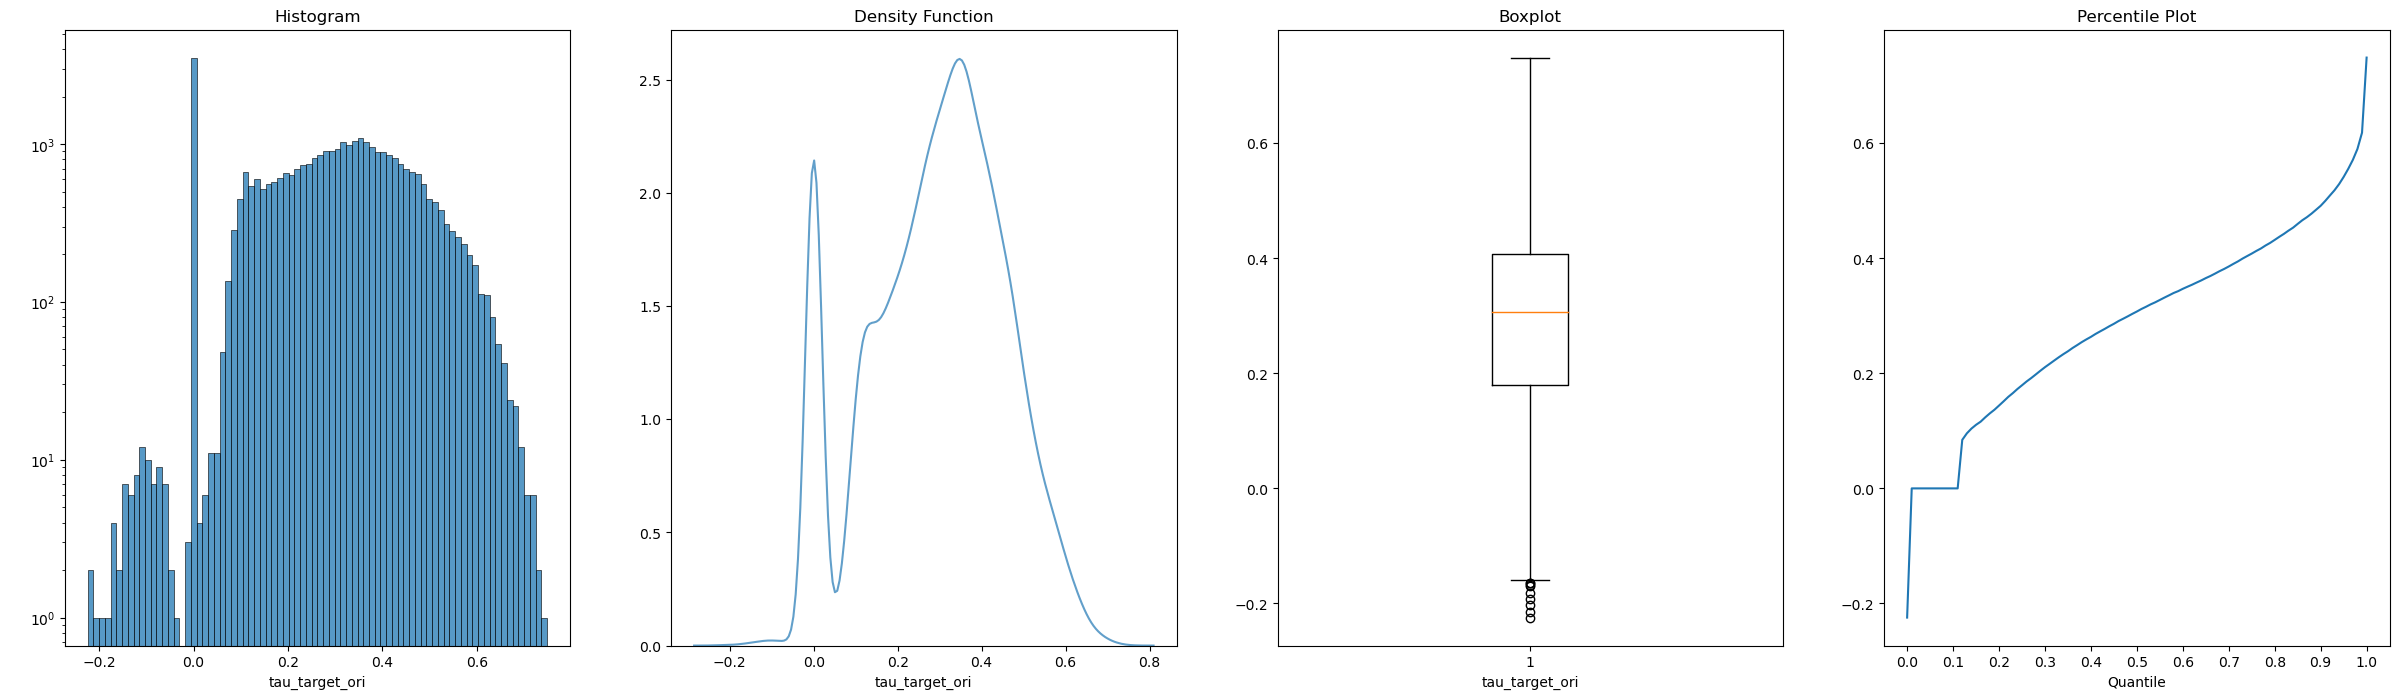

### debt

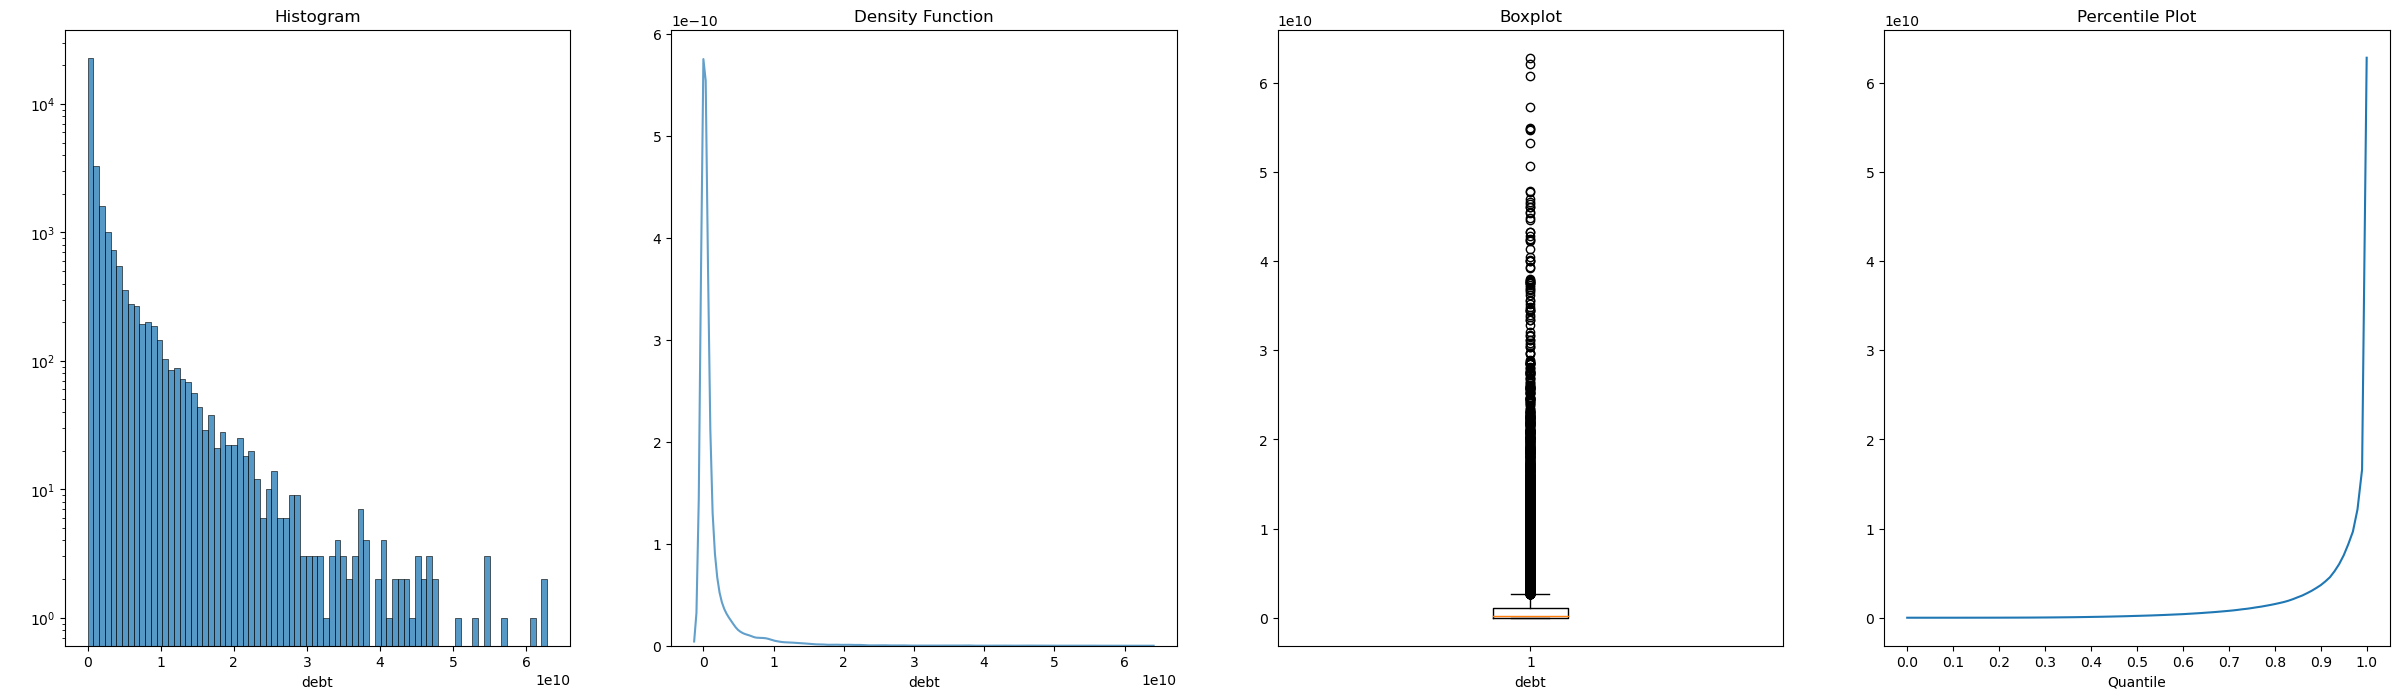

### tass

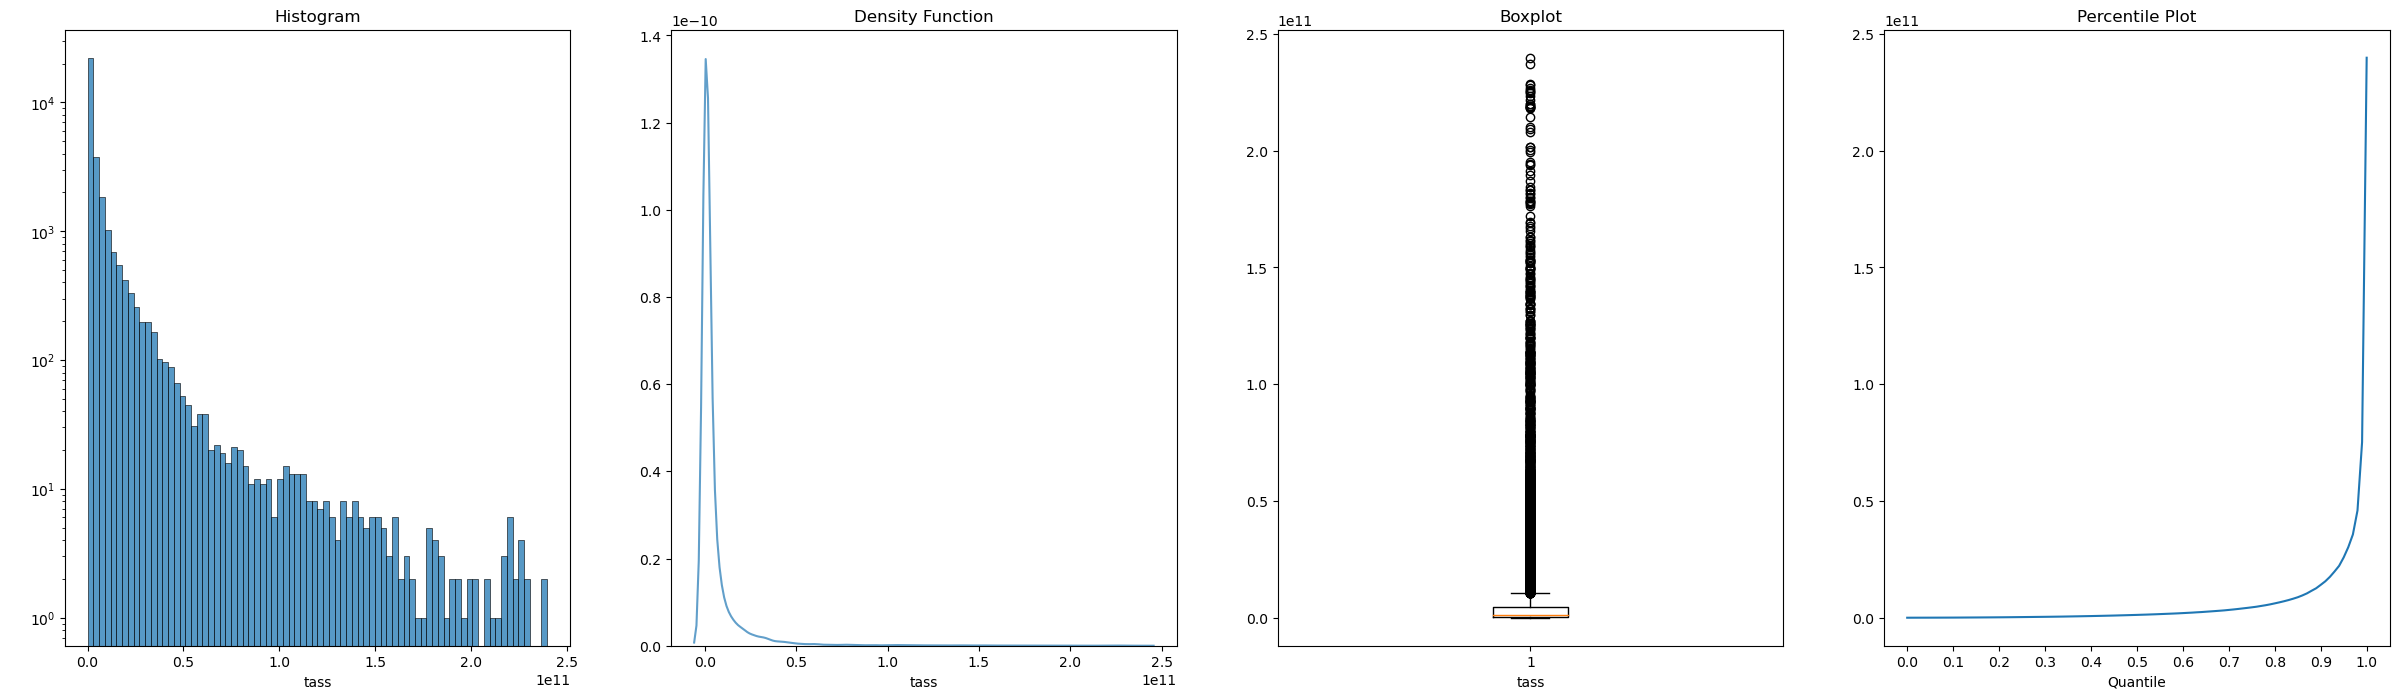

### rtass

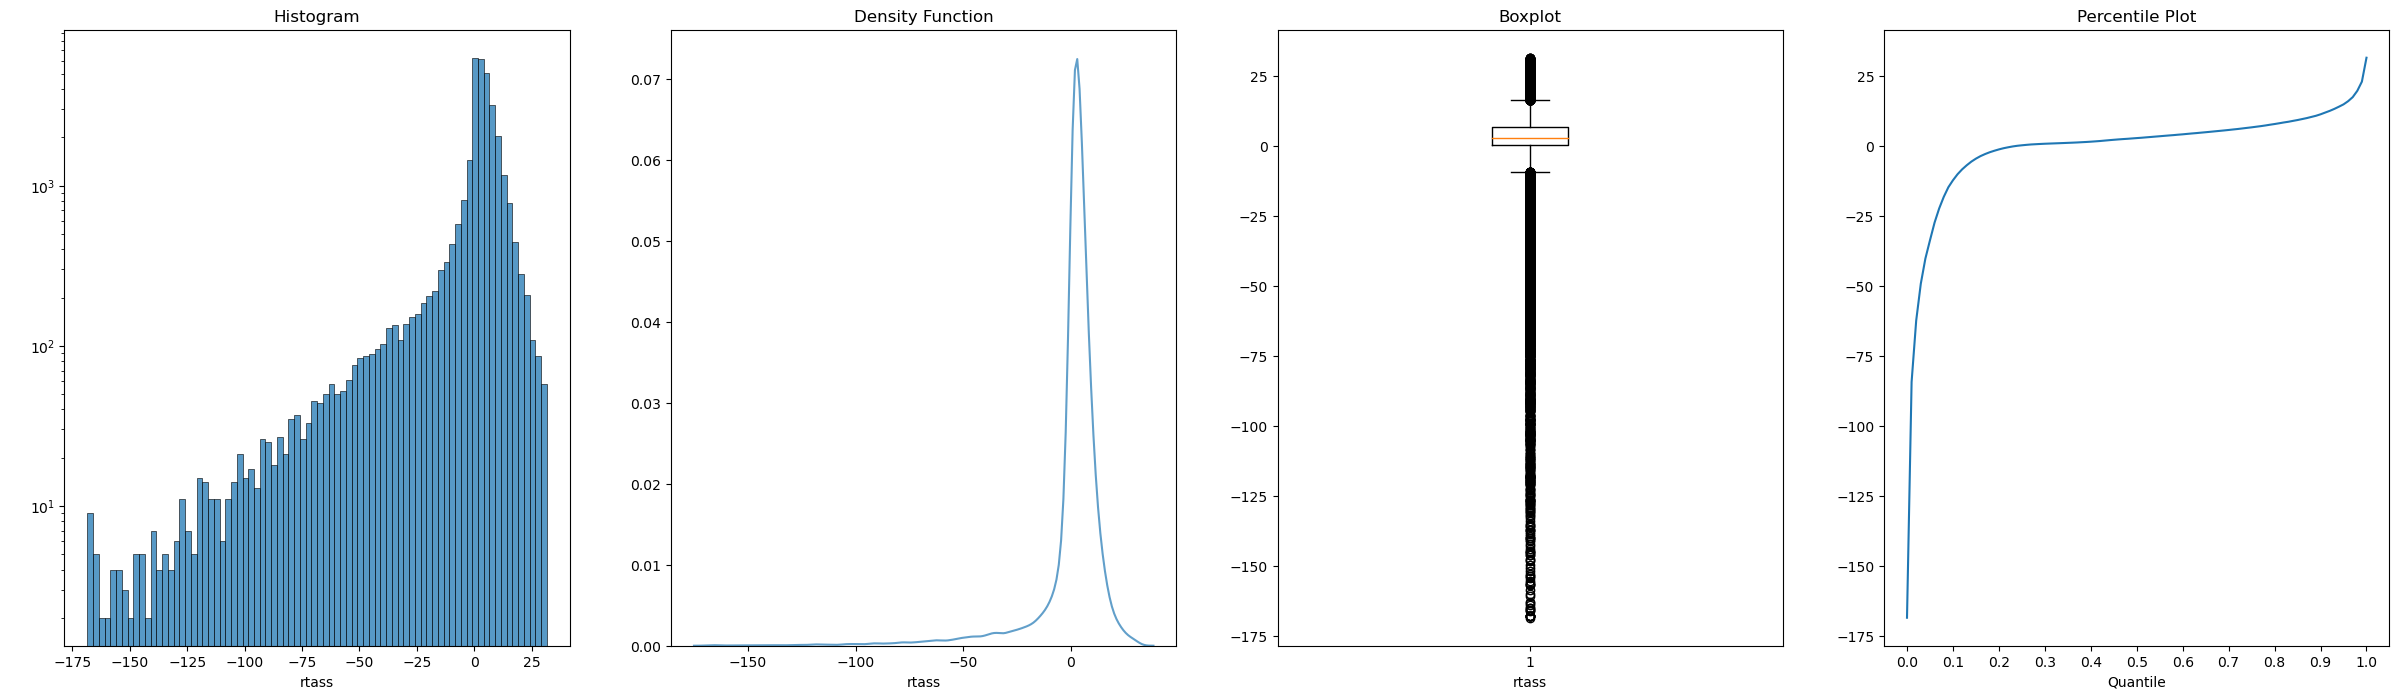

### tlia

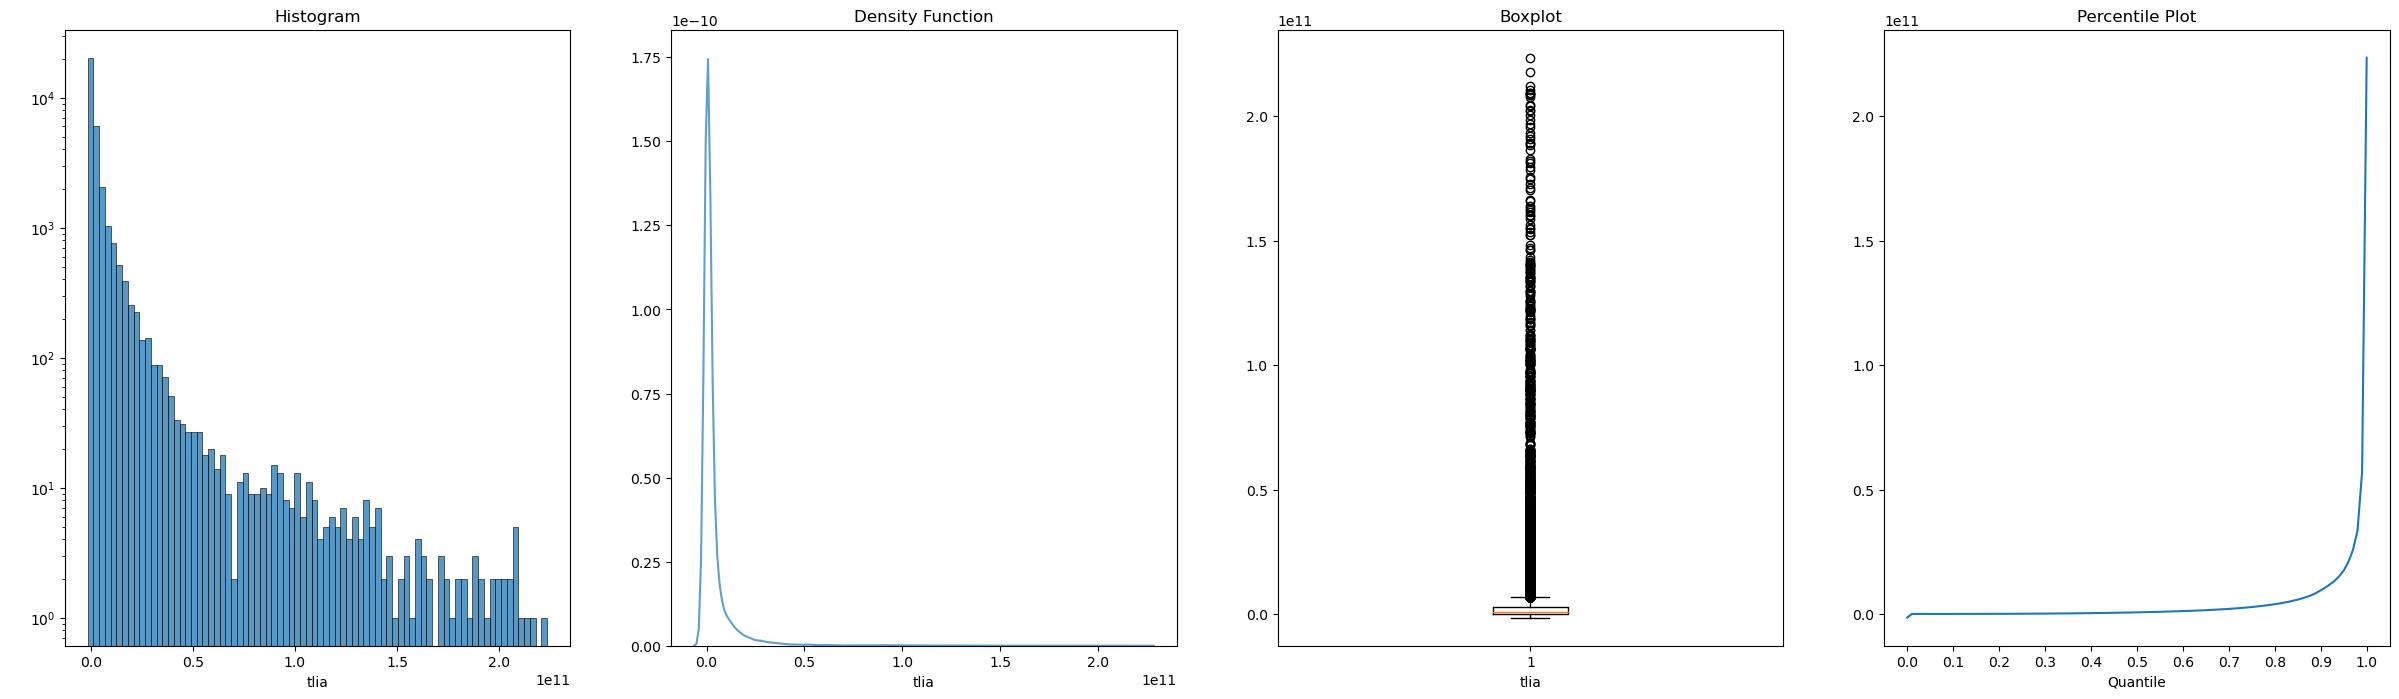

### tsheq

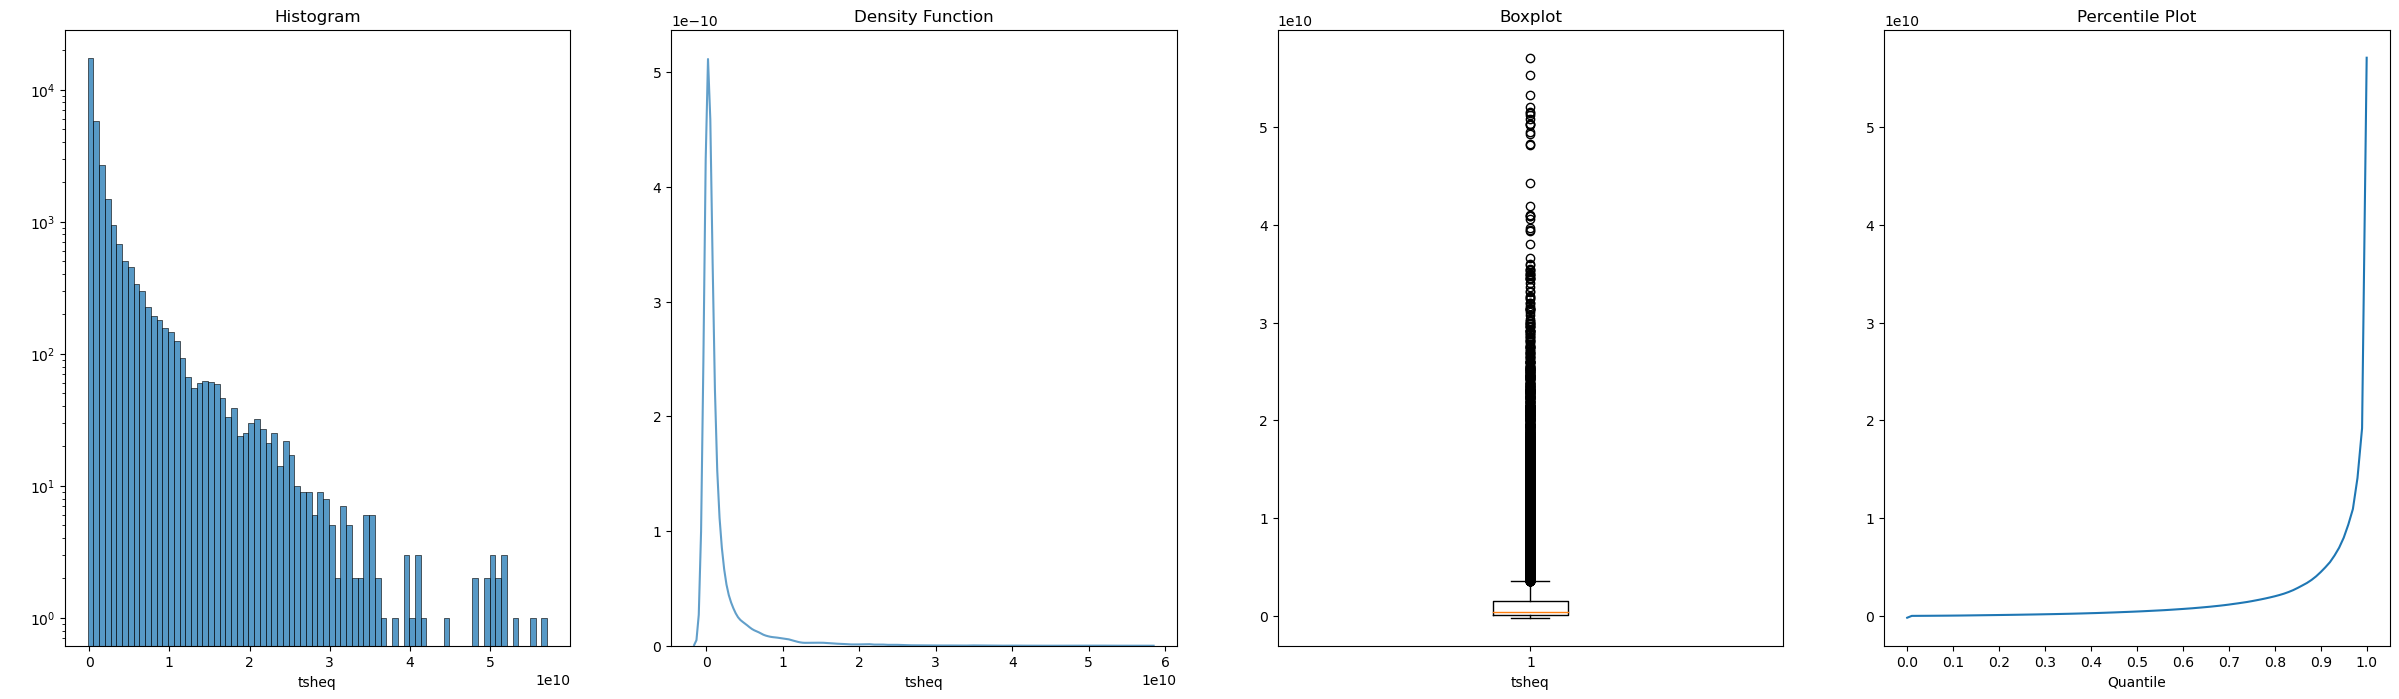

### comeq

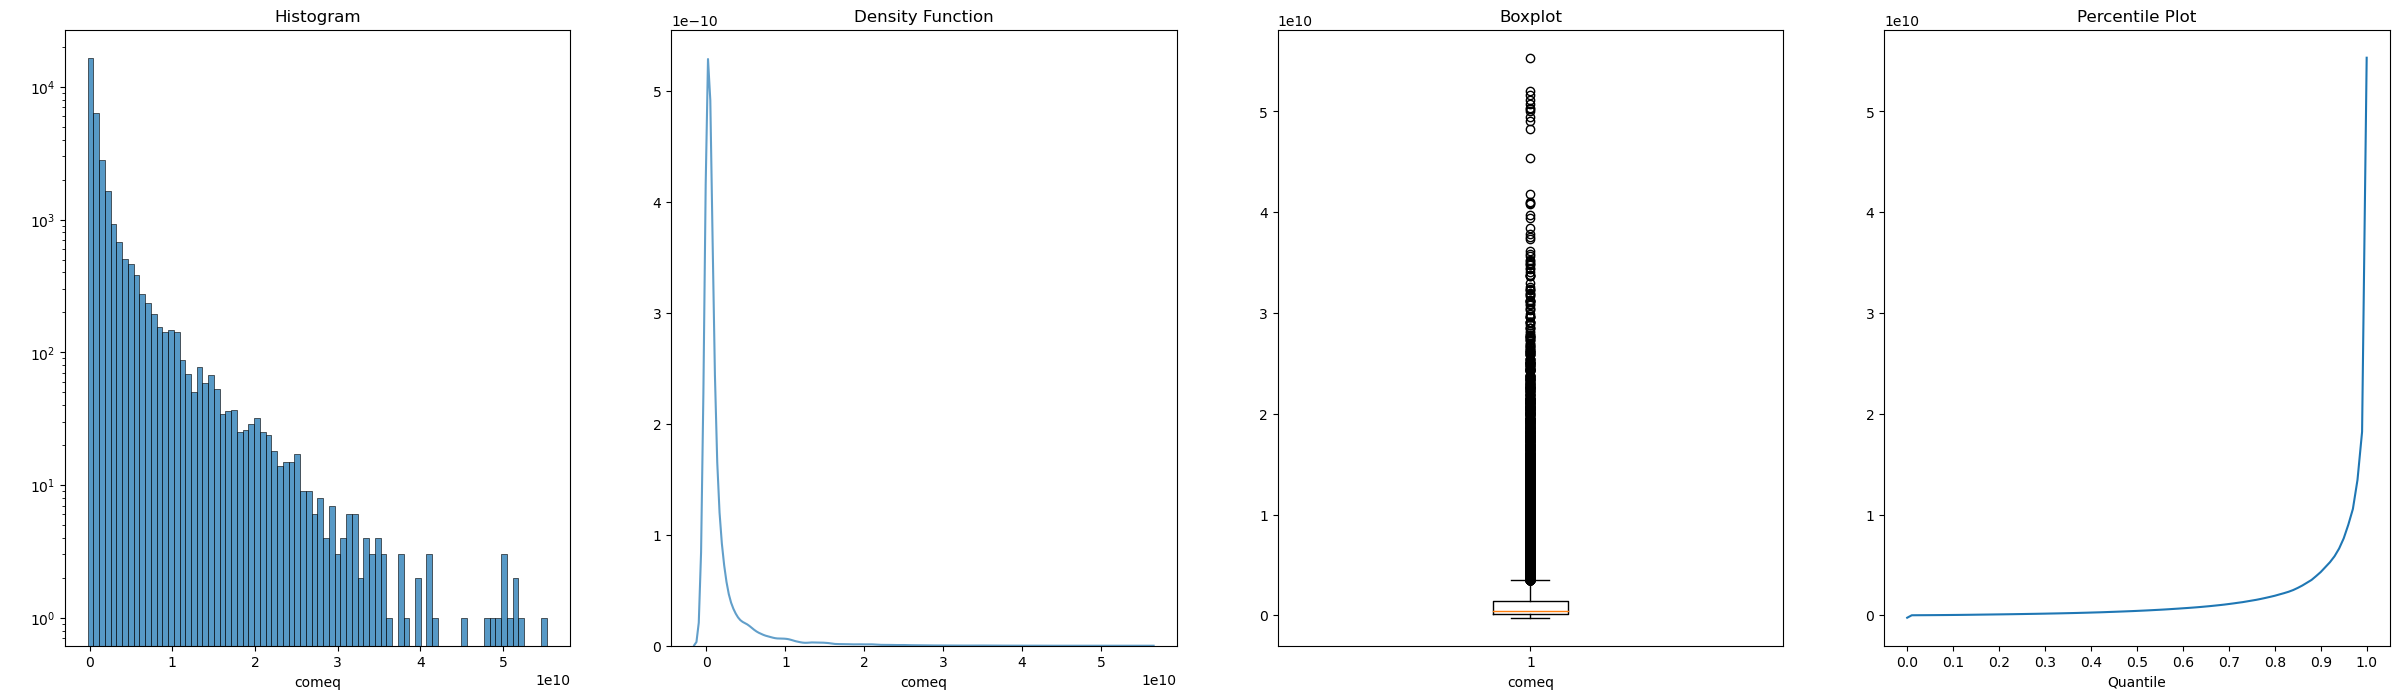

### comsi

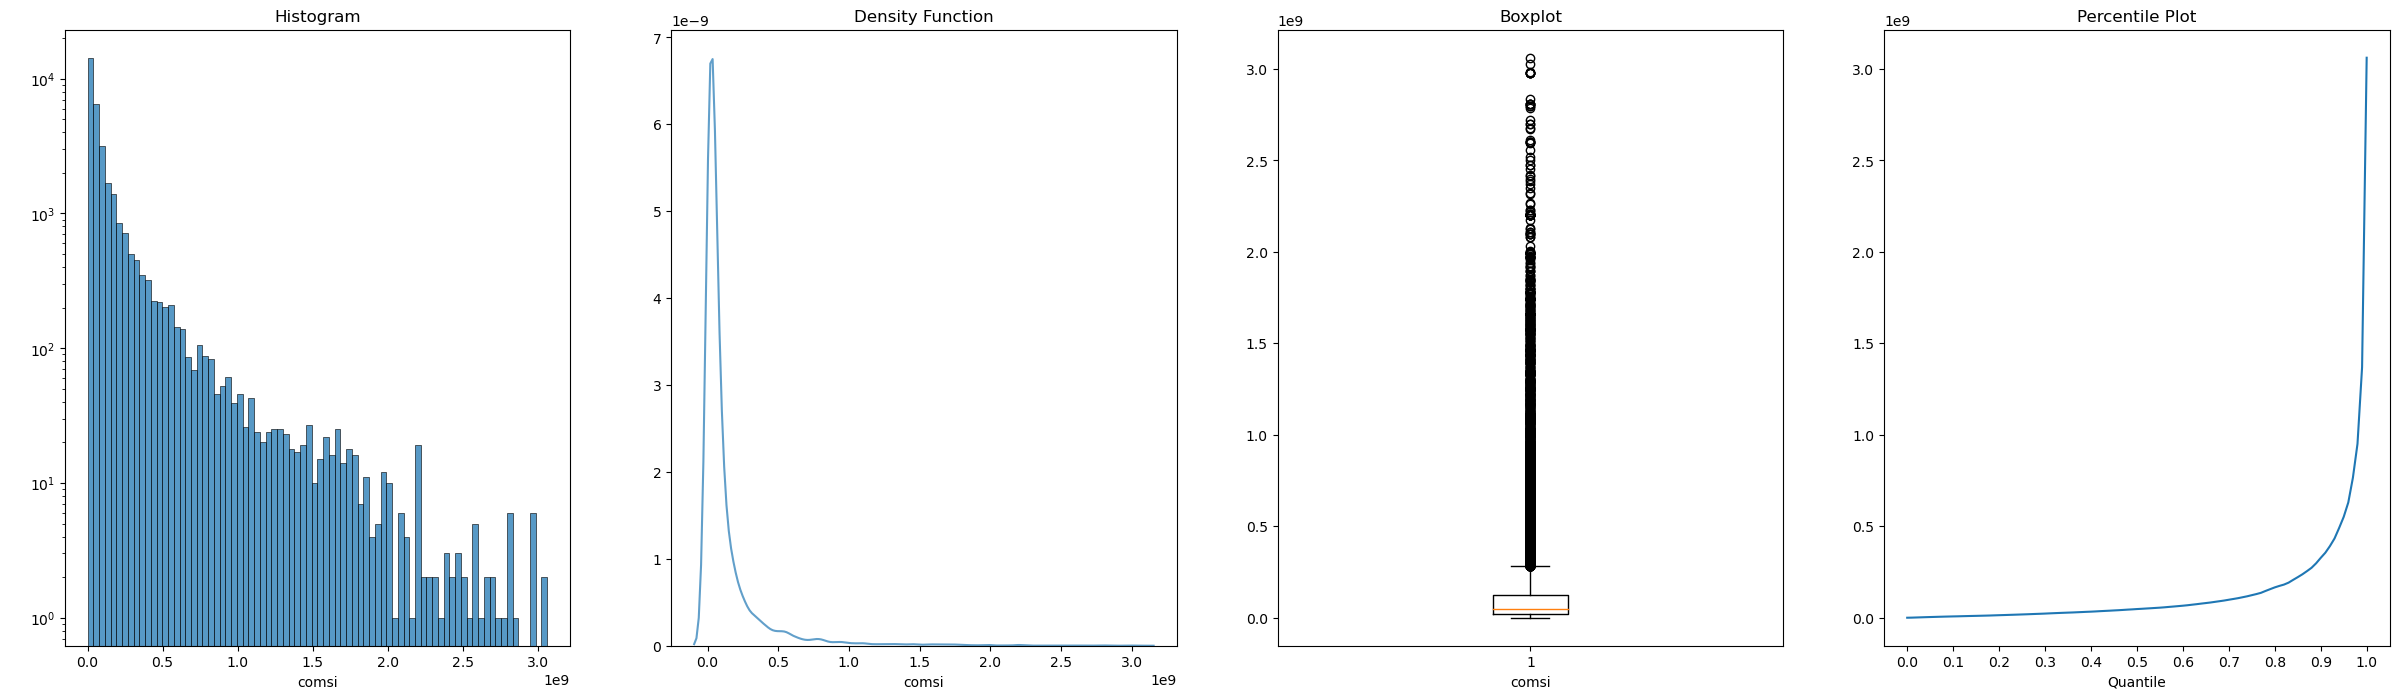

### noa

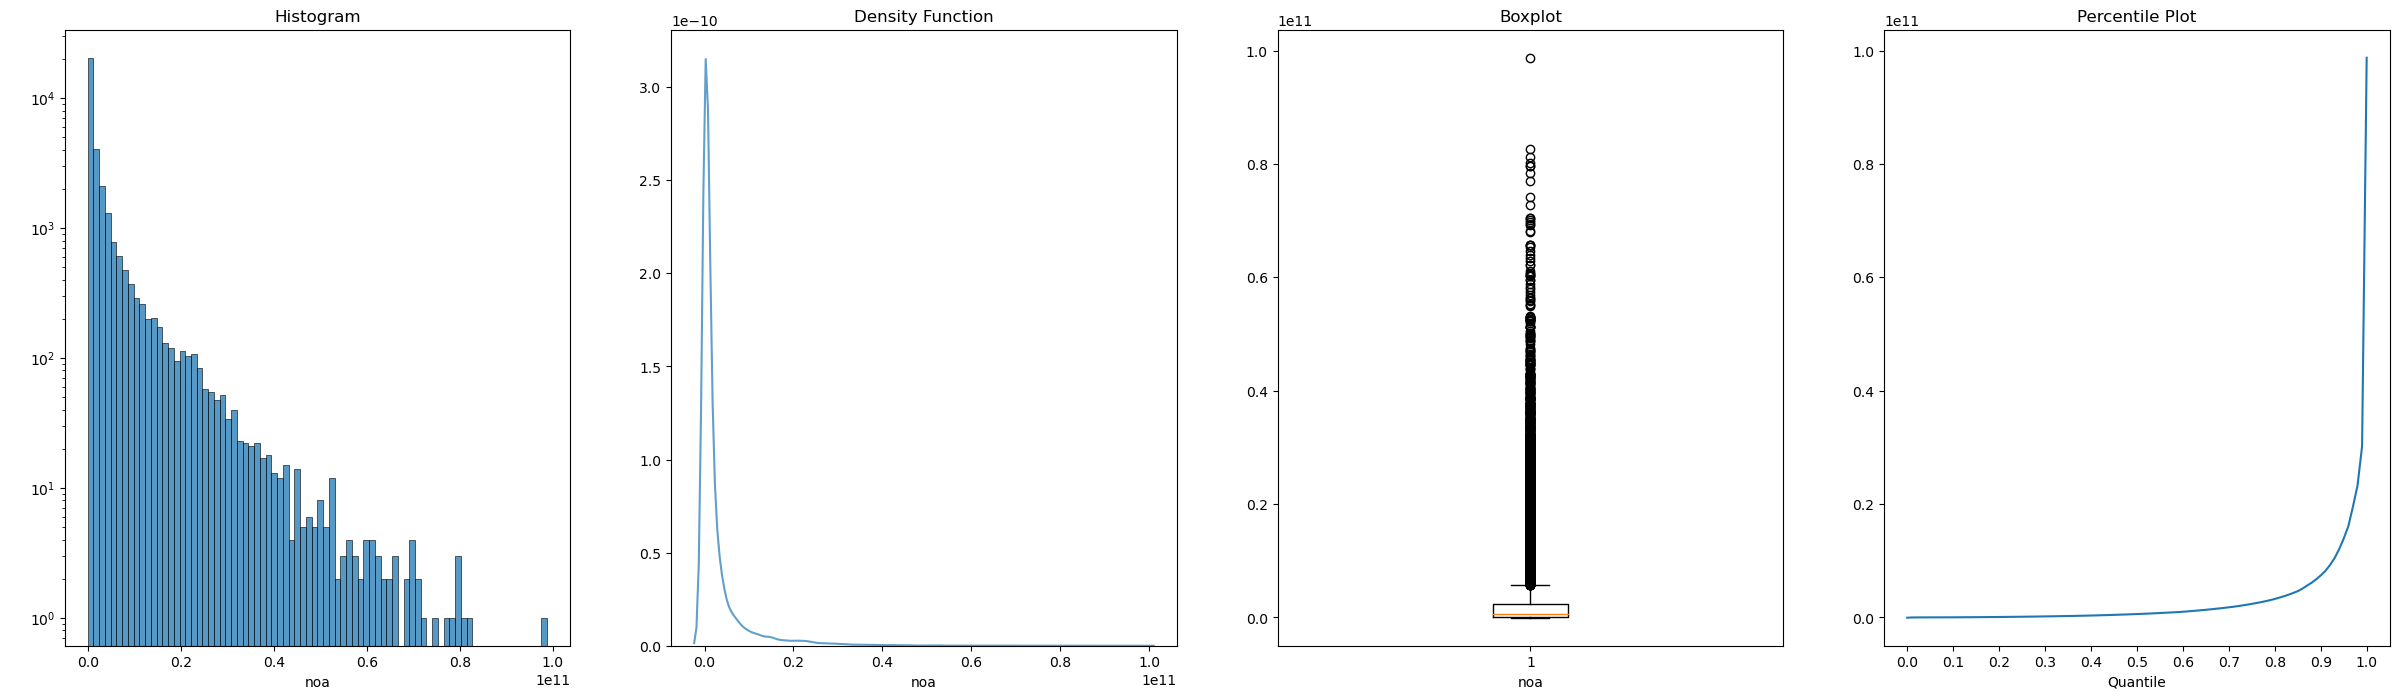

### wc

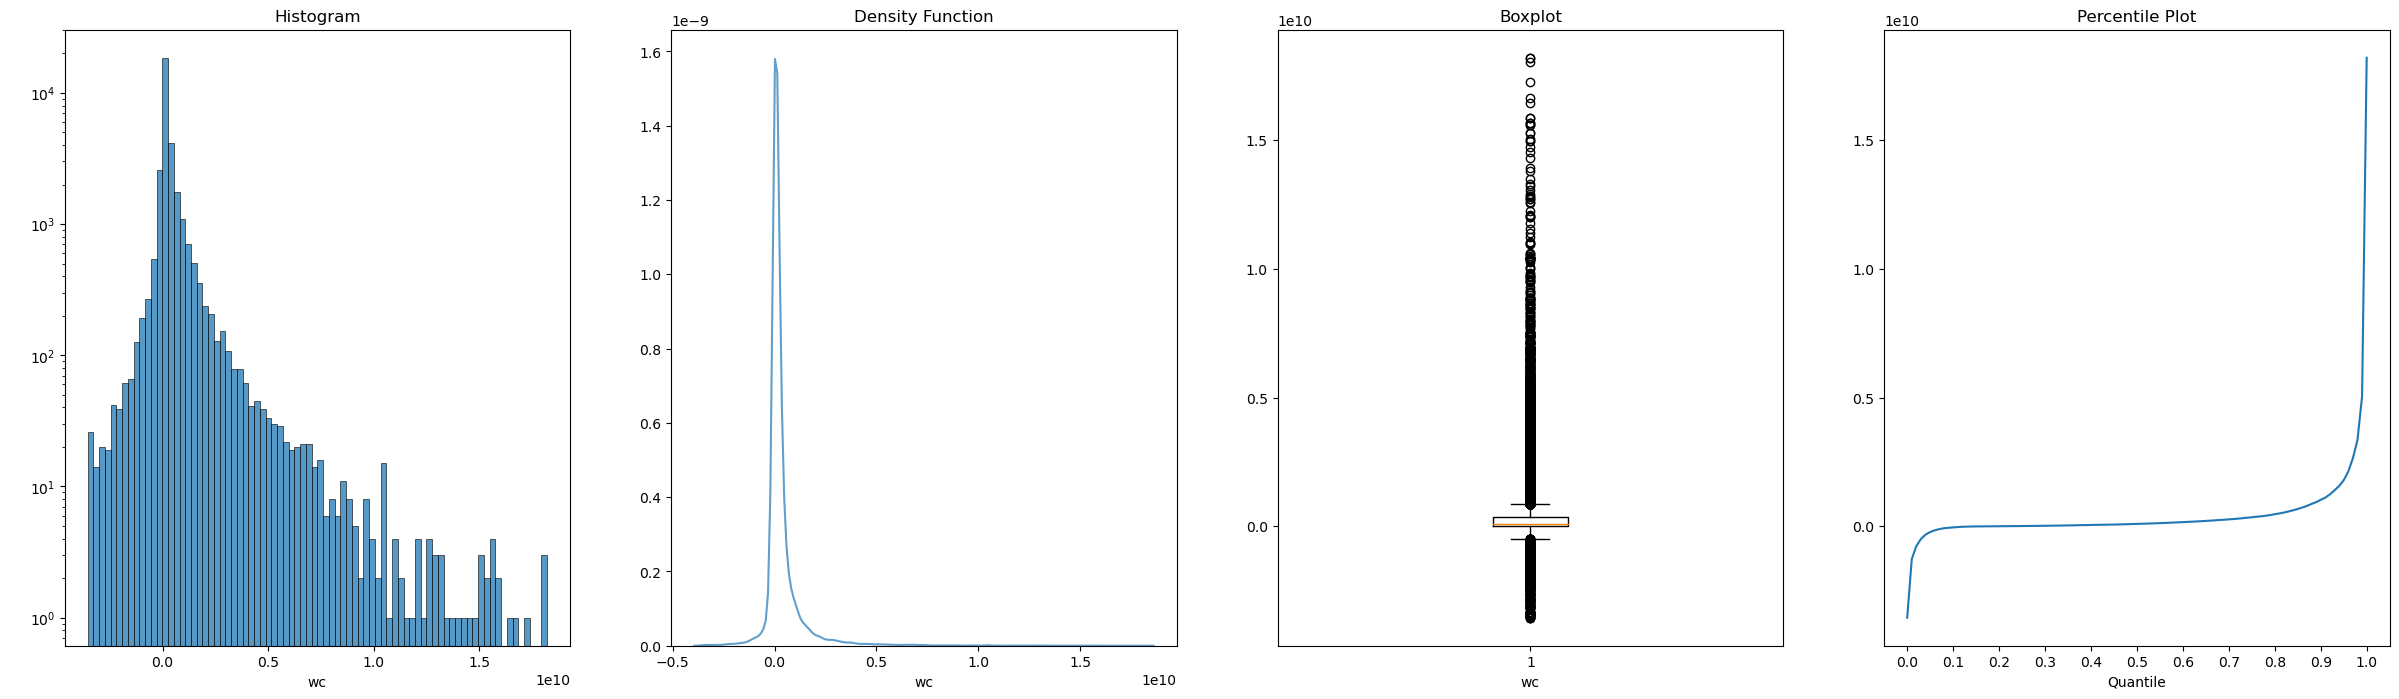

### ndebt

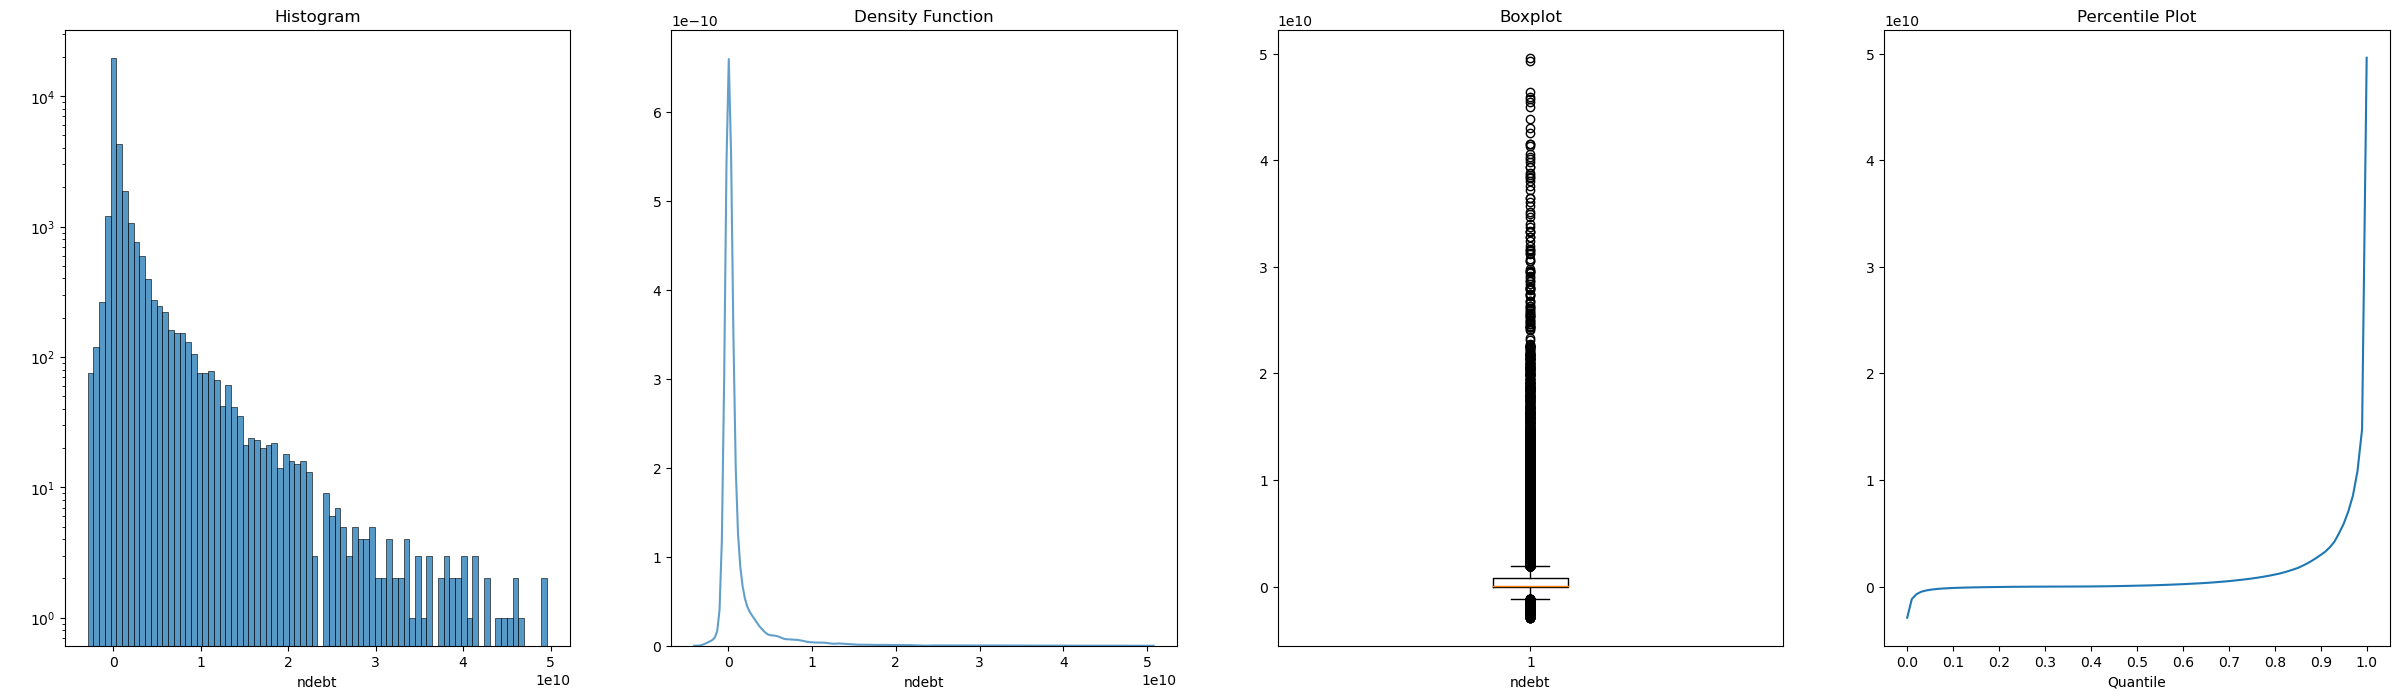

### capex

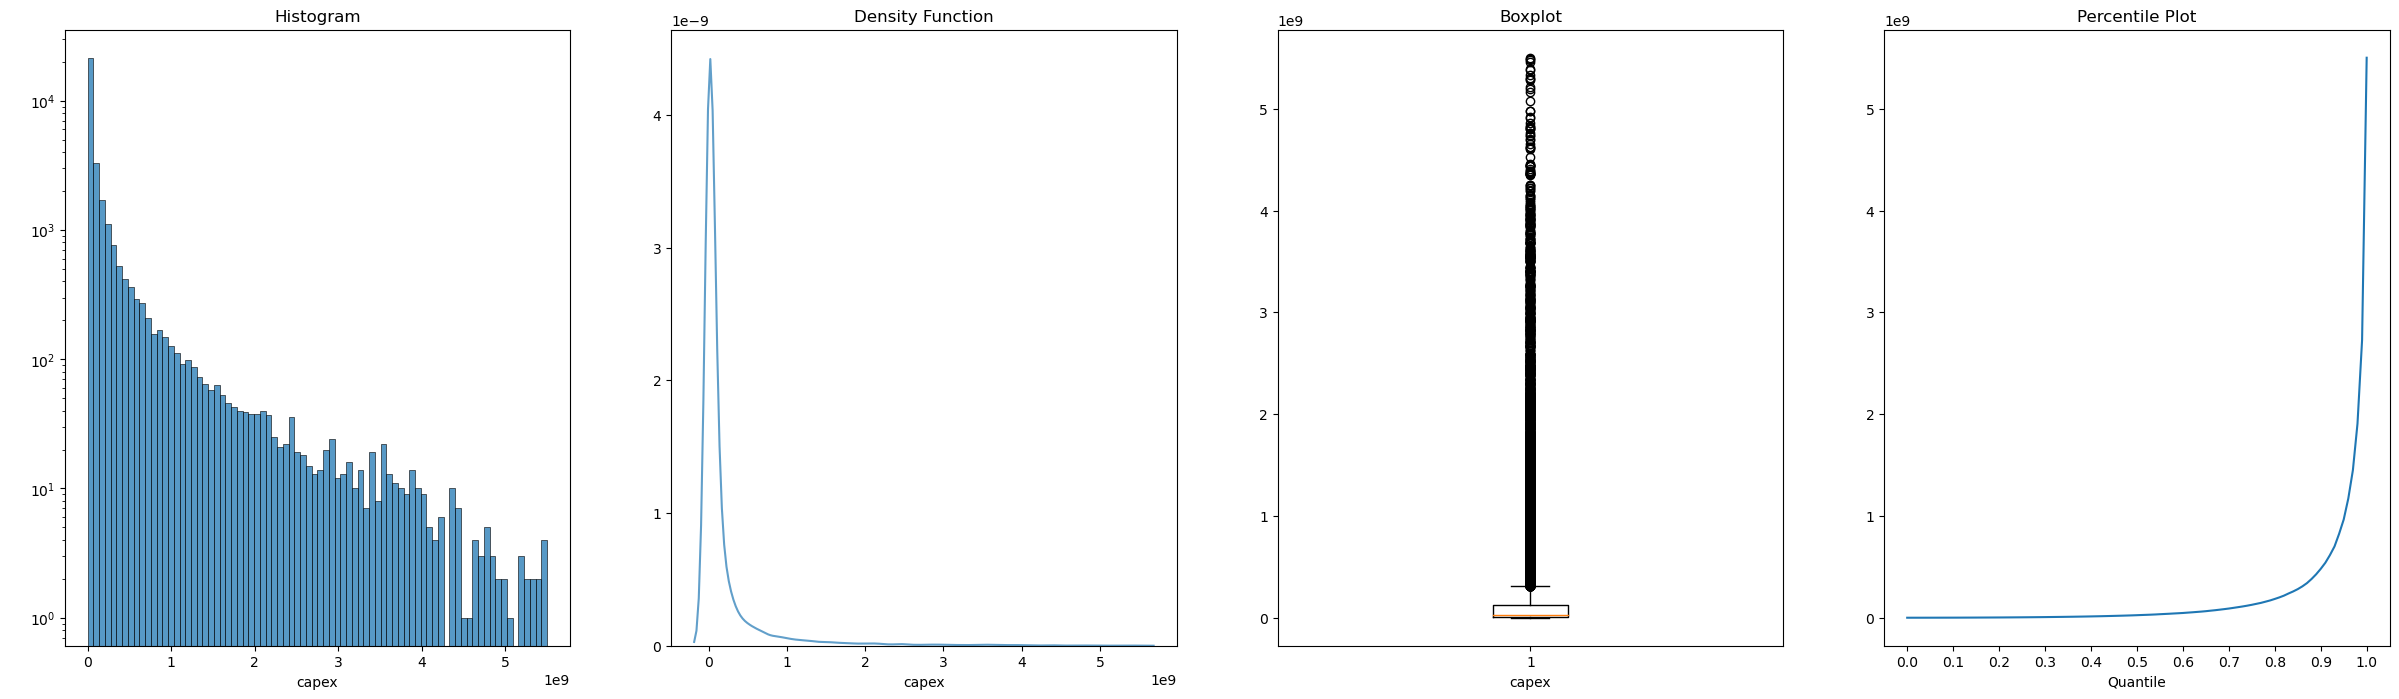

### ncfo

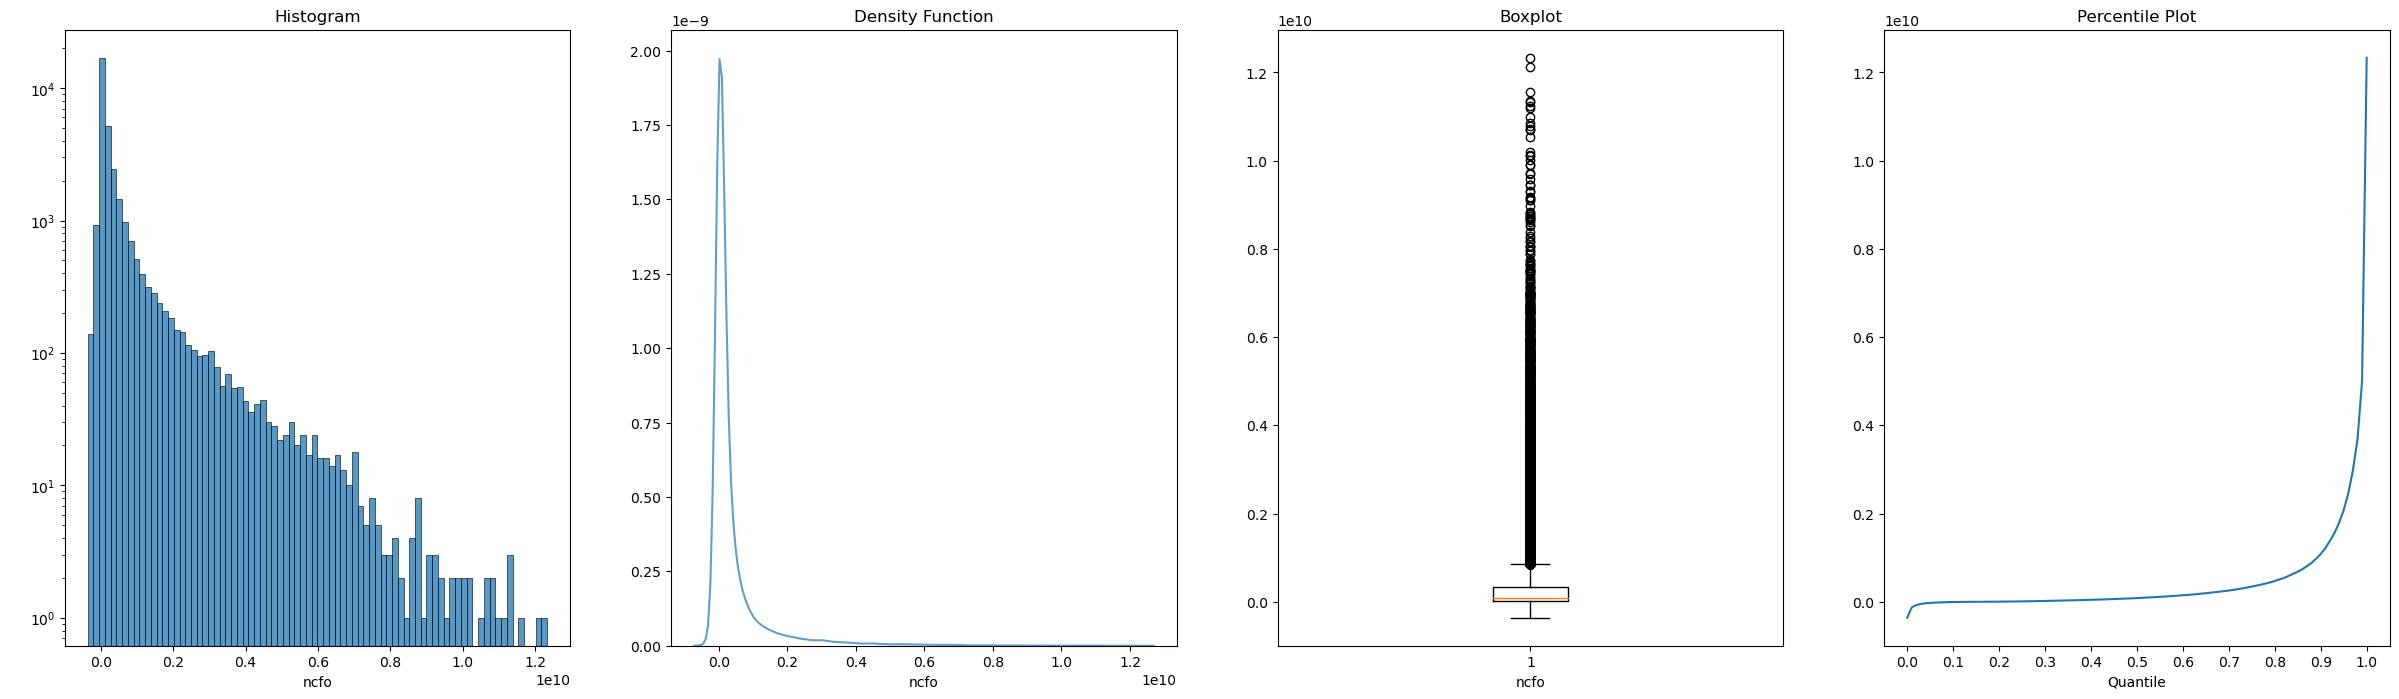

### levfcf

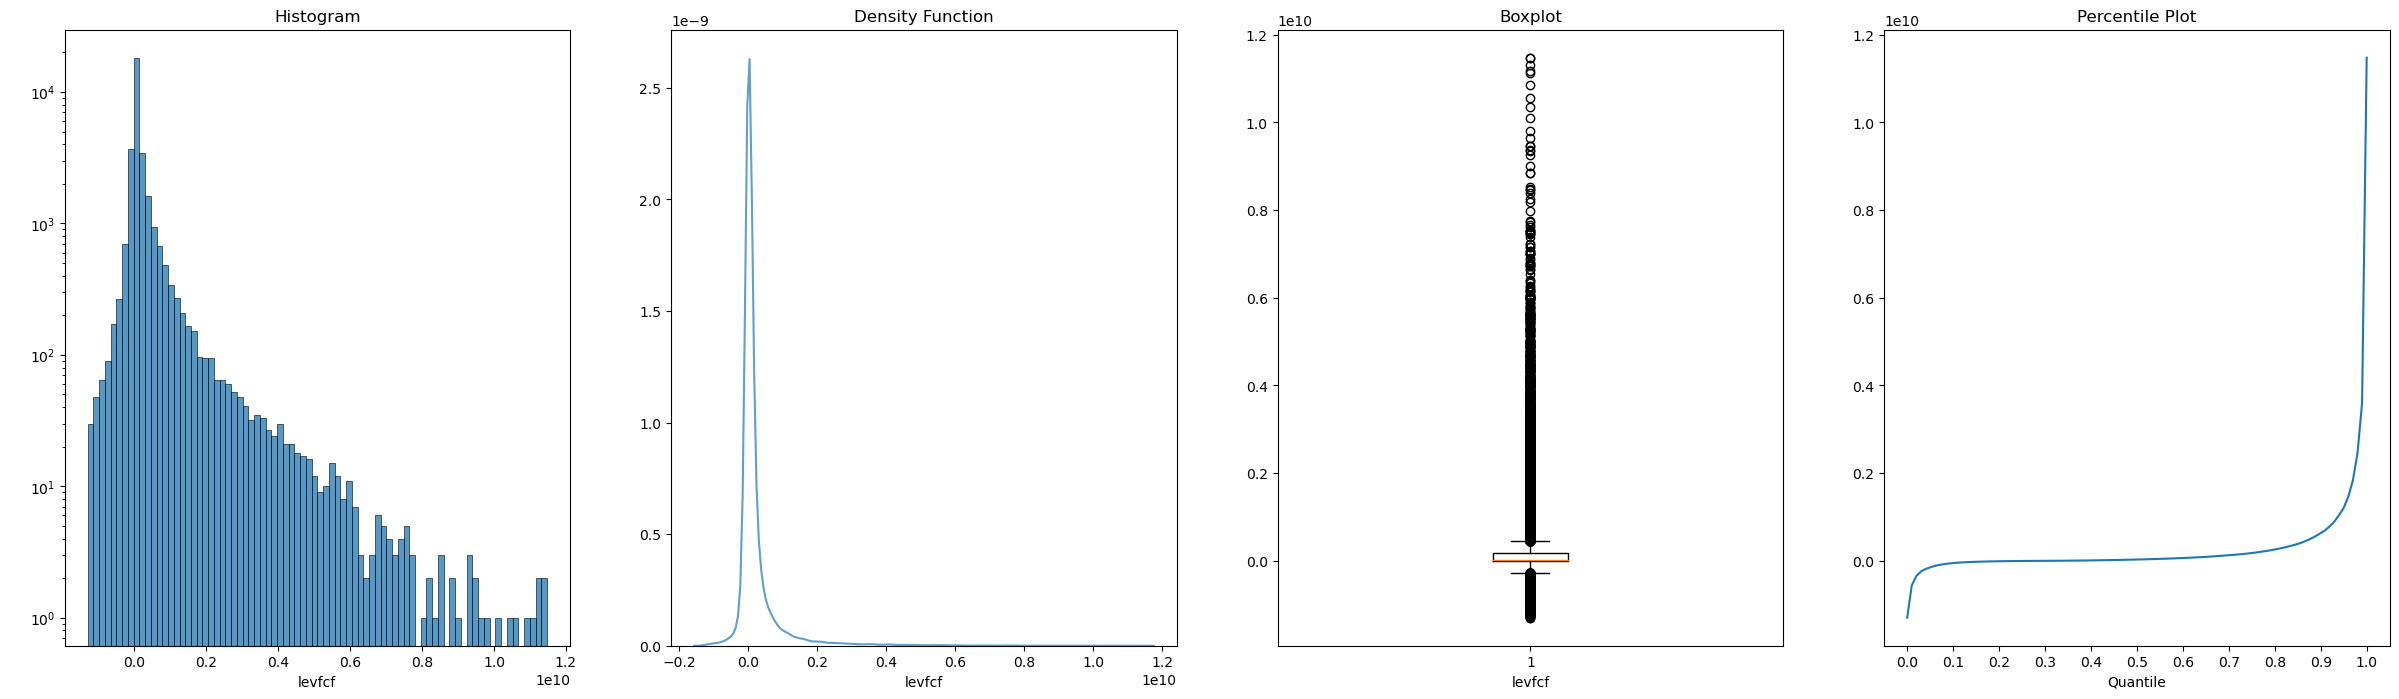

### nincam

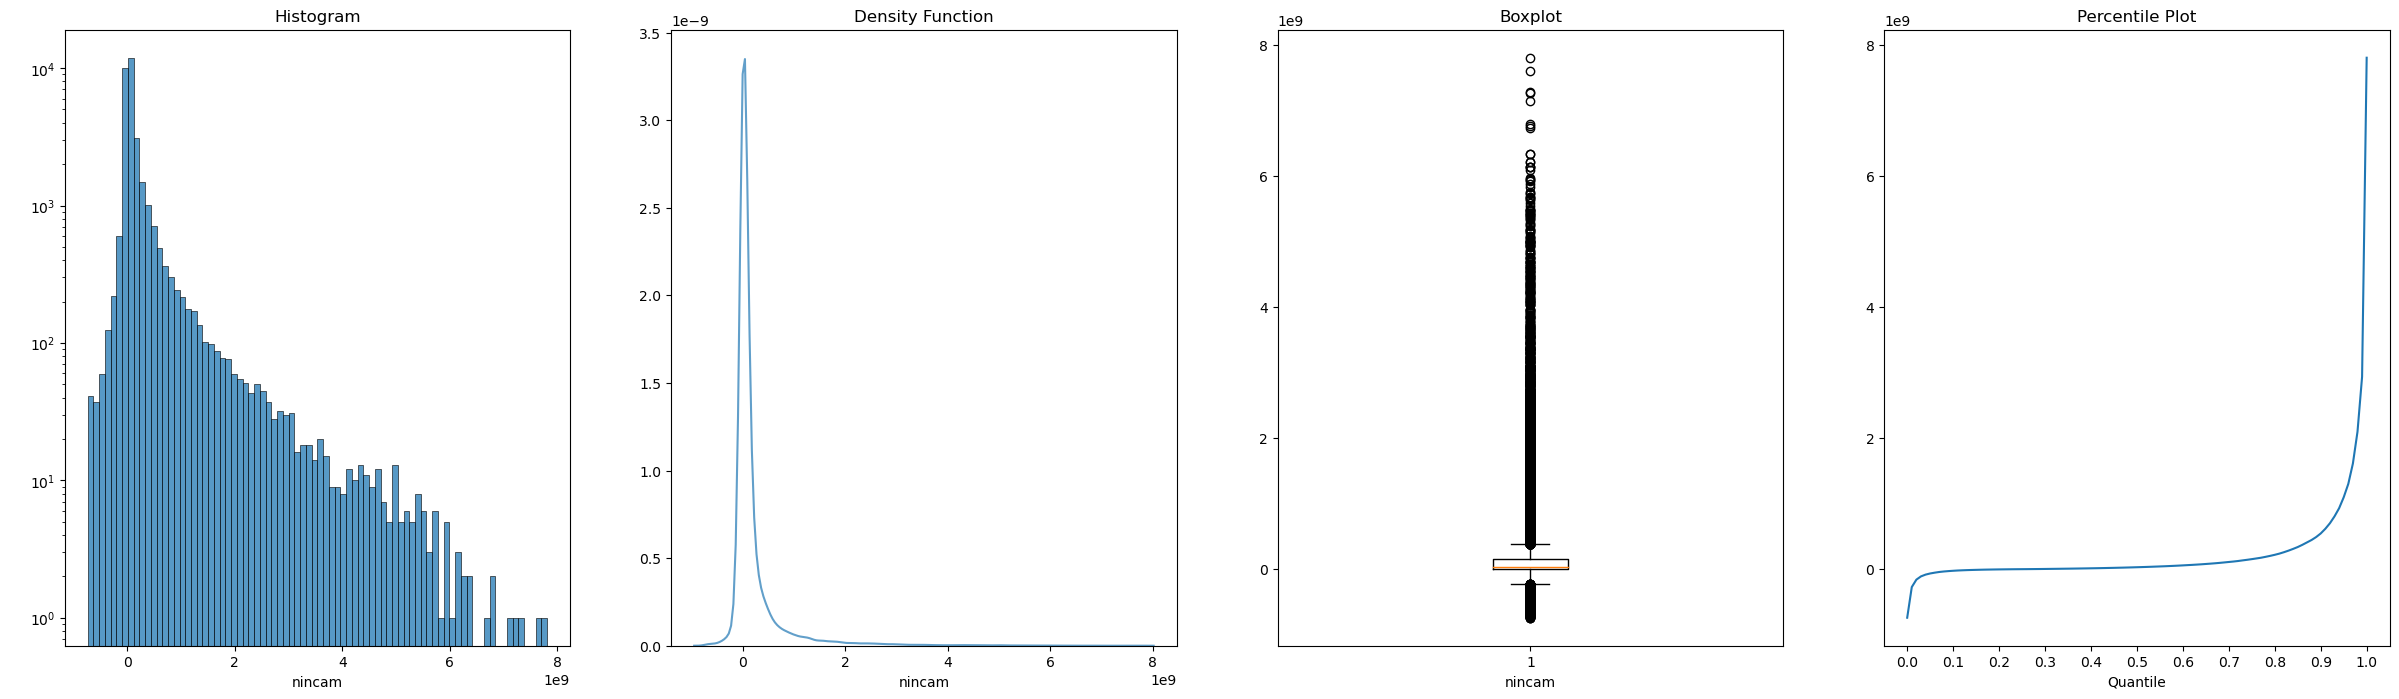

### gp

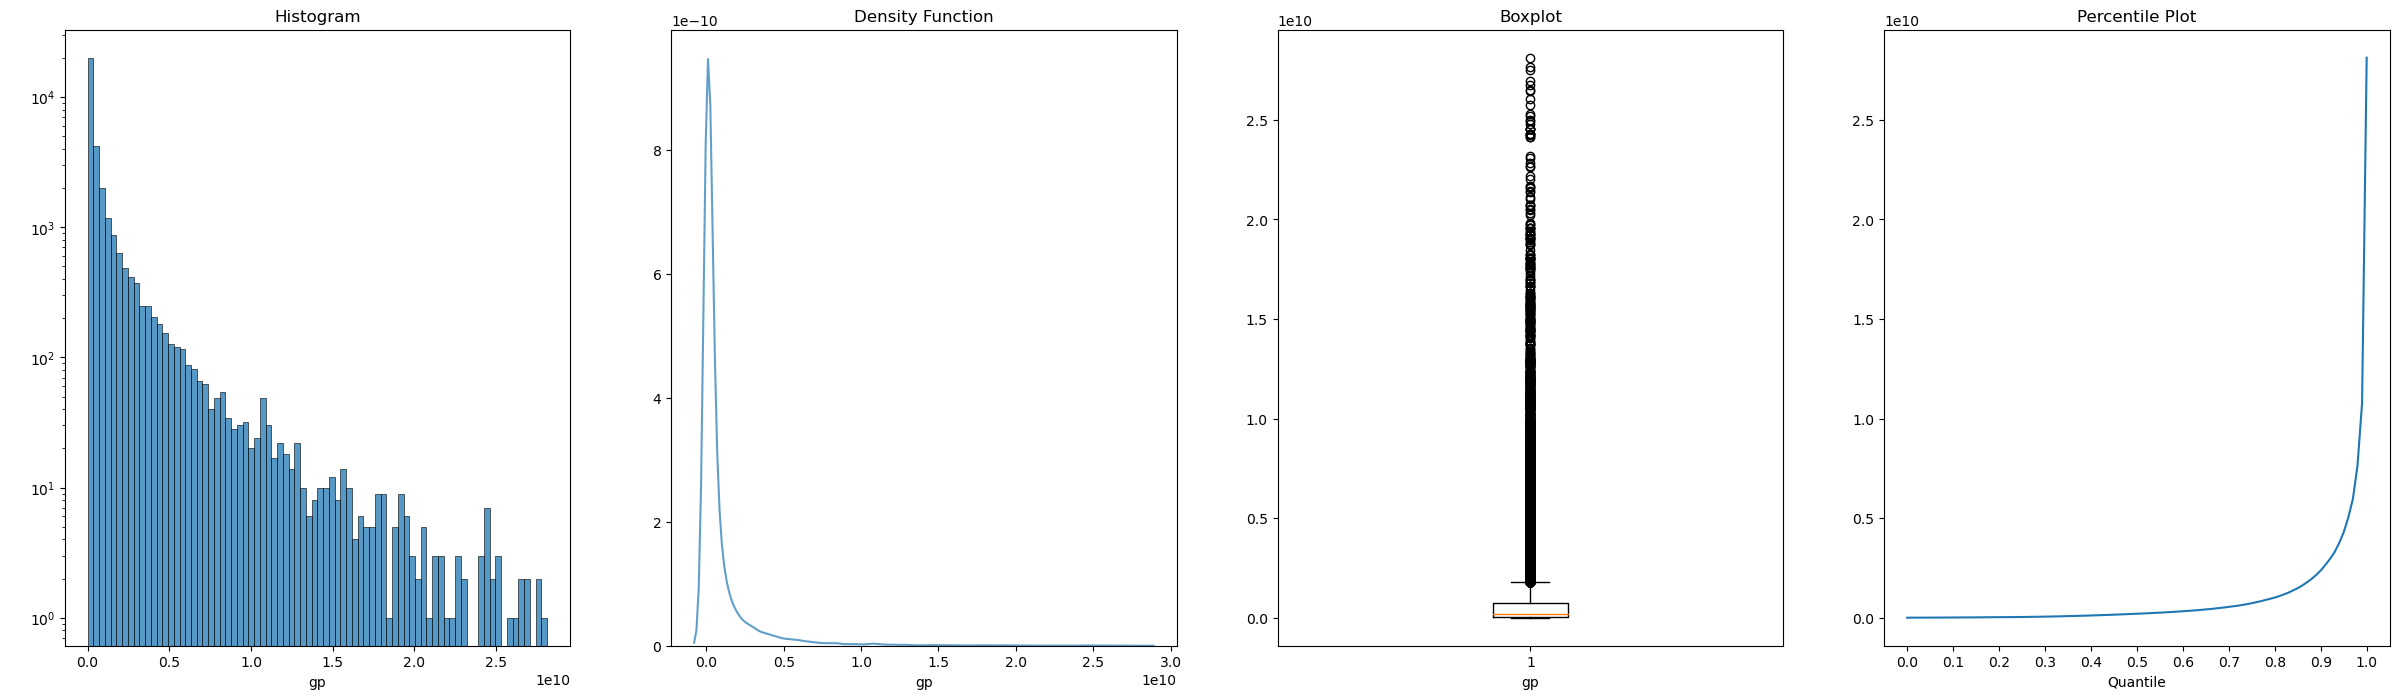

### trev

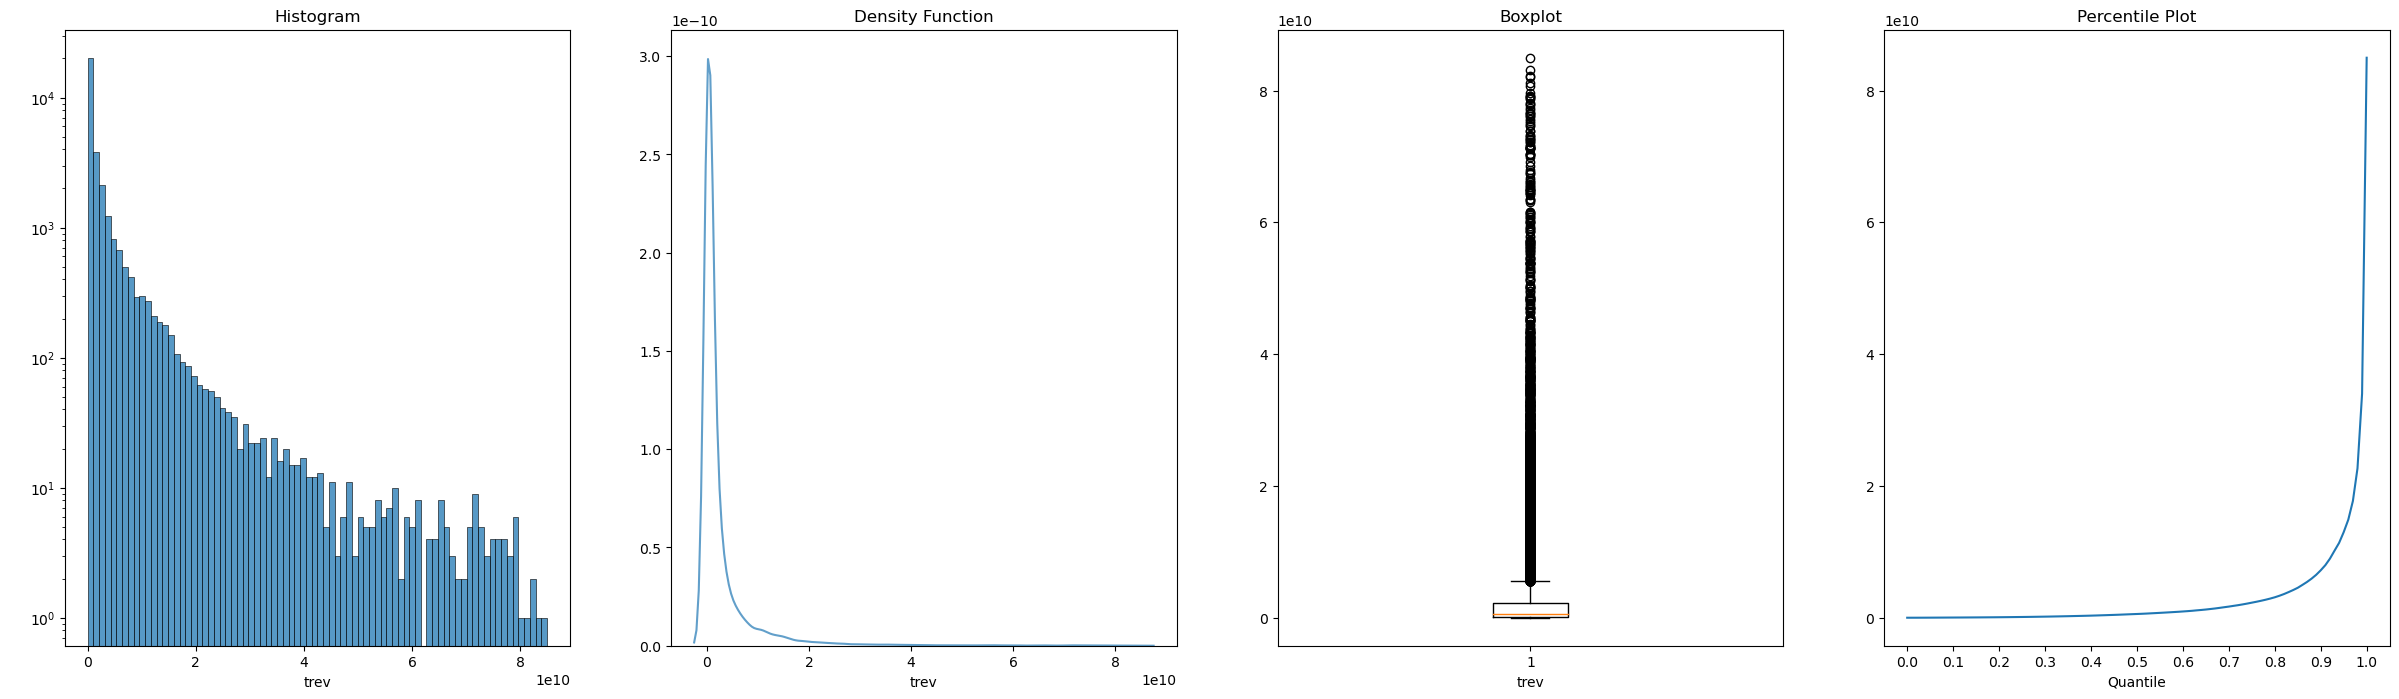

### ebit

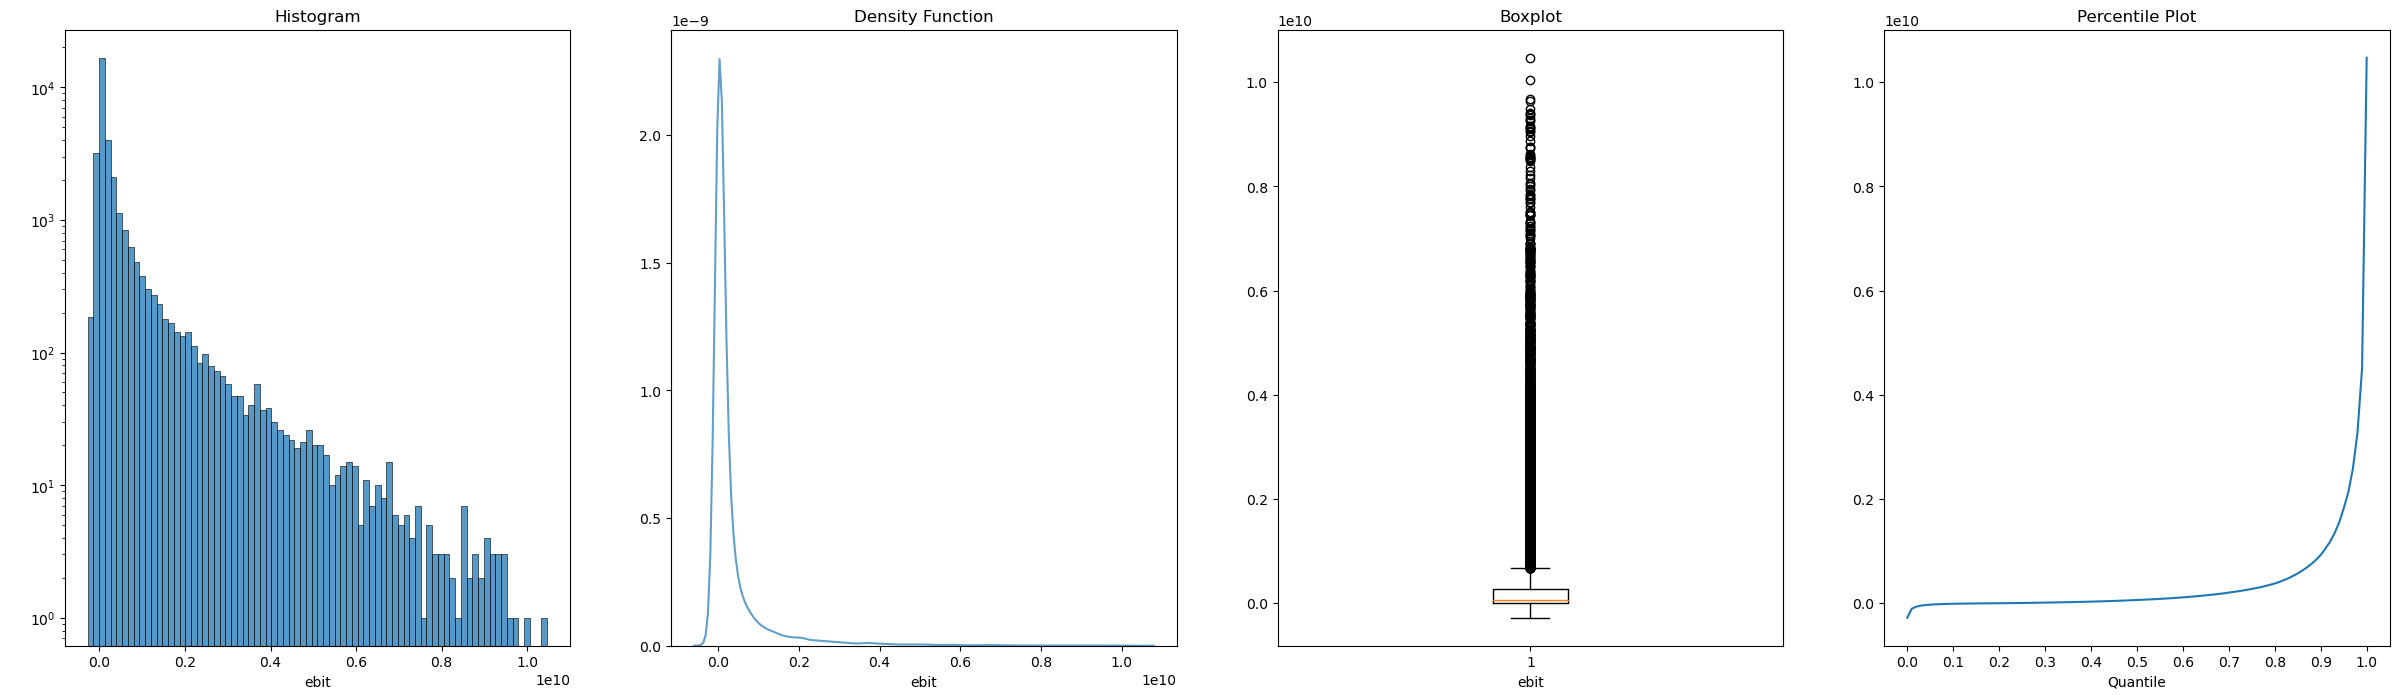

### roe

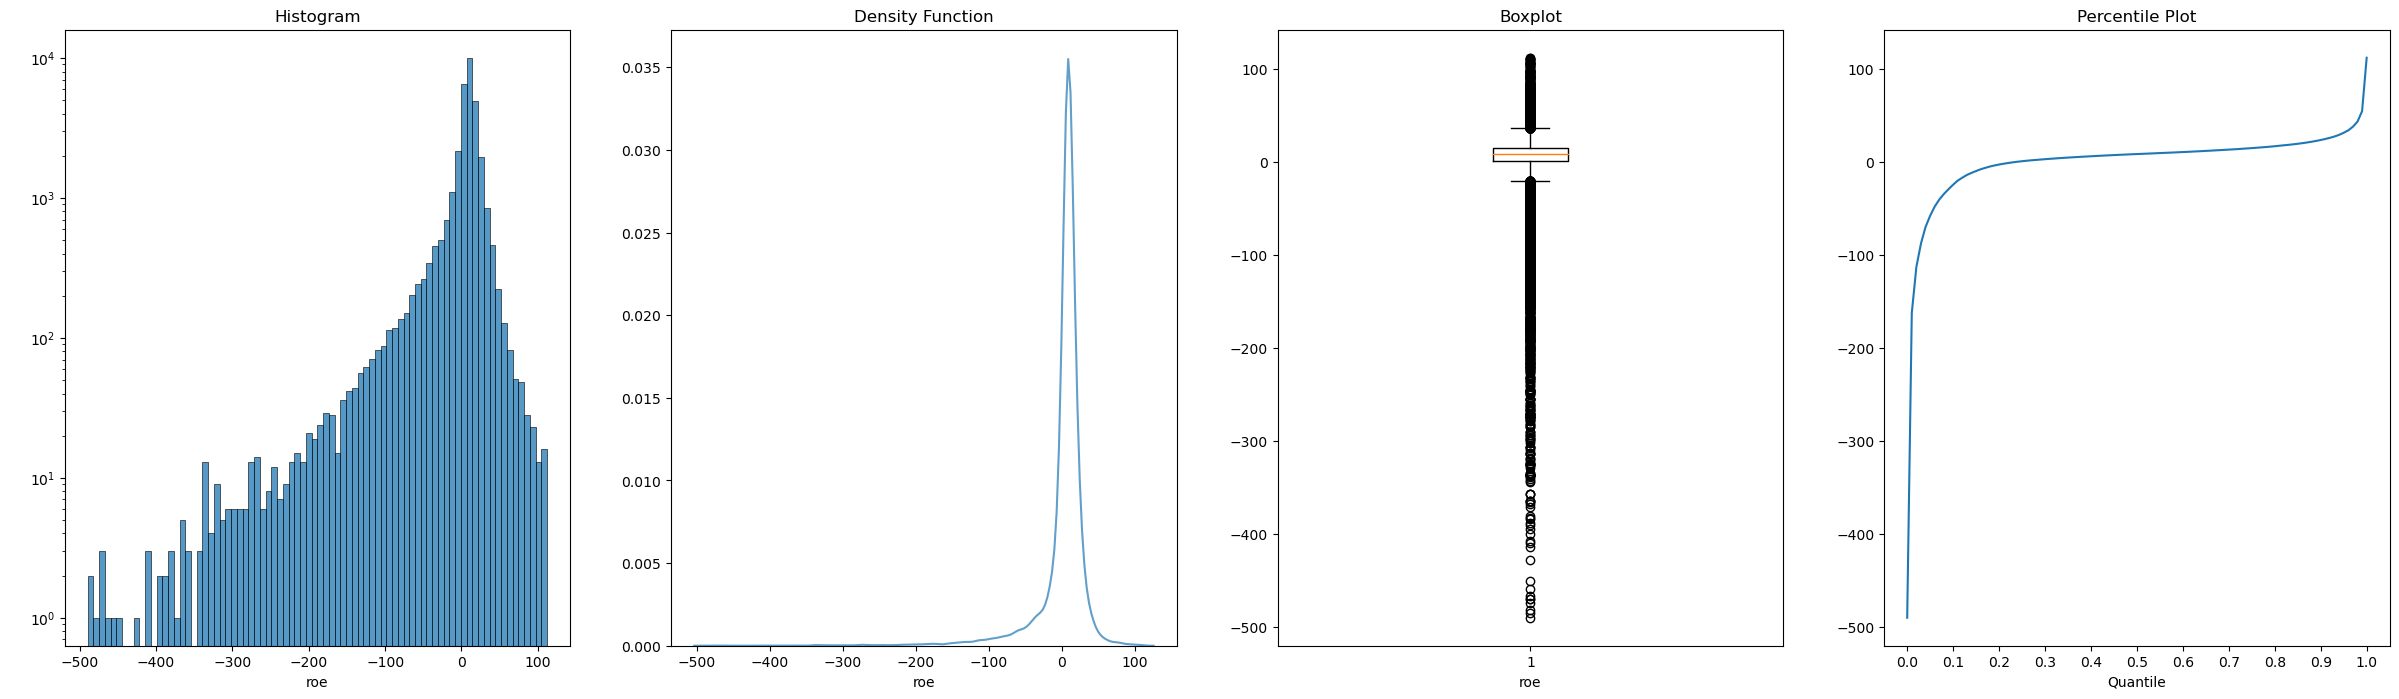

### roce

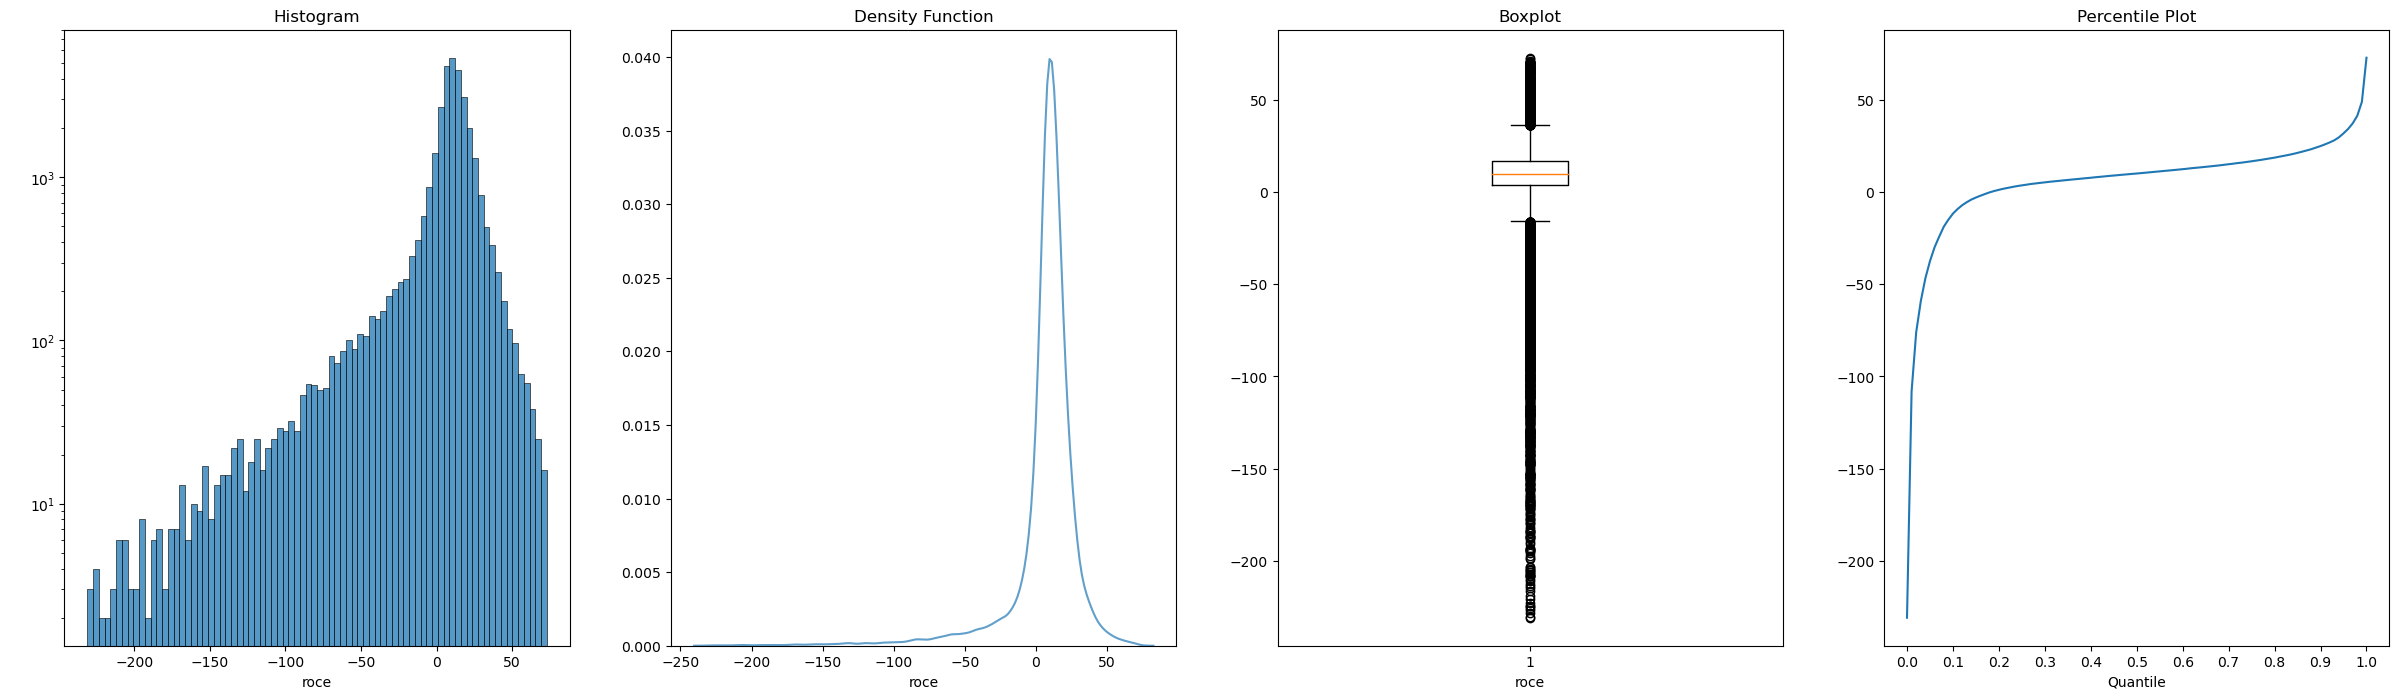

### rnoa

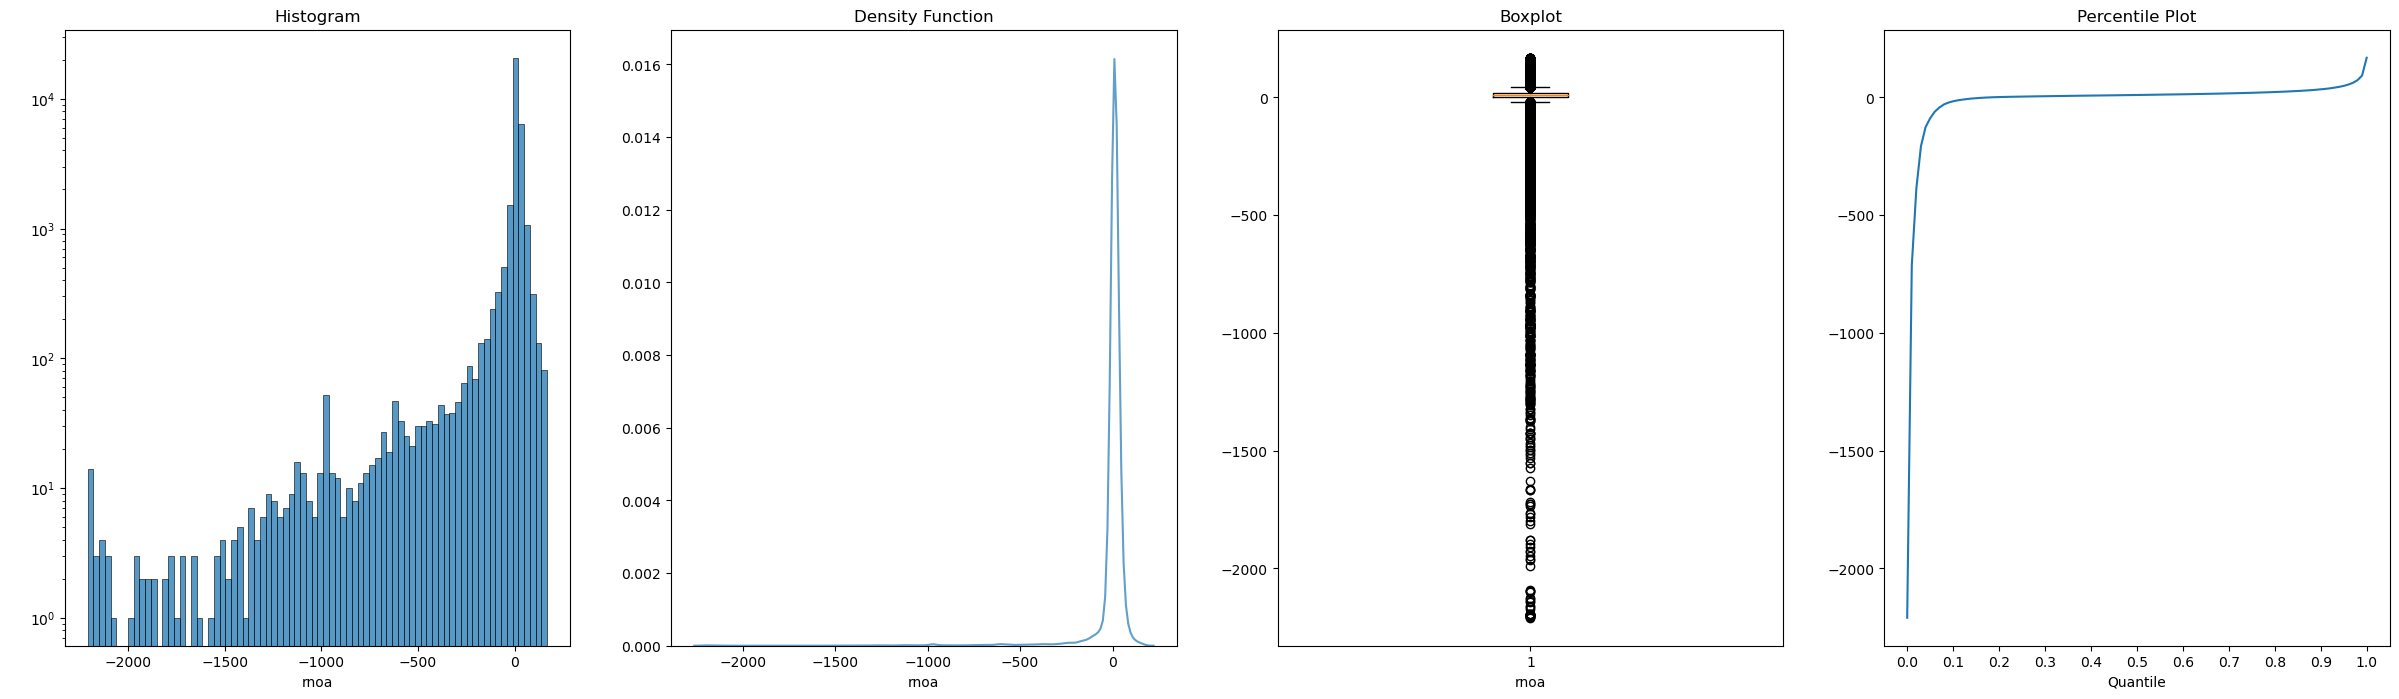

### ebitmarg

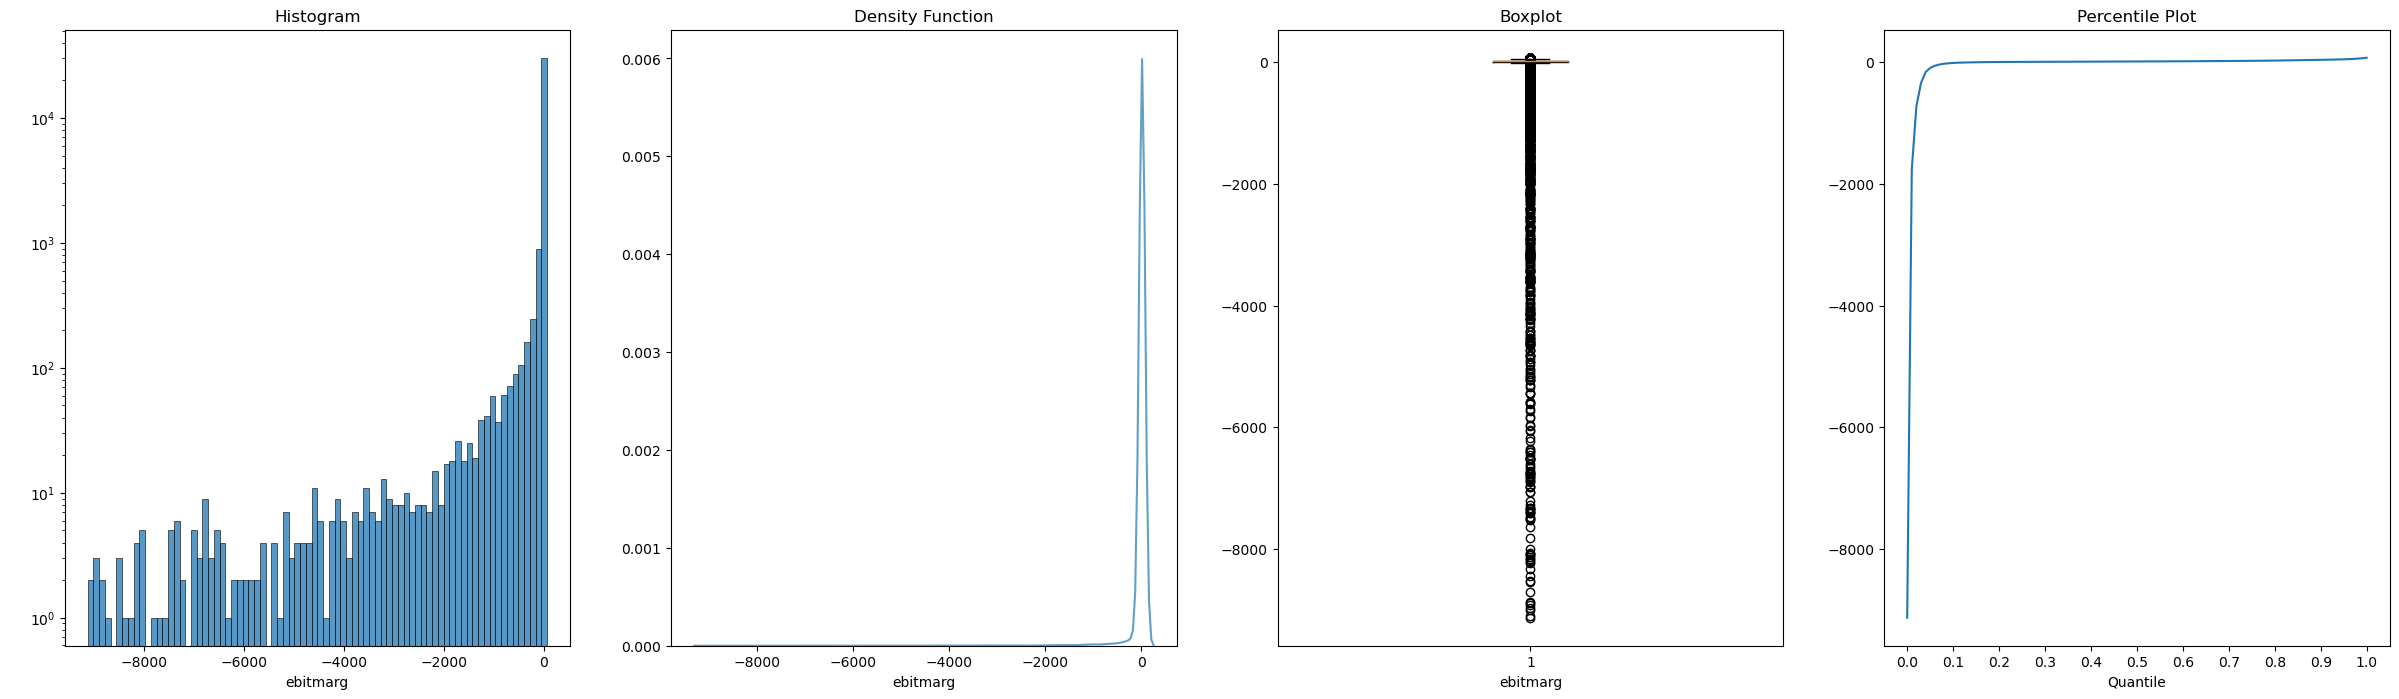

### shouts

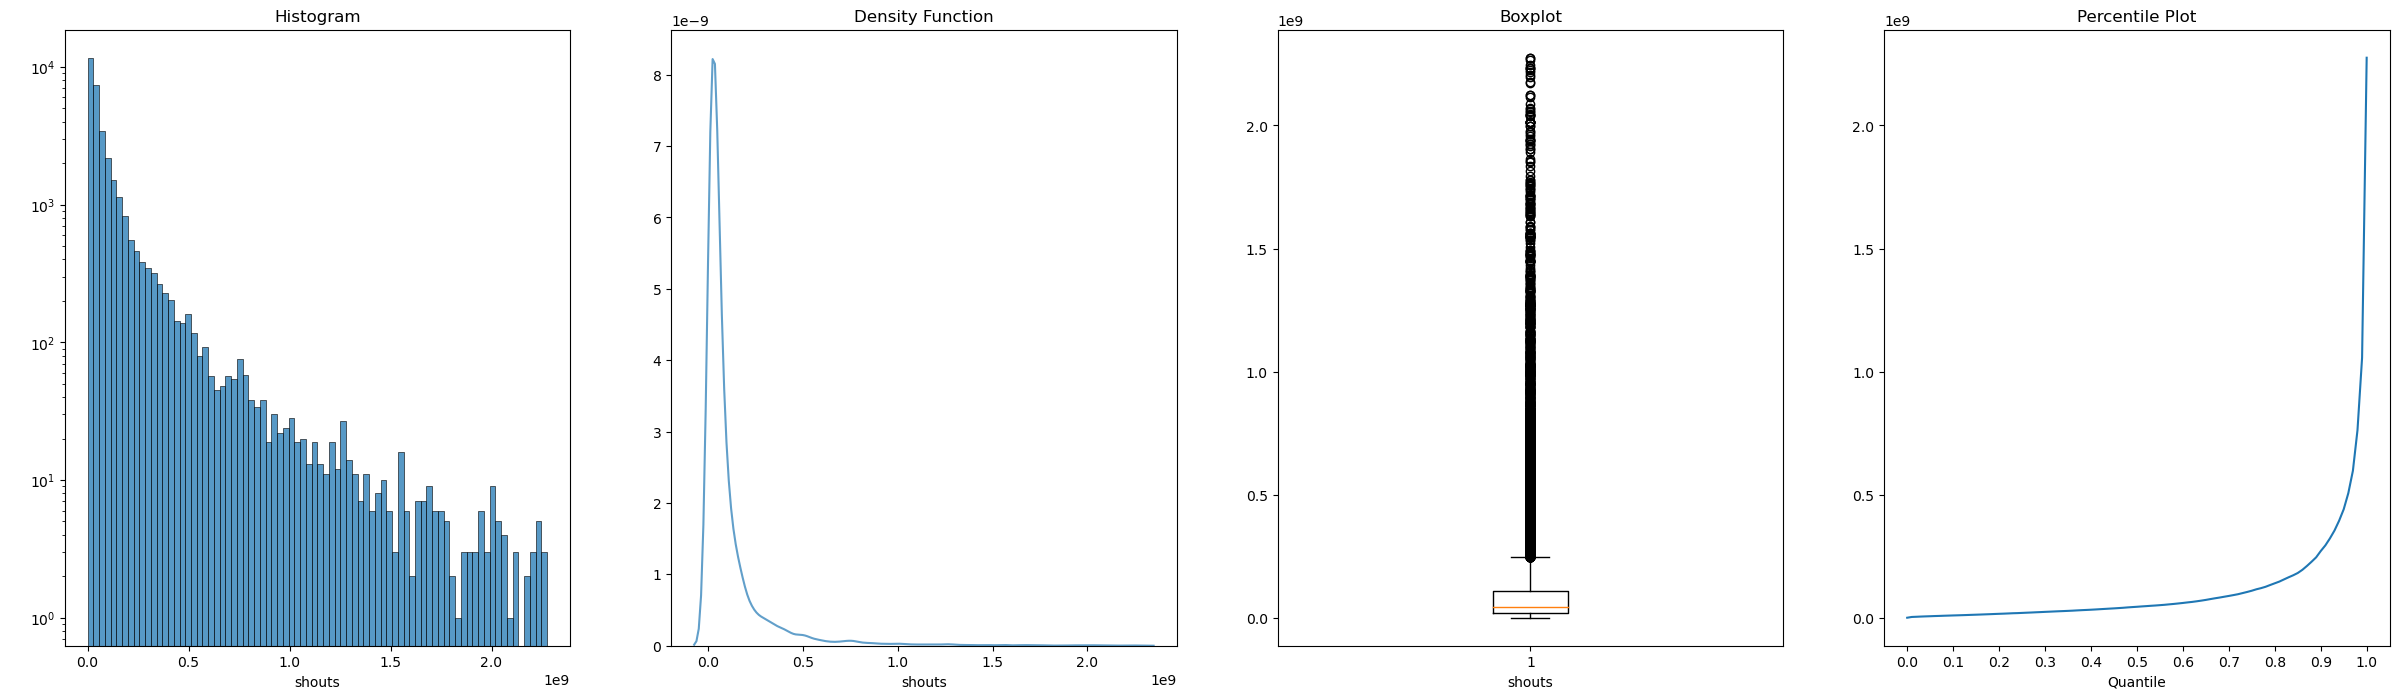

### mc

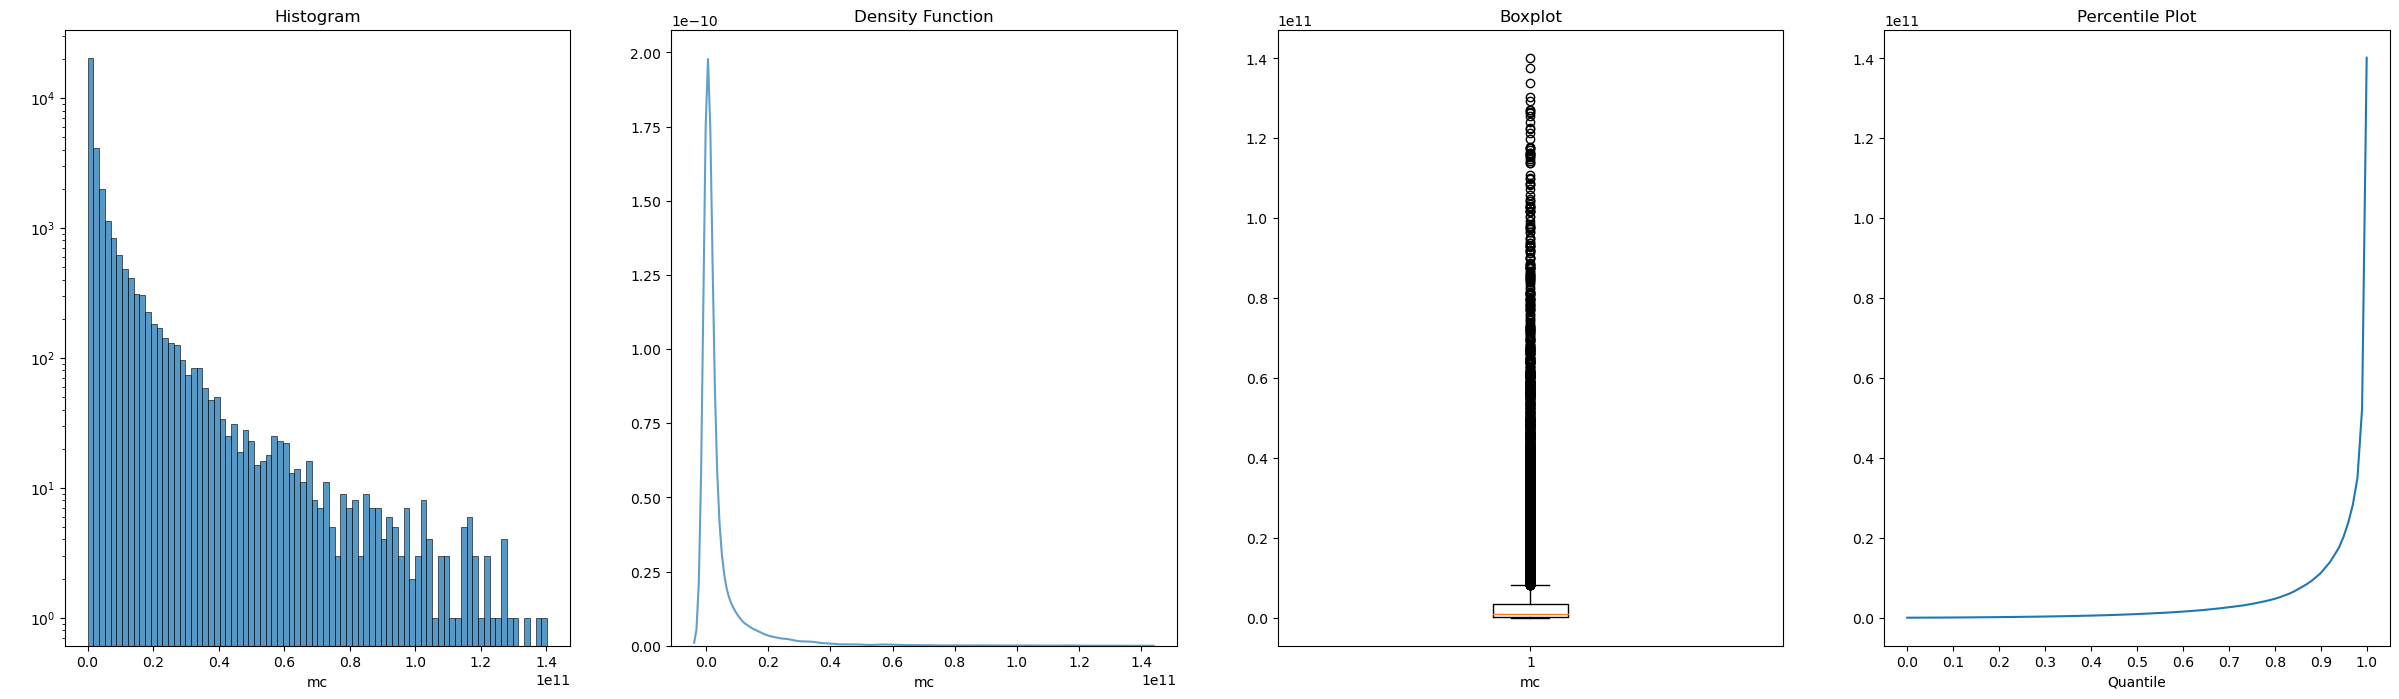

### ptbvps

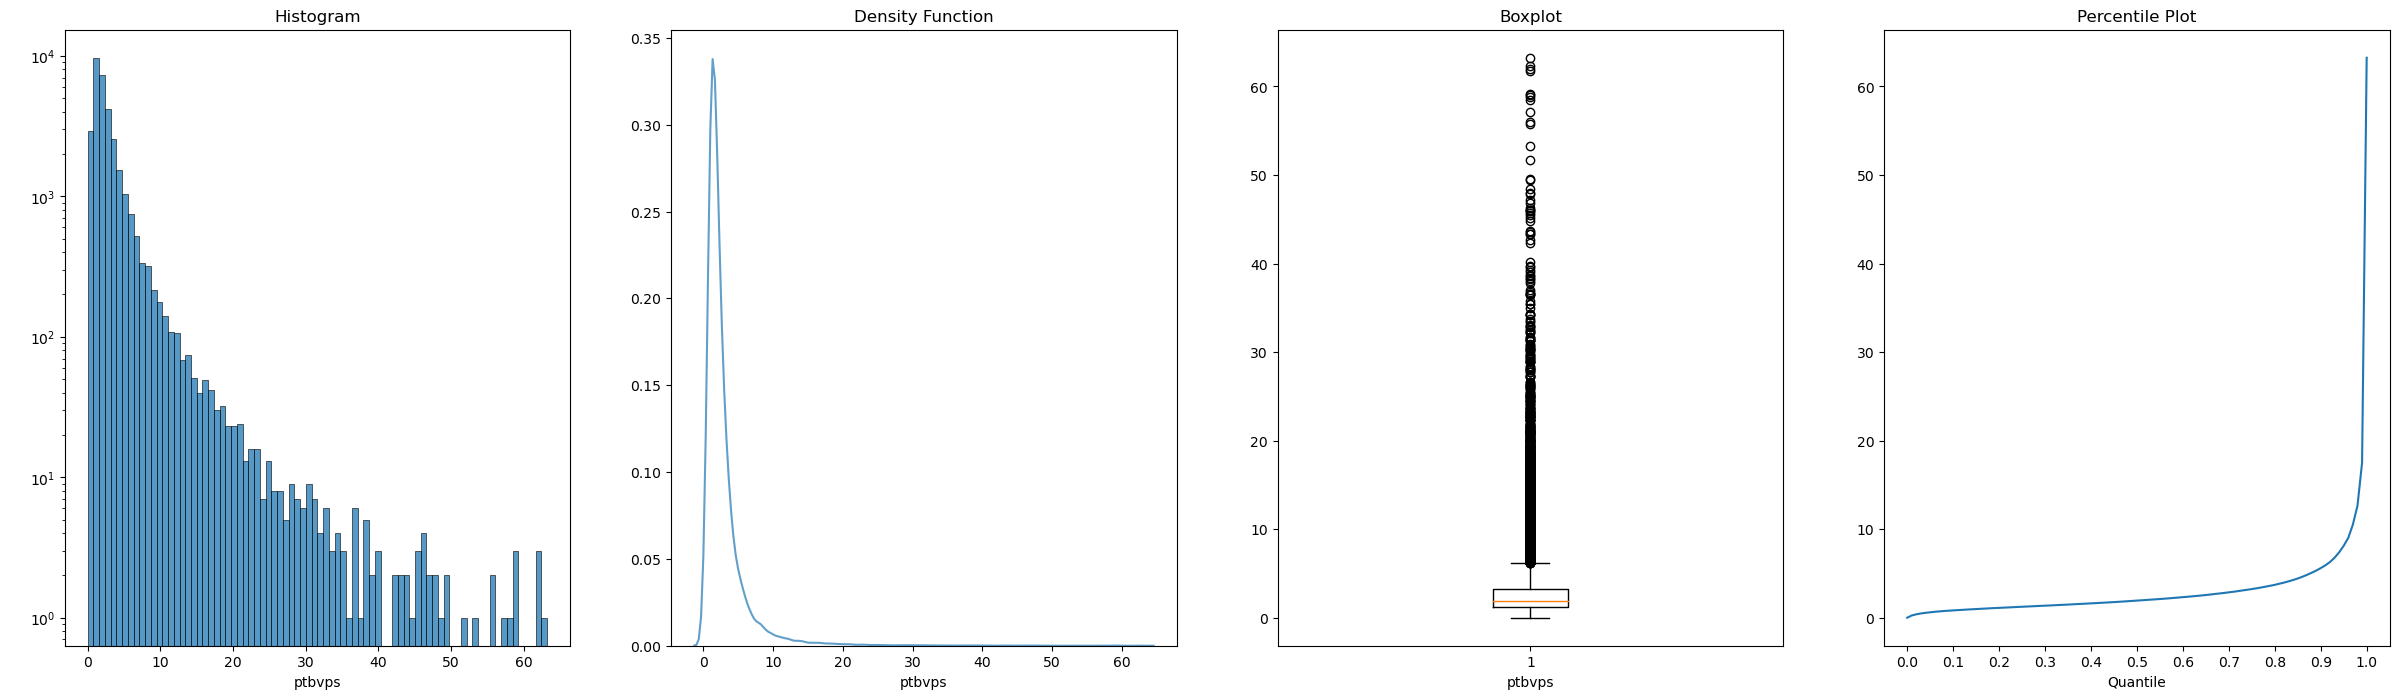

### oips

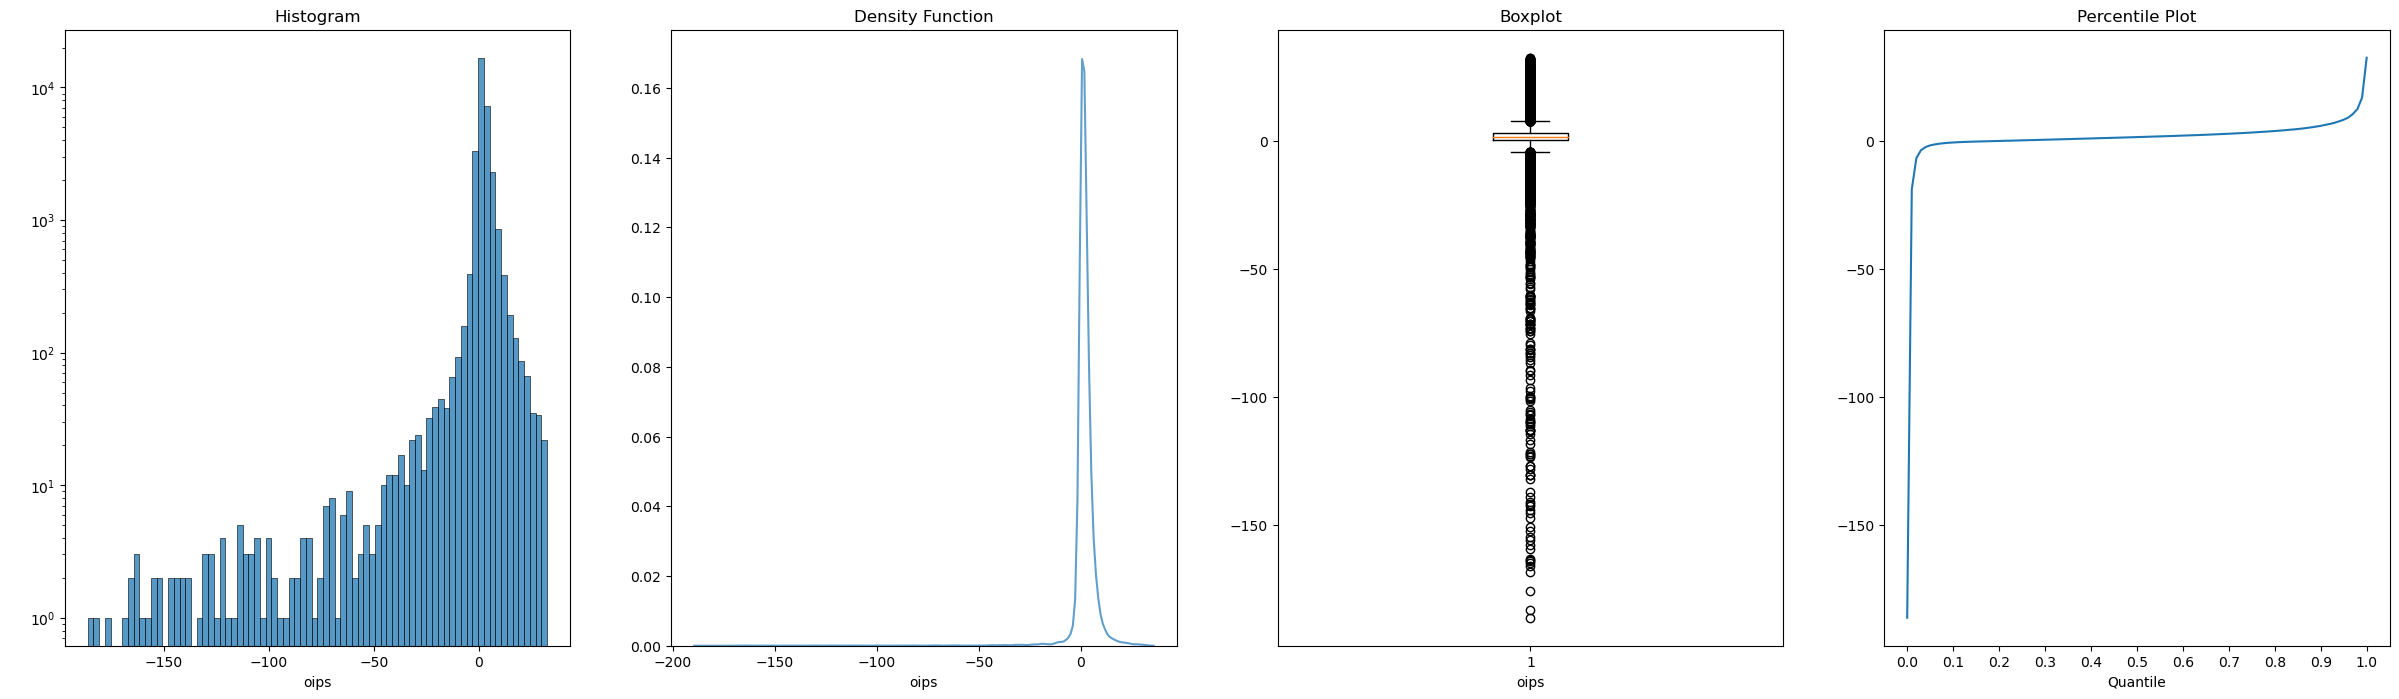

### cfps

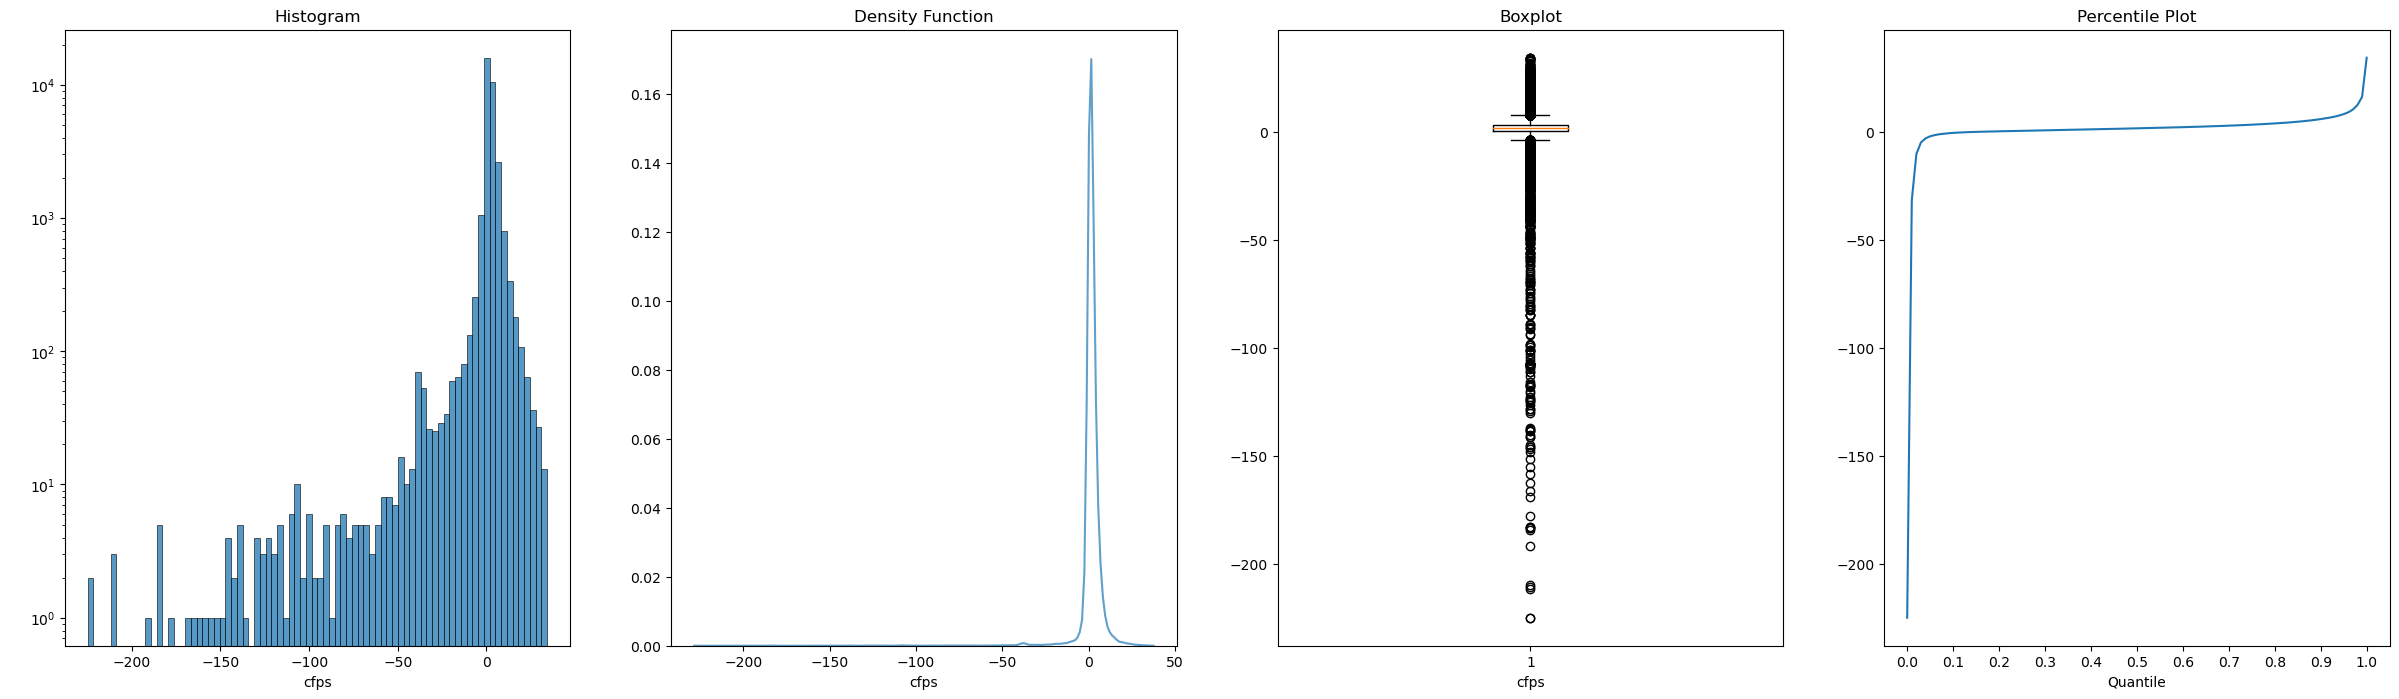

### ros_c

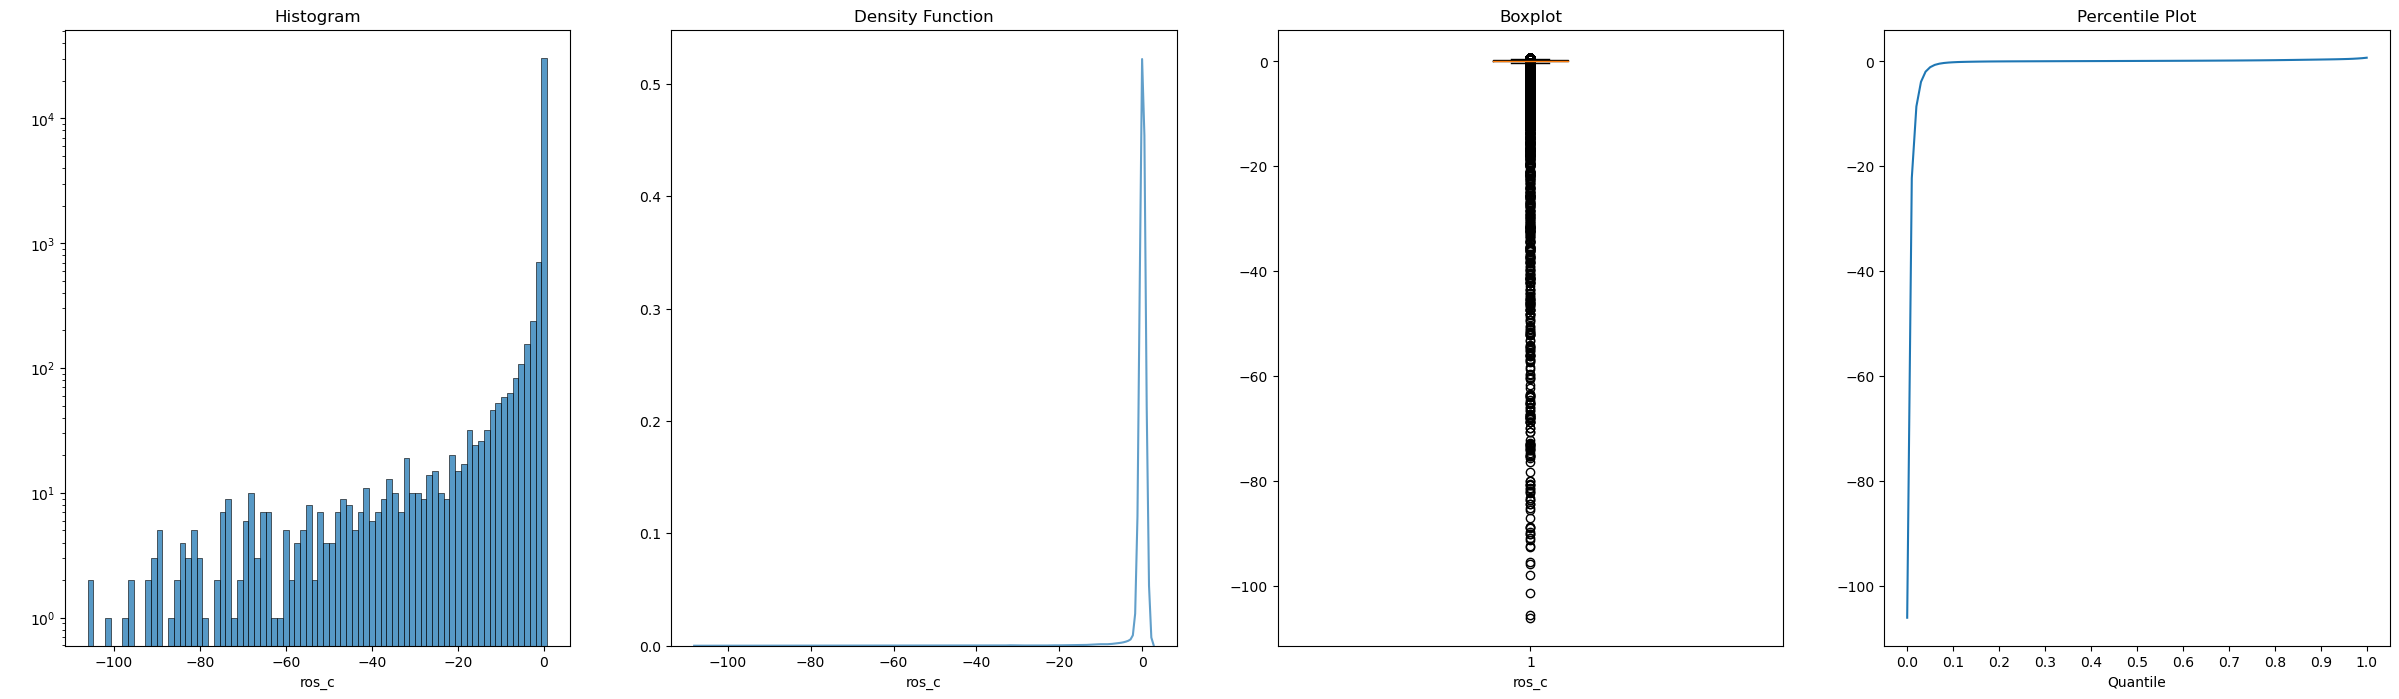

### prof_c

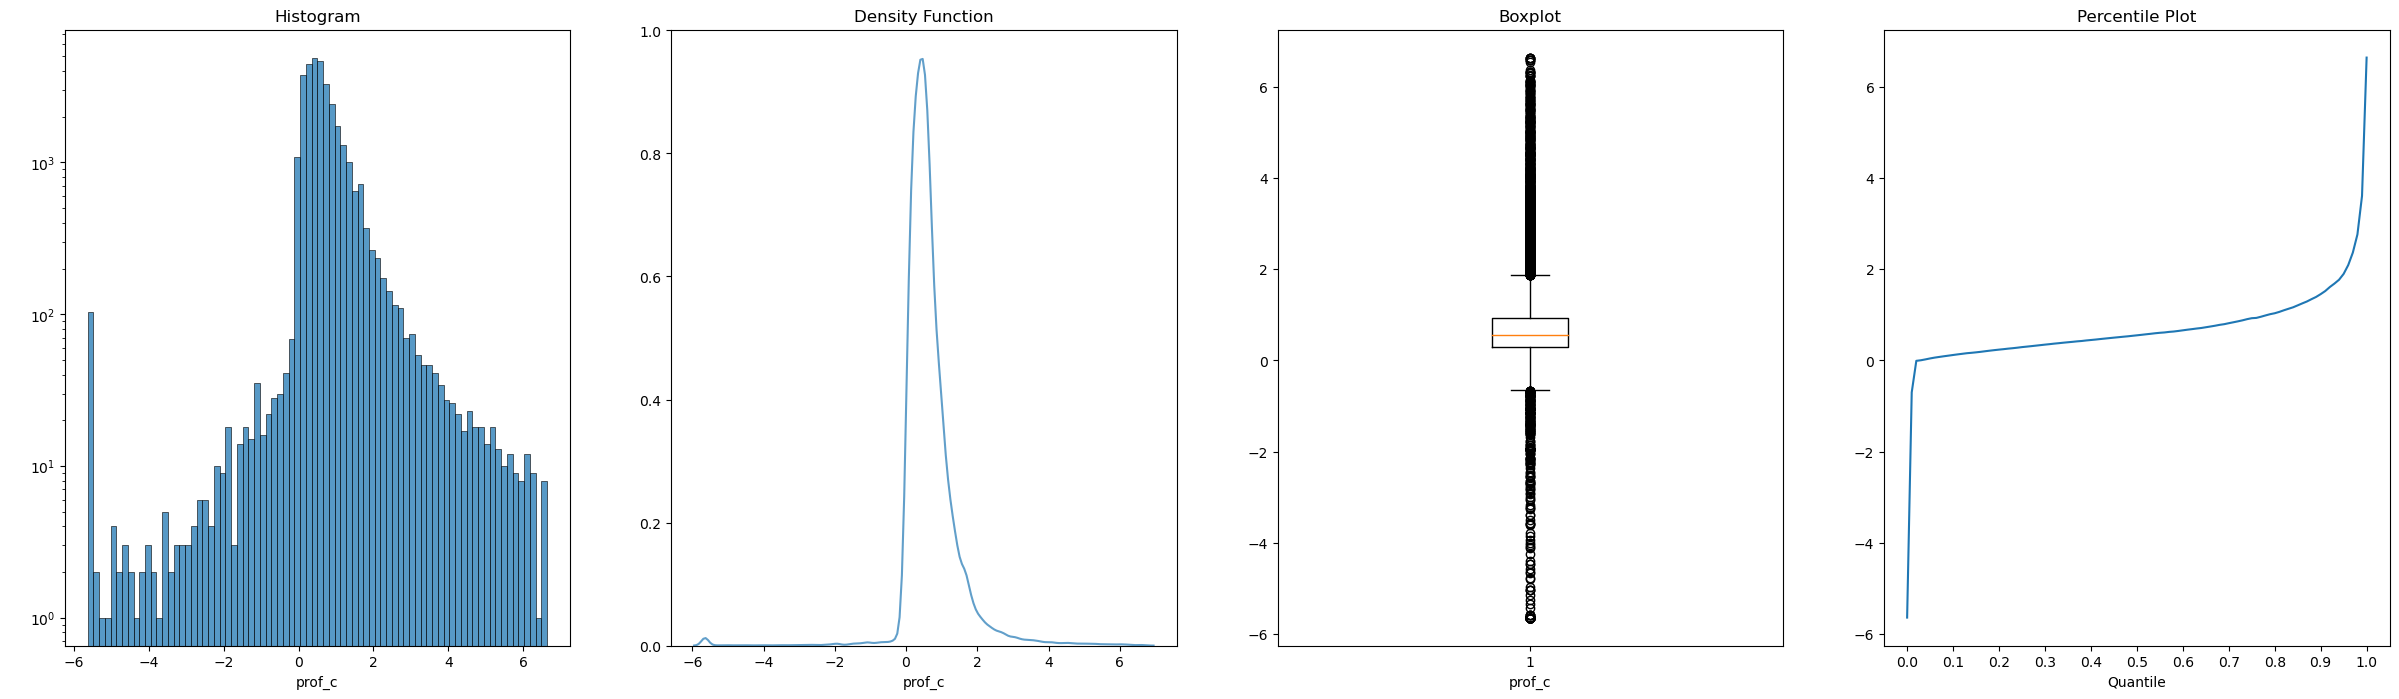

### finlev_c

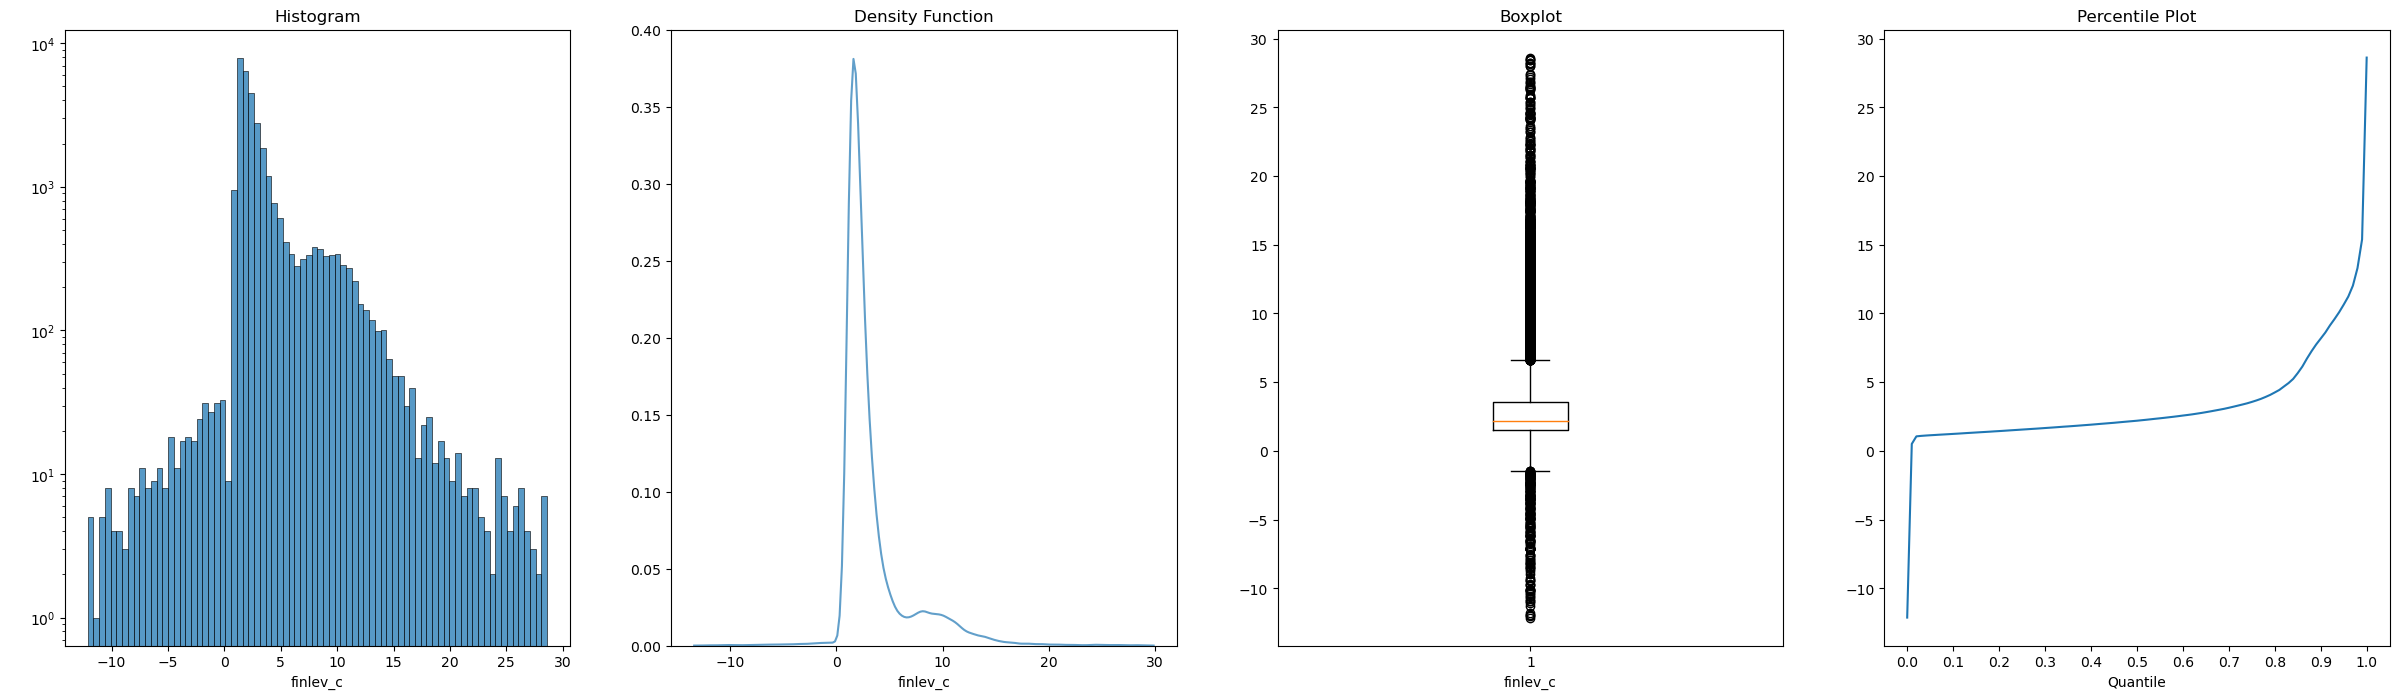

### inc_days

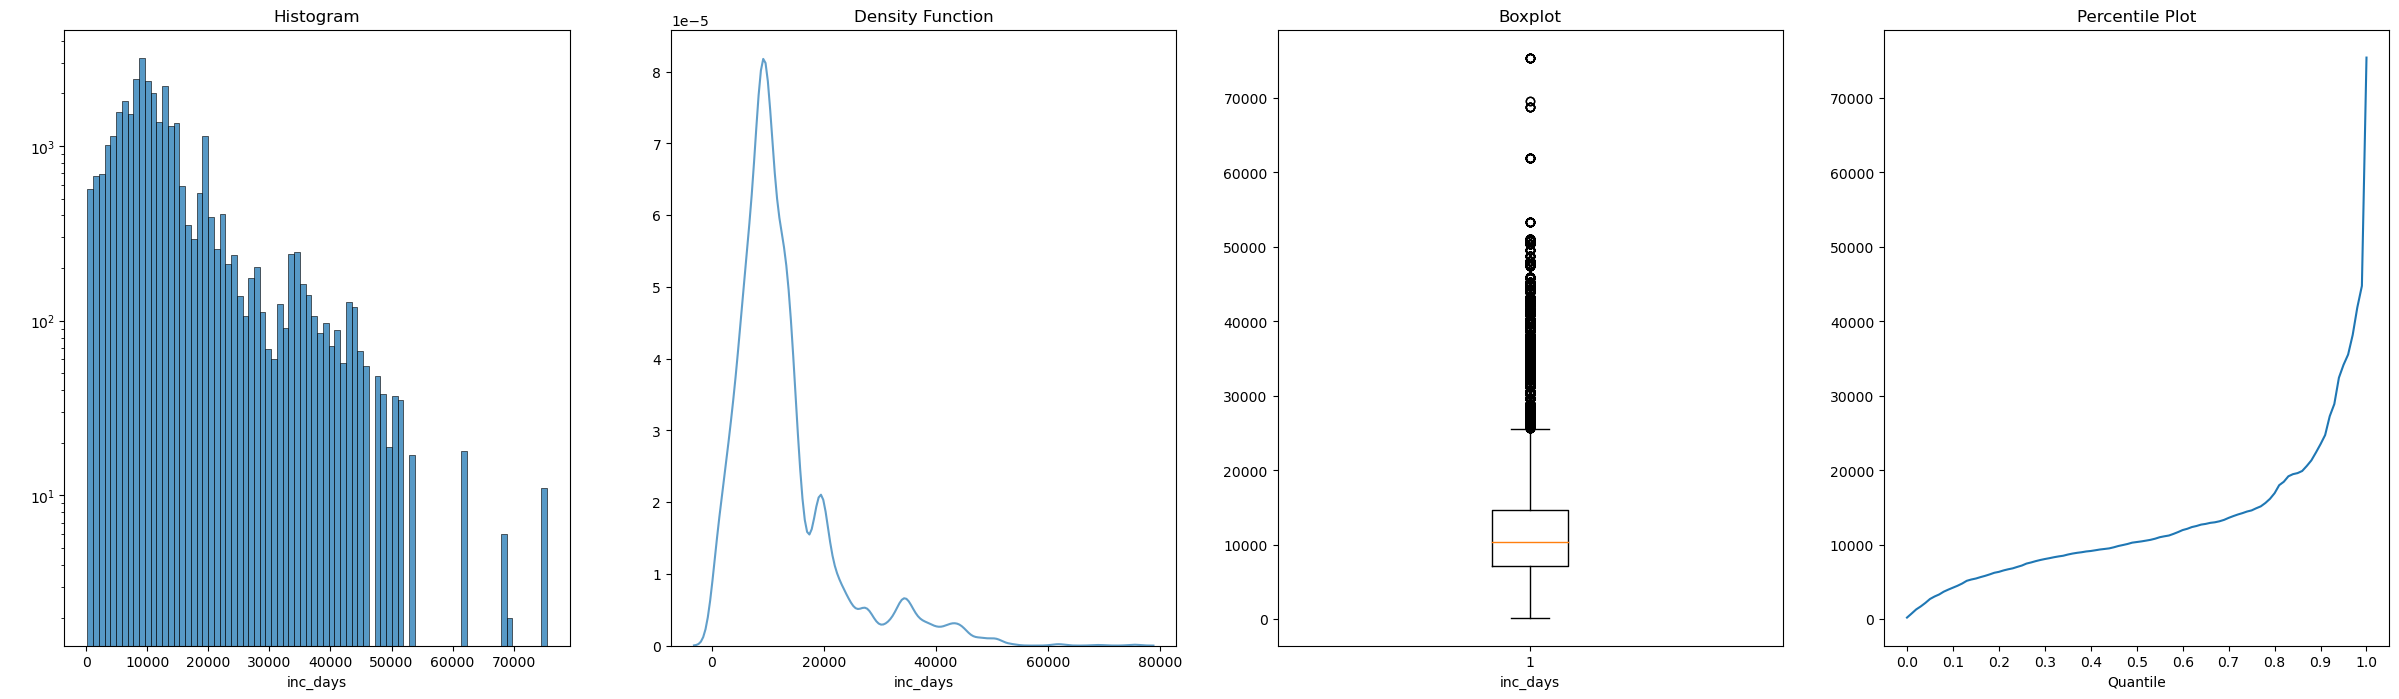

### ipo_days

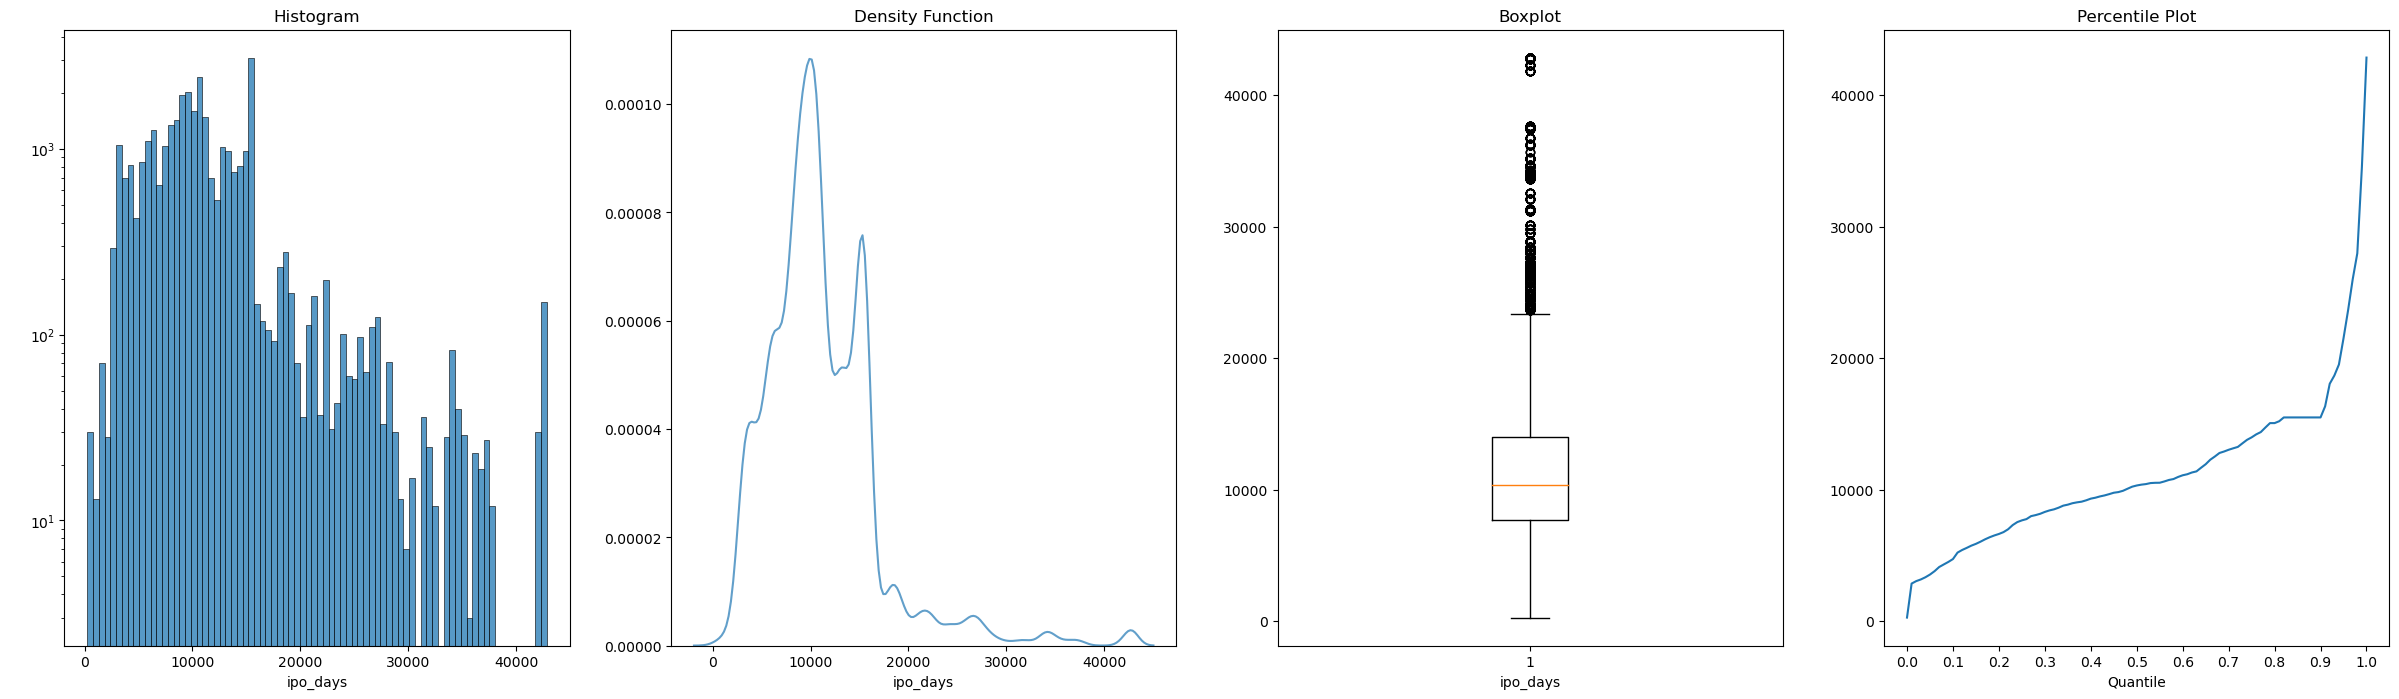

### tau_cop_3y

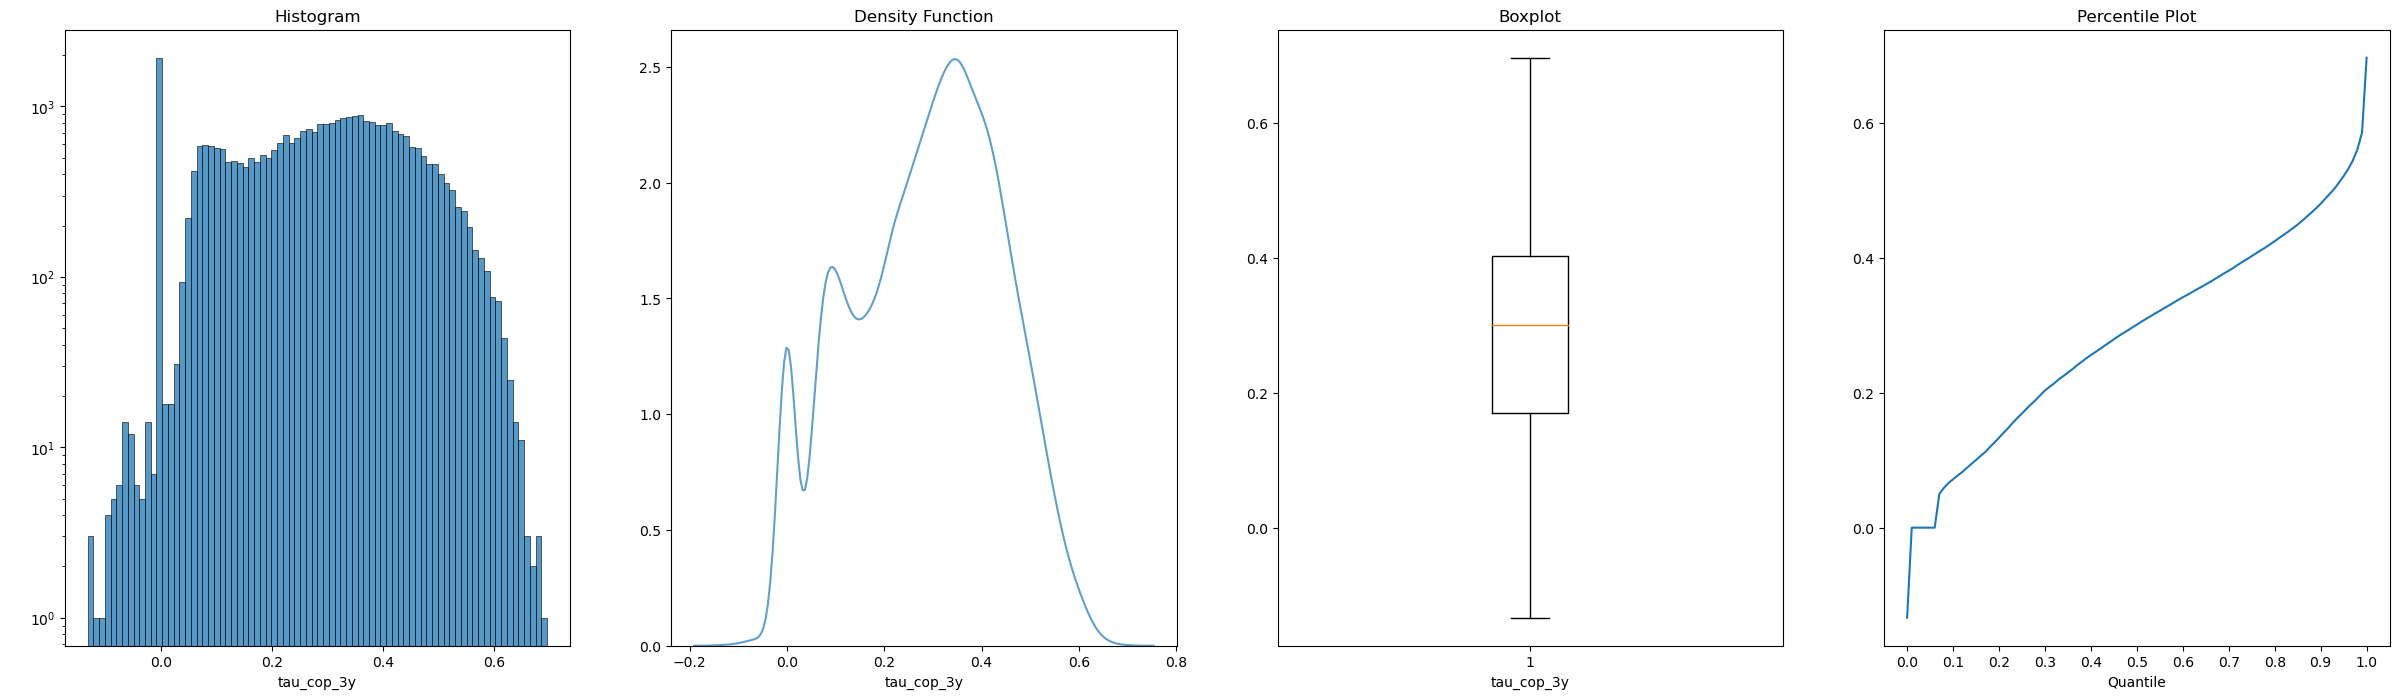

### tau_cop_5y

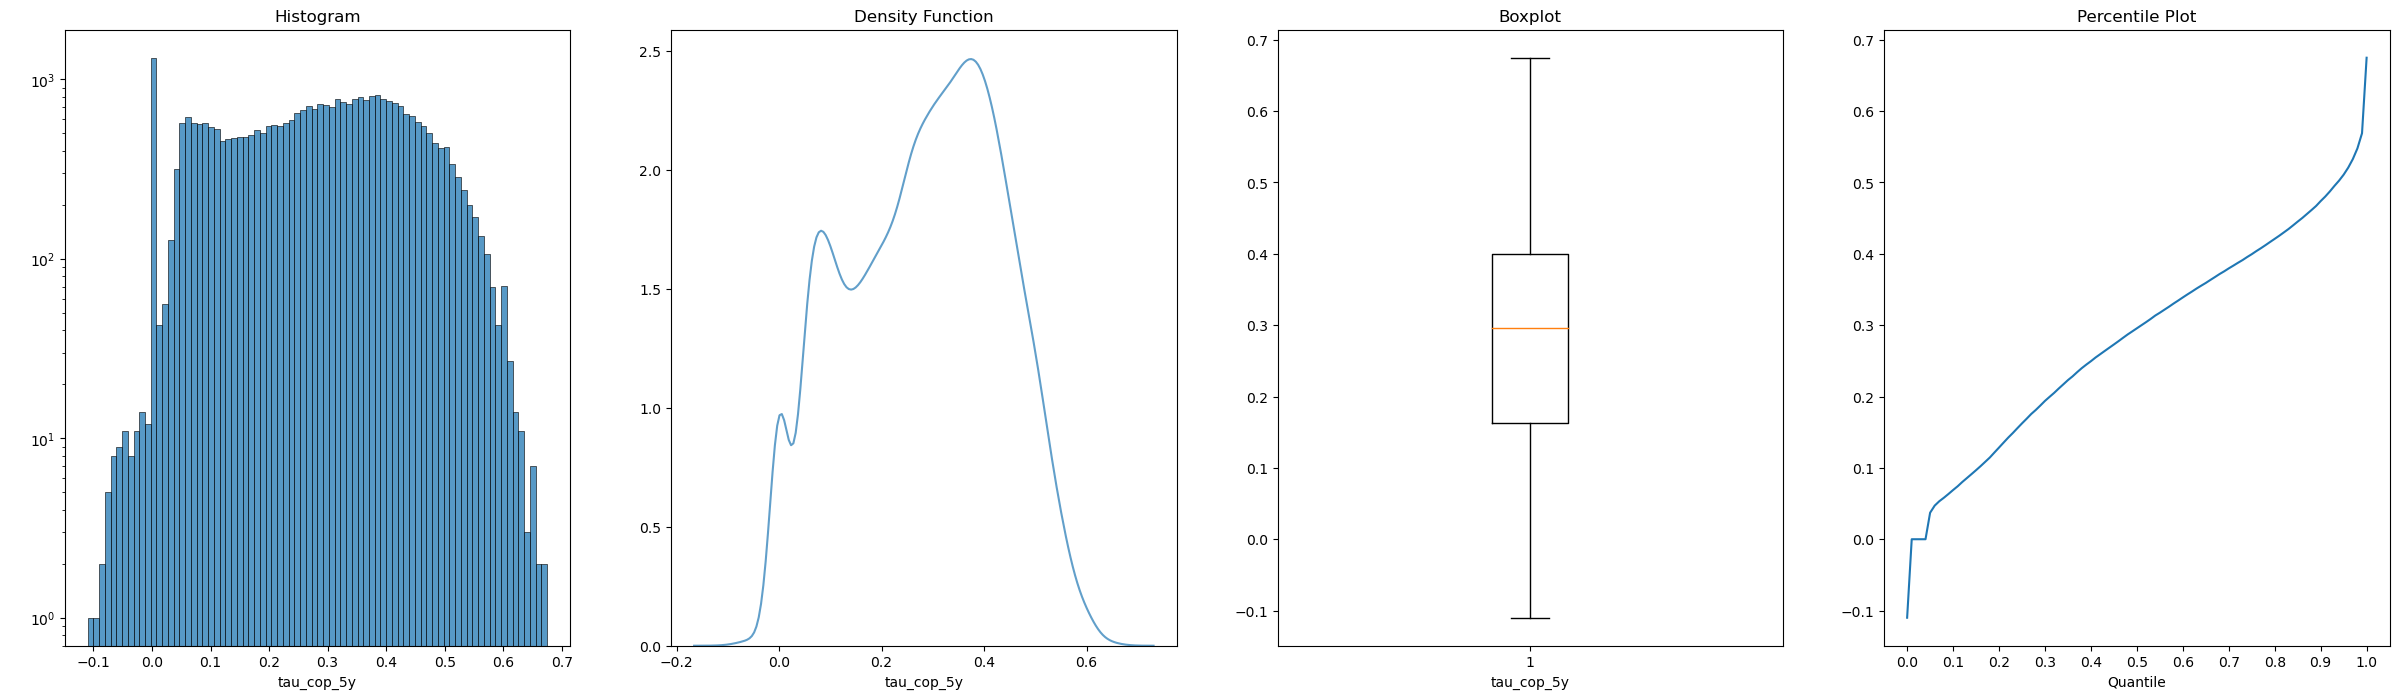

In [45]:
for feature in features:
    display(Markdown('### {feature}'.format(feature=feature)))

    data = data_set[feature].copy()

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
    fig.set_size_inches(30, 8)


    # histogram / distribution
    sns.histplot(data = data_set, x = feature, log_scale = (False, True), bins = 80, ax=ax1)
    ax1.set_xlabel(feature)
    ax1.set_ylabel(' ')
    ax1.set_title('Histogram')
    
    # density function
    sns.kdeplot(data, alpha=0.7, ax=ax2)
    ax2.set_xlabel(feature)
    ax2.set_ylabel(' ')
    ax2.set_title('Density Function')

    # boxplot
    a = data.copy()
    a = a.dropna()
    ax3.boxplot(a)
    ax3.set_xlabel(feature)
    ax3.set_ylabel(' ')
    ax3.set_title('Boxplot')

    quantiles = [data.quantile(el) for el in np.arange(0,1 + 0.01,0.01)]
    ax4.plot(np.arange(0,1 + 0.01,0.01), quantiles)
    ax4.set_xticks(np.arange(0,1 + 0.1,0.1))
    ax4.set_xlabel('Quantile')
    ax4.set_ylabel(' ')
    ax4.set_title('Percentile Plot')

    plt.show()

## ----------------------------------------
## Save Data

In [46]:
data_set.isna().sum()

ric               0
year              0
date              0
isin              0
symbol            0
naics             0
fy_end_date       0
tau_cop_3y        0
tau_cop_5y        0
fam_target_ori    0
rot_target_ori    0
tau_target_ori    0
par_target_ori    0
year_hor          0
tau_target_hor    0
fam_target_hor    0
rot_target_hor    0
par_target_hor    0
debt              0
tass              0
rtass             0
tlia              0
tsheq             0
comeq             0
comsi             0
noa               0
wc                0
ndebt             0
capex             0
ncfo              0
levfcf            0
nincam            0
gp                0
trev              0
ebit              0
roe               0
roce              0
rnoa              0
ebitmarg          0
shouts            0
mc                0
ptbvps            0
oips              0
cfps              0
ros_c             0
prof_c            0
finlev_c          0
inc_days          0
ipo_days          0
dtype: int64

In [47]:
data_set.describe()

year    tau_cop_3y    tau_cop_5y  rot_target_ori  \
count  32597.000000  32597.000000  32597.000000    32597.000000   
mean    2011.463632      0.286209      0.282392       50.426726   
std        5.268878      0.152440      0.149763       80.904804   
min     2001.000000     -0.133399     -0.109982        0.000000   
25%     2007.000000      0.169156      0.162340        0.000000   
50%     2012.000000      0.300733      0.295569        0.000000   
75%     2016.000000      0.402276      0.399405      180.000000   
max     2019.000000      0.696102      0.674719      270.000000   

       tau_target_ori      year_hor  tau_target_hor  rot_target_hor  \
count    32597.000000  32597.000000    32597.000000    32597.000000   
mean         0.291295   2012.463632        0.300977       53.303678   
std          0.161583      5.268878        0.159084       82.237644   
min         -0.224582   2002.000000       -0.224582        0.000000   
25%          0.179248   2008.000000        0.194278        0.000000   
50%          0.307467   2013.000000        0.318904        0.000000   
75%          0.408183   2017.000000        0.416072      180.000000   
max          0.748887   2020.000000        0.748887      270.000000   

               debt          tass         rtass          tlia         tsheq  \
count  3.259700e+04  3.259700e+04  32597.000000  3.259700e+04  3.259700e+04   
mean   1.376902e+09  5.751177e+09     -0.295015  4.051855e+09  1.709425e+09   
std    3.472724e+09  1.536276e+10     17.920093  1.275695e+10  3.681661e+09   
min    0.000000e+00  4.461400e+04   -168.419655 -1.517000e+09 -1.860170e+08   
25%    1.355867e+07  2.772090e+08      0.312535  9.199500e+07  1.261950e+08   
50%    2.063460e+08  1.210300e+09      2.889370  6.480630e+08  4.489910e+08   
75%    1.082800e+09  4.451416e+09      6.727253  2.772578e+09  1.509834e+09   
max    6.281900e+10  2.397920e+11     31.590345  2.234930e+11  5.708000e+10   

              comeq         comsi           noa            wc         ndebt  \
count  3.259700e+04  3.259700e+04  3.259700e+04  3.259700e+04  3.259700e+04   
mean   1.637561e+09  1.310125e+08  2.763752e+09  3.640343e+08  1.048920e+09   
std    3.518415e+09  2.524669e+08  6.112451e+09  1.077719e+09  3.078546e+09   
min   -2.429000e+08  0.000000e+00 -5.597400e+07 -3.548067e+09 -2.925000e+09   
25%    1.225040e+08  1.793326e+07  1.192970e+08  1.322000e+07 -1.955000e+07   
50%    4.342840e+08  4.739271e+07  5.909990e+08  9.639000e+07  8.137400e+07   
75%    1.458277e+09  1.233160e+08  2.389087e+09  3.532610e+08  7.544270e+08   
max    5.533100e+10  3.061486e+09  9.873900e+10  1.820455e+10  4.960700e+10   

              capex          ncfo        levfcf        nincam            gp  \
count  3.259700e+04  3.259700e+04  3.259700e+04  3.259700e+04  3.259700e+04   
mean   1.889133e+08  4.088524e+08  2.253761e+08  2.039004e+08  8.971791e+08   
std    4.916671e+08  9.495311e+08  7.140962e+08  5.684393e+08  2.098145e+09   
min    0.000000e+00 -3.618213e+08 -1.298050e+09 -7.403370e+08 -3.221000e+06   
25%    4.080000e+06  8.947000e+06 -3.855333e+06  7.667060e+05  3.342100e+07   
50%    2.482400e+07  8.346200e+07  2.965100e+07  3.042900e+07  1.957000e+08   
75%    1.270000e+08  3.440000e+08  1.786830e+08  1.540000e+08  7.271550e+08   
max    5.501000e+09  1.233300e+10  1.147544e+10  7.808000e+09  2.812067e+10   

               trev          ebit           roe          roce          rnoa  \
count  3.259700e+04  3.259700e+04  32597.000000  32597.000000  32597.000000   
mean   2.760181e+09  3.513114e+08      1.432779      6.348806     -9.994689   
std    6.662513e+09  8.555401e+08     37.124766     25.366552    142.229298   
min    0.000000e+00 -2.767930e+08   -489.614852   -230.970703  -2209.167569   
25%    1.126655e+08  6.448000e+06      0.909252      3.754035      3.476220   
50%    5.660910e+08  6.354900e+07      8.623381     10.182872     10.319370   
75%    2.285000e+09  2.757250e+08     15.031901     16.835643     19.615981   
max

In [48]:
print('Amount of companies copula data: ' + str(len(target['symbol'].drop_duplicates())))
print('Amount of companies balance sheet data timeseries: ' + str(len(timeseries['ric'].drop_duplicates())))
print('Amount of companies balance sheet data statics: ' + str(len(statics['ric'].drop_duplicates())))
print('Amount of companies data set: ' + str(len(data_set['symbol'].drop_duplicates())))

Amount of companies copula data: 3150
Amount of companies balance sheet data timeseries: 5581
Amount of companies balance sheet data statics: 5964
Amount of companies data set: 2904


In [49]:
print('Amount of observations balance sheet data timeseries ' + str(len(timeseries)))
print('Amount of observations data set ' + str(len(data_set)))

Amount of observations balance sheet data timeseries 90143
Amount of observations data set 32597


In [50]:
data_set.to_csv(str(pathlib.Path().absolute()) + '\\' + 'data_artifacts' + slash + file_name)